# Decision program using machine learning methods
## PostgreSQL, basic features + POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
!pip install torch==1.13.1
!pip install tqdm==4.66.4
!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
import dhg
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import pickle
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

#### Distribution of the runtimes in orders of magnitude

For the original queries:

In [3]:
df = pd.read_csv('results/POS_Scala_comparison_TO_augment_server.csv')

df.loc[df['orig mean'] == 'TO', 'orig mean'] = 101
column = df['orig mean'].astype("float64")

count_0_01_orig = 0
count_0_1_orig = 0
count_1_orig = 0
count_10_orig = 0
count_100_orig = 0
count_TO_orig = 0

for value in column:
    if value <= 0.01:
        count_0_01_orig += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_orig += 1
    elif value > 0.1 and value <= 1:
        count_1_orig += 1
    elif value > 1 and value <= 10:
        count_10_orig += 1
    elif value > 10 and value <= 100:
        count_100_orig += 1
    else:
        count_TO_orig += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_orig)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_orig)
print("Number of instances with original runtime (0.1, 1]:", count_1_orig)
print("Number of instances with original runtime (1,10]:", count_10_orig)
print("Number of instances with original runtime (10,100]:", count_100_orig)
print("Number of instances with original runtime TO:", count_TO_orig)

Number of instances with original runtime <= 0.01: 115
Number of instances with original runtime (0.01, 0.1]: 797
Number of instances with original runtime (0.1, 1]: 1053
Number of instances with original runtime (1,10]: 434
Number of instances with original runtime (10,100]: 244
Number of instances with original runtime TO: 293


for the rewritten queries:

In [4]:
df.loc[df['rewr mean'] == 'TO', 'rewr mean'] = 101
column = df['rewr mean'].astype("float64")

count_0_01_rewr = 0
count_0_1_rewr = 0
count_1_rewr = 0
count_10_rewr = 0
count_100_rewr = 0
count_TO_rewr = 0

for value in column:
    if value <= 0.01:
        count_0_01_rewr += 1
    elif value > 0.01 and value <= 0.1:
        count_0_1_rewr += 1
    elif value > 0.1 and value <= 1:
        count_1_rewr += 1
    elif value > 1 and value <= 10:
        count_10_rewr += 1
    elif value > 10 and value <= 100:
        count_100_rewr += 1
    else:
        count_TO_rewr += 1
    

print("Number of instances with original runtime <= 0.01:", count_0_01_rewr)
print("Number of instances with original runtime (0.01, 0.1]:", count_0_1_rewr)
print("Number of instances with original runtime (0.1, 1]:", count_1_rewr)
print("Number of instances with original runtime (1,10]:", count_10_rewr)
print("Number of instances with original runtime (10,100]:", count_100_rewr)
print("Number of instances with original runtime TO:", count_TO_rewr)

Number of instances with original runtime <= 0.01: 1
Number of instances with original runtime (0.01, 0.1]: 522
Number of instances with original runtime (0.1, 1]: 1937
Number of instances with original runtime (1,10]: 227
Number of instances with original runtime (10,100]: 208
Number of instances with original runtime TO: 41


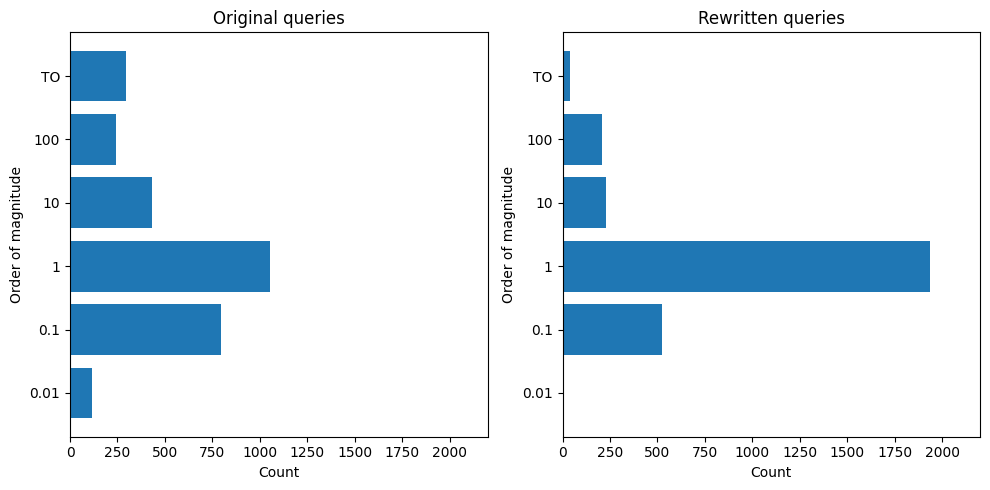

In [5]:
numbers_orig = [count_0_01_orig, count_0_1_orig, count_1_orig, count_10_orig, count_100_orig, count_TO_orig]
numbers_rewr = [count_0_01_rewr, count_0_1_rewr, count_1_rewr, count_10_rewr, count_100_rewr, count_TO_rewr]

# Indices for each number
indices = ["0.01", "0.1", "1", "10", "100", "TO"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original numbers
axs[0].barh(indices, numbers_orig)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Order of magnitude')
axs[0].set_title('Original queries')
axs[0].set_xlim(0, 2200)

# Plot rewritten numbers
axs[1].barh(indices, numbers_rewr)
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Order of magnitude')
axs[1].set_title('Rewritten queries')
axs[1].set_xlim(0, 2200)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Import the data

In [6]:
file_path = 'results/features_times_POS_extra.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
0  STATS              001-014            orig                 orig   0.030513   
1  STATS        001-014-augA1            orig                 orig   0.030952   
2  STATS        001-014-augA2            orig                 orig   0.030812   
3  STATS        001-014-augF1            orig                 orig   0.029663   
4  STATS  001-014-augF1-augA1            orig                 orig   0.030595   

   rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  #relations  \
0   0.063829        1.989236        0.033316             1.958724           3   
1   0.043271        1.840104        0.012320             1.809152           3   
2   0.168679        1.987010        0.137867             1.956198           3   
3   0.156431        1.988726        0.126768             1.959062           3   
4   0.043383        1.898386        0.012788             1.867790           3   

   ...  median(branching factors)  q25(branching factors)  \
0  ...                        2.0                     2.0   
1  ...                        1.0                     1.0   
2  ...                        1.0                     1.0   
3  ...                        2.0                     2.0   
4  ...                        1.0                     1.0   

   q75(branching factors)  balancedness factor  list table rows  \
0                     2.0                  1.0  [99392, 985, 1]   
1                     1.0                  NaN  [99392, 985, 1]   
2                     1.0                  NaN  [99392, 985, 1]   
3                     2.0                  1.0  [99392, 798, 1]   
4                     1.0                  NaN  [99392, 798, 1]   

   list join rows                          container counts list  \
0     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2     [27256, 84]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3     [22078, 68]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4     [22078, 68]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                         hypergraph  \
0                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
1                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
2                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
3                     [2]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   
4                  [1, 1]  b'\x80\x04\x95\xe8\x01\x00\x00\x00\x00\x00\x00...   

                                                text  
0  SELECT MIN(u.Id) FROM comments as c, votes as ...  
1  SELECT MIN(c.id) FROM comments as c, votes as ...  
2  SELECT MIN(v.id) FROM comments as c, votes as ...  
3  SELECT MIN(u.Id) FROM comments as c, votes as ...  
4  SELECT MIN(c.id) FROM comments as c, votes as ...  

[5 rows x 46 columns]

In [7]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)                 int64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
m

In [8]:
df['max(join rows)'] = df['max(join rows)'].astype("float64")

Transform the hypergraph, which is saved as pickle object, back to a dhg hypergraph object.

In [9]:
df["hypergraph"] = df["hypergraph"].apply(lambda x: pickle.loads(eval(x)))

#### Delete those examples, where both methods gave a timeout

In [10]:
df[df["orig/rewr(mean)"] == "-"]

bench              query orig/rewr(mean) orig/rewr+rewr(mean)  orig mean  \
2071  SNAP        wiki-path05               -                    -      100.0   
2072  SNAP  wiki-path05-augA1               -                    -      100.0   
2073  SNAP  wiki-path05-augA2               -                    -      100.0   
2074  SNAP  wiki-path05-augA3               -                    -      100.0   
2075  SNAP  wiki-path05-augA4               -                    -      100.0   
2076  SNAP  wiki-path05-augA5               -                    -      100.0   
2077  SNAP        wiki-path06               -                    -      100.0   
2078  SNAP  wiki-path06-augA1               -                    -      100.0   
2079  SNAP  wiki-path06-augA2               -                    -      100.0   
2080  SNAP  wiki-path06-augA3               -                    -      100.0   
2081  SNAP  wiki-path06-augA4               -                    -      100.0   
2082  SNAP  wiki-path06-augA5               -                    -      100.0   
2083  SNAP  wiki-path06-augA6               -                    -      100.0   
2084  SNAP        wiki-path07               -                    -      100.0   
2085  SNAP  wiki-path07-augA1               -                    -      100.0   
2086  SNAP  wiki-path07-augA2               -                    -      100.0   
2087  SNAP  wiki-path07-augA3               -                    -      100.0   
2088  SNAP  wiki-path07-augA4               -                    -      100.0   
2089  SNAP  wiki-path07-augA5               -                    -      100.0   
2090  SNAP  wiki-path07-augA6               -                    -      100.0   
2091  SNAP  wiki-path07-augA7               -                    -      100.0   
2092  SNAP        wiki-path08               -                    -      100.0   
2093  SNAP  wiki-path08-augA1               -                    -      100.0   
2094  SNAP  wiki-path08-augA2               -                    -      100.0   
2095  SNAP  wiki-path08-augA3               -                    -      100.0   
2096  SNAP  wiki-path08-augA4               -                    -      100.0   
2097  SNAP  wiki-path08-augA5               -                    -      100.0   
2098  SNAP  wiki-path08-augA6               -                    -      100.0   
2099  SNAP  wiki-path08-augA7               -                    -      100.0   
2100  SNAP  wiki-path08-augA8               -                    -      100.0   
2112  SNAP        wiki-tree03               -                    -      100.0   
2113  SNAP  wiki-tree03-augA1               -                    -      100.0   
2114  SNAP  wiki-tree03-augA2               -                    -      100.0   
2115  SNAP  wiki-tree03-augA3               -                    -      100.0   
2116  SNAP  wiki-tree03-augA4               -                    -      100.0   
2117  SNAP  wiki-tree03-augA5               -                    -      100.0   
2118  SNAP  wiki-tree03-augA6               -                    -      100.0   
2119  SNAP  wiki-tree03-augA7               -                    -      100.0   

      rewr mean  rewr mean+rewr  diff rewr-orig  diff rewr+rewr-orig  \
2071      100.0           100.0             0.0                  0.0   
2072      100.0           100.0             0.0                  0.0   
2073      100.0           100.0             0.0                  0.0   
2074      100.0           100.0             0.0                  0.0   
2075      100.0           100.0             0.0                  0.0   
2076      100.0           100.0             0.0                  0.0   
2077      100.0           100.0             0.0                  0.0   
2078      100.0           100.0             0.0                  0.0   
2079      100.0           100.0             0.0                  0.0   
2080      100.0           100.0             0.0                  0.0   
2081      100.0           100.0             0.0      

For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [11]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(2898, 46)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [12]:
X = df.iloc[:, 9:39]
X.head()

#relations  #conditions  #filters  #joins  total cost  min(table rows)  \
0           3            7         5       2    10171.10                1   
1           3            7         5       2    10171.10                1   
2           3            7         5       2    10171.10                1   
3           3            7         5       2    10099.27                1   
4           3            7         5       2    10099.27                1   

   max(table rows)  mean(table rows)  q25(table rows)  median(table rows)  \
0            99392      33459.333333            493.0               985.0   
1            99392      33459.333333            493.0               985.0   
2            99392      33459.333333            493.0               985.0   
3            99392      33397.000000            399.5               798.0   
4            99392      33397.000000            399.5               798.0   

   ...  mean(container counts)  q25(container counts)  \
0  ...                1.133333                    1.0   
1  ...                1.133333                    1.0   
2  ...                1.133333                    1.0   
3  ...                1.133333                    1.0   
4  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       1   
2                       1.0                    1.0                       1   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       1   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       1                      1.0                        1.0   
2                       1                      1.0                        1.0   
3                       2                      2.0                        2.0   
4                       1                      1.0                        1.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     1.0                     1.0  
2                     1.0                     1.0  
3                     2.0                     2.0  
4                     1.0                     1.0  

[5 rows x 30 columns]

Get the feature matrix, which additionally includes the hypergraph information/representation.

In [13]:
X_hg = pd.concat([X, df.iloc[:,44]], axis = 1)
X_hg.head()

#relations  #conditions  #filters  #joins  total cost  min(table rows)  \
0           3            7         5       2    10171.10                1   
1           3            7         5       2    10171.10                1   
2           3            7         5       2    10171.10                1   
3           3            7         5       2    10099.27                1   
4           3            7         5       2    10099.27                1   

   max(table rows)  mean(table rows)  q25(table rows)  median(table rows)  \
0            99392      33459.333333            493.0               985.0   
1            99392      33459.333333            493.0               985.0   
2            99392      33459.333333            493.0               985.0   
3            99392      33397.000000            399.5               798.0   
4            99392      33397.000000            399.5               798.0   

   ...  q25(container counts)  median(container counts)  \
0  ...                    1.0                       1.0   
1  ...                    1.0                       1.0   
2  ...                    1.0                       1.0   
3  ...                    1.0                       1.0   
4  ...                    1.0                       1.0   

   q75(container counts)  min(branching factors)  max(branching factors)  \
0                    1.0                       2                       2   
1                    1.0                       1                       1   
2                    1.0                       1                       1   
3                    1.0                       2                       2   
4                    1.0                       1                       1   

   mean(branching factors)  median(branching factors)  q25(branching factors)  \
0                      2.0                        2.0                     2.0   
1                      1.0                        1.0                     1.0   
2                      1.0                        1.0                     1.0   
3                      2.0                        2.0                     2.0   
4                      1.0                        1.0                     1.0   

   q75(branching factors)                     hypergraph  
0                     2.0  Hypergraph(num_v=17, num_e=3)  
1                     1.0  Hypergraph(num_v=17, num_e=3)  
2                     1.0  Hypergraph(num_v=17, num_e=3)  
3                     2.0  Hypergraph(num_v=17, num_e=3)  
4                     1.0  Hypergraph(num_v=17, num_e=3)  

[5 rows x 31 columns]

#### Log-transformations

In [14]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                   2.000000  1.100000e+01  9.000000e+00
#conditions                  2.000000  2.000000e+01  1.800000e+01
#filters                     0.000000  1.600000e+01  1.600000e+01
#joins                       1.000000  1.200000e+01  1.100000e+01
total cost                 209.970000  8.739948e+16  8.739948e+16
min(table rows)              1.000000  1.187967e+07  1.187967e+07
max(table rows)             19.000000  2.851121e+07  2.851119e+07
mean(table rows)             4.600000  2.573929e+07  2.573928e+07
q25(table rows)              1.000000  2.851121e+07  2.851121e+07
median(table rows)           1.000000  2.851121e+07  2.851121e+07
q75(table rows)              1.000000  2.851121e+07  2.851121e+07
min(join rows)               1.000000  2.000964e+10  2.000964e+10
max(join rows)               2.000000  5.116067e+18  5.116067e+18
mean(join rows)              1.200000  1.705356e+18  1.705356e+18
q25(join rows)               1.000000  8.913309e+10  8.913309e+10
median(join rows)            1.000000  3.504115e+11  3.504115e+11
q75(join rows)               1.000000  2.558033e+18  2.558033e+18
depth                        1.000000  7.000000e+00  6.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.500000e+00  5.000000e-01
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00

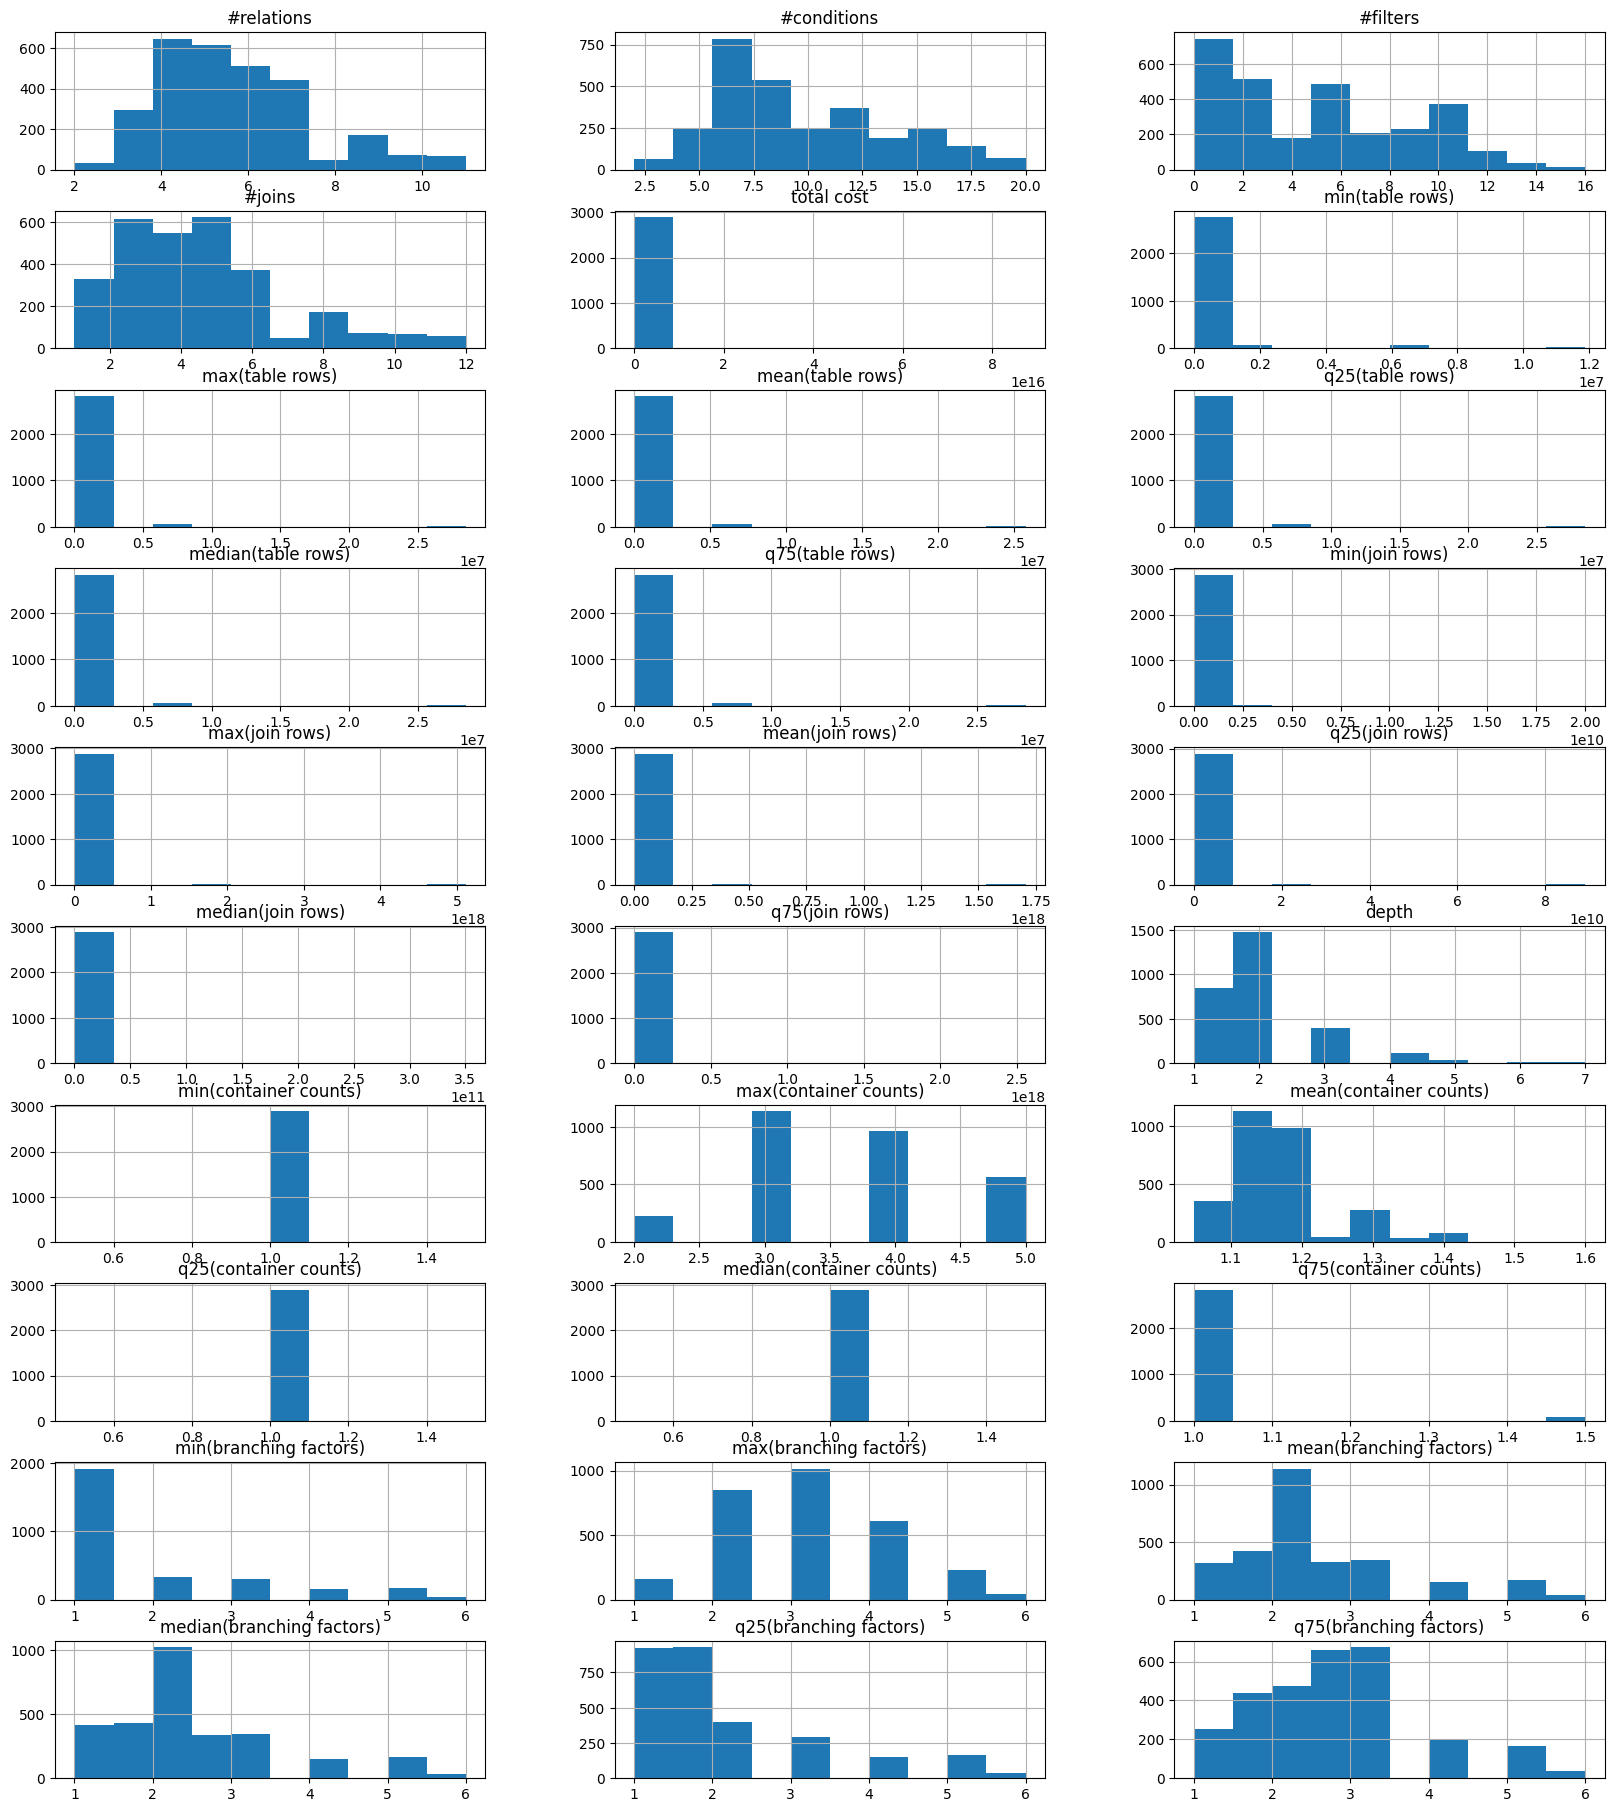

In [15]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

We transform all table rows and join rows variables and the total cost.

In [16]:
columns_to_log = ['total cost', 'min(table rows)', 'max(table rows)',
       'mean(table rows)', 'q25(table rows)', 'median(table rows)',
       'q75(table rows)', 'min(join rows)', 'max(join rows)',
       'mean(join rows)', 'q25(join rows)', 'median(join rows)',
       'q75(join rows)']
X[columns_to_log] = X[columns_to_log].apply(np.log)

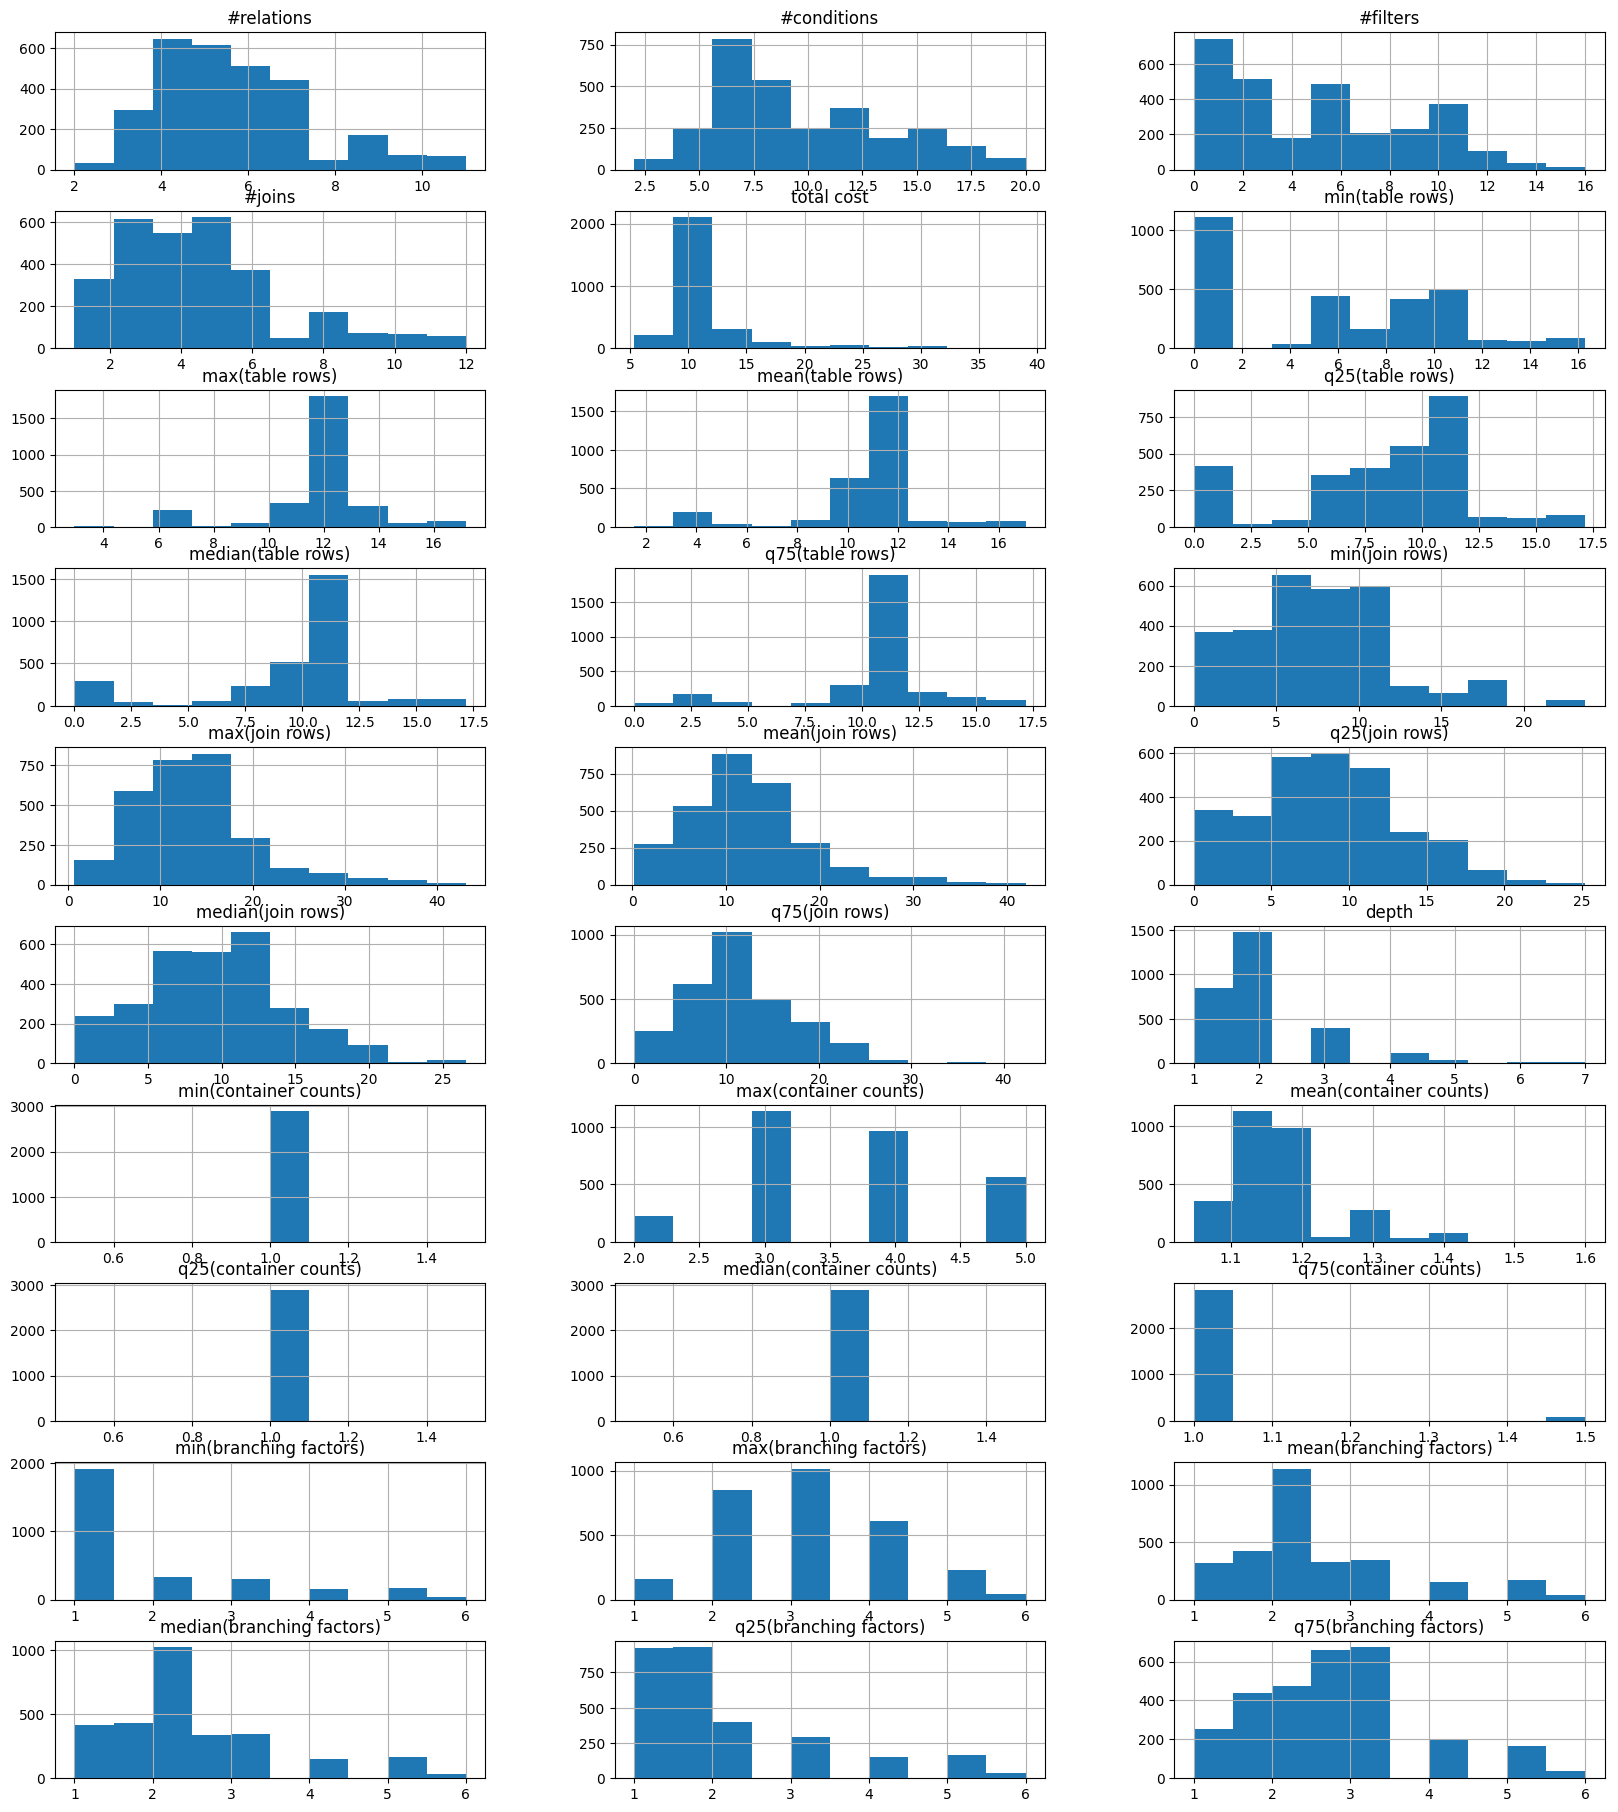

In [17]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

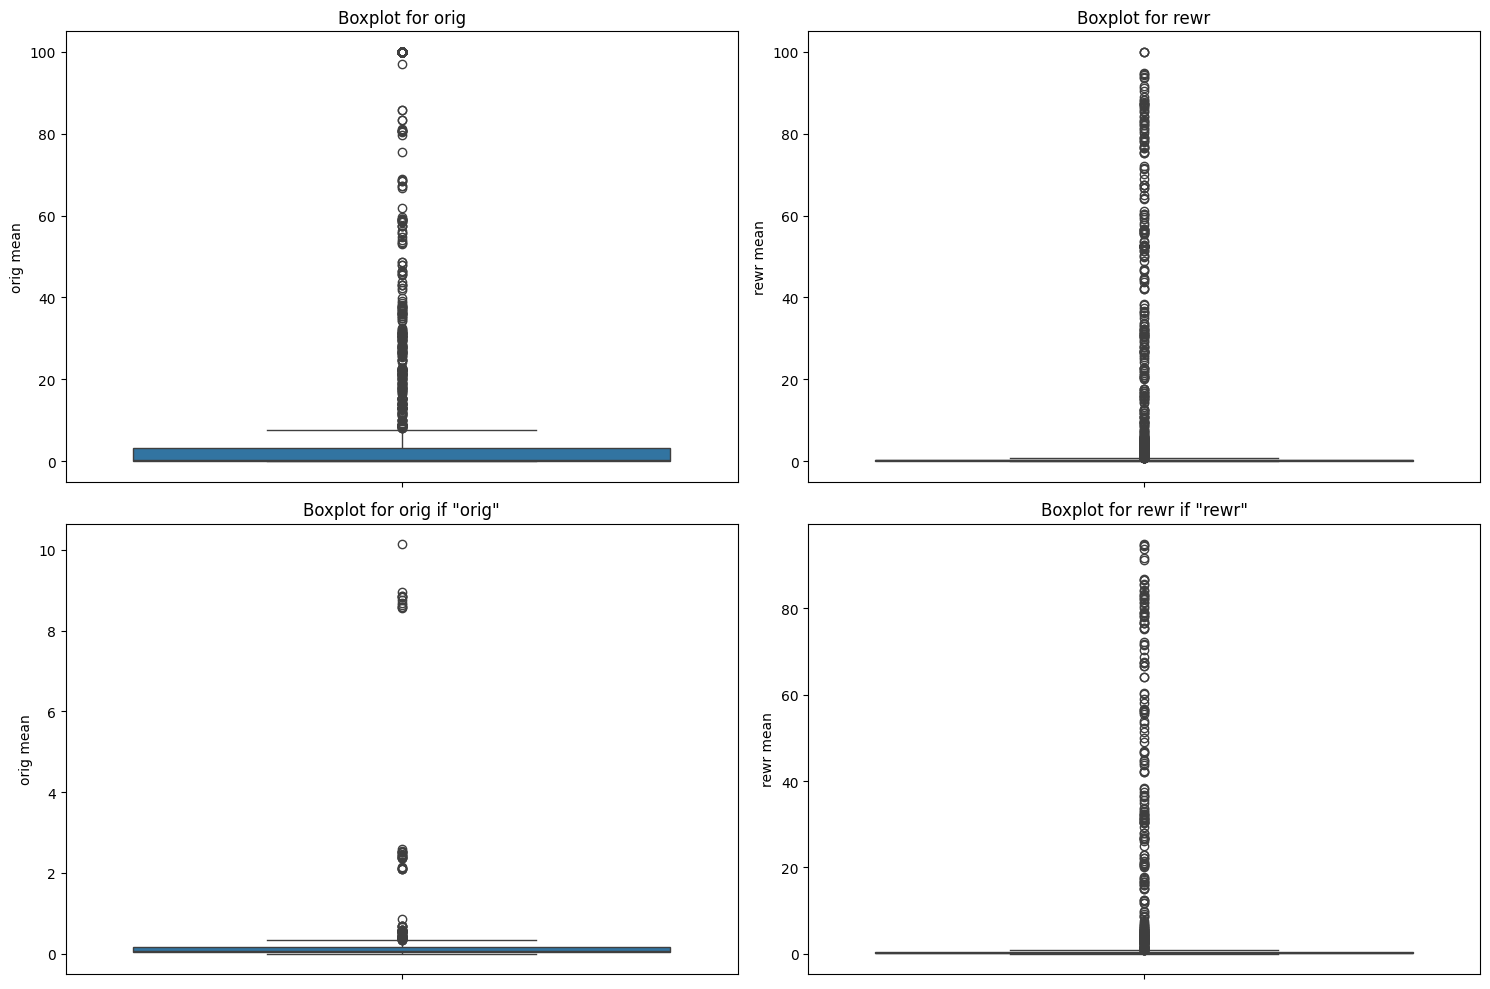

In [18]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr if "rewr"')

plt.tight_layout()
plt.show()

The runtimes are highly skewed. Therefore, we log transform them

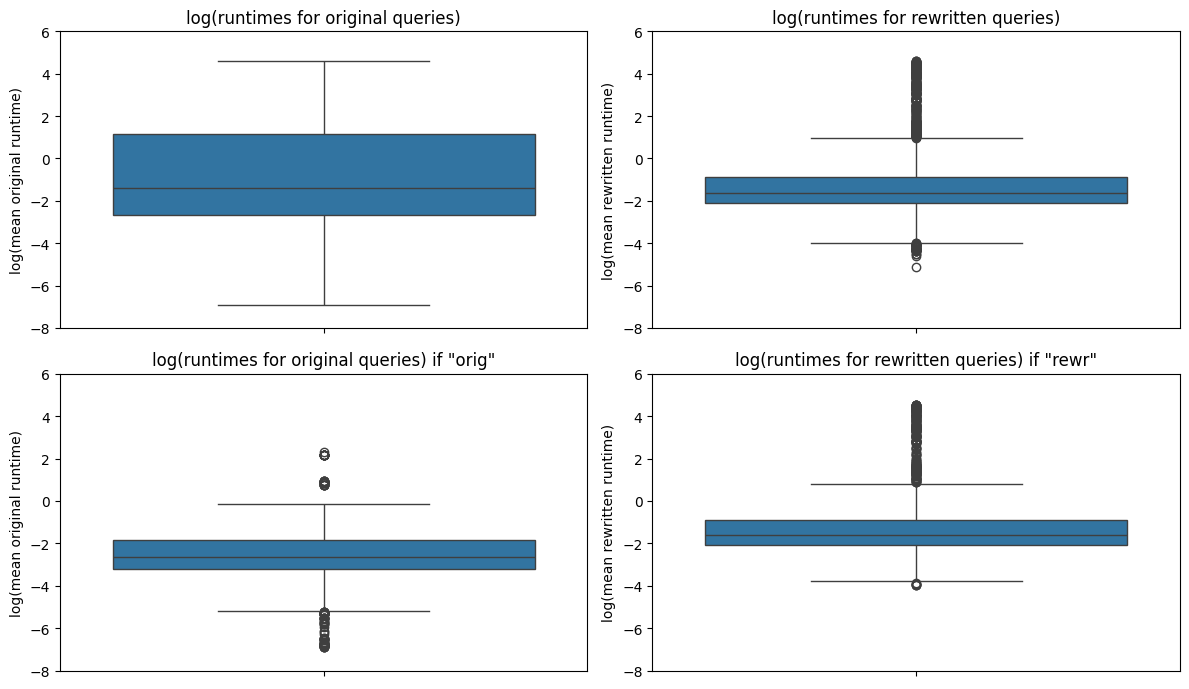

In [19]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(12,7))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'log(runtimes for original queries)')
axes[0,0].set_ylabel("log(mean original runtime)")
axes[0,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'log(runtimes for rewritten queries)')
axes[0,1].set_ylabel("log(mean rewritten runtime)")
axes[0,1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'log(runtimes for original queries) if "orig"')
axes[1,0].set_ylabel("log(mean original runtime)")
axes[1,0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[1,1].set_ylabel("log(mean rewritten runtime)")
axes[1,1].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

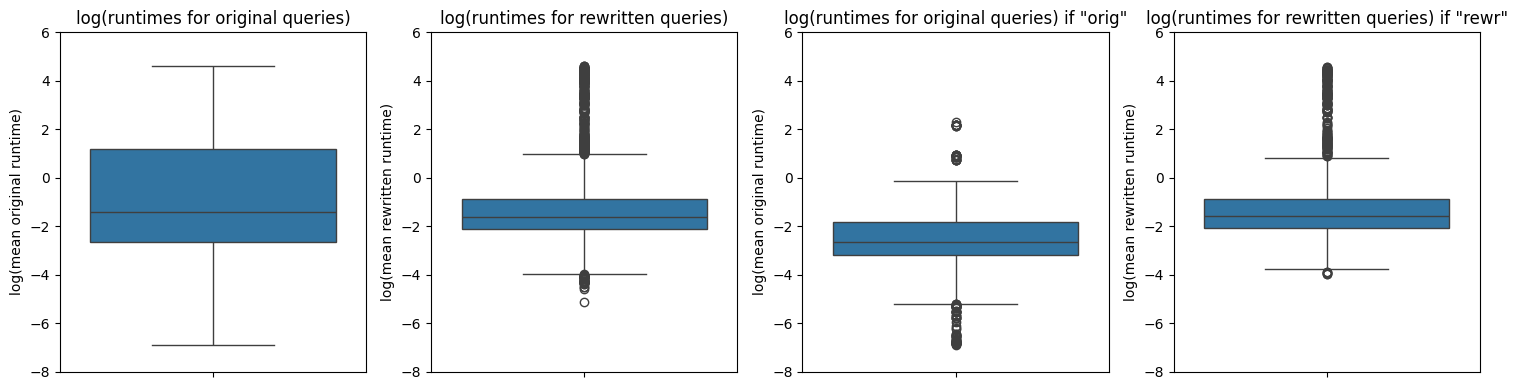

In [20]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(1,4, figsize=(15,4))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0])
axes[0].set_title(f'log(runtimes for original queries)')
axes[0].set_ylabel("log(mean original runtime)")
axes[0].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[1])
axes[1].set_title(f'log(runtimes for rewritten queries)')
axes[1].set_ylabel("log(mean rewritten runtime)")
axes[1].set_ylim(-8, 6) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[2])
axes[2].set_title(f'log(runtimes for original queries) if "orig"')
axes[2].set_ylabel("log(mean original runtime)")
axes[2].set_ylim(-8, 6) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[3])
axes[3].set_title(f'log(runtimes for rewritten queries) if "rewr"')
axes[3].set_ylabel("log(mean rewritten runtime)")
axes[3].set_ylim(-8, 6) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

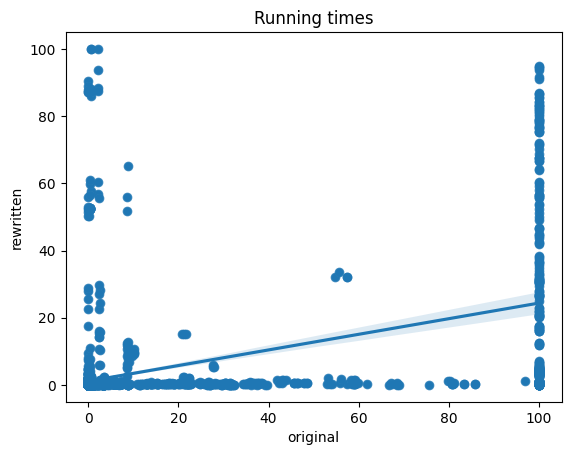

In [21]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

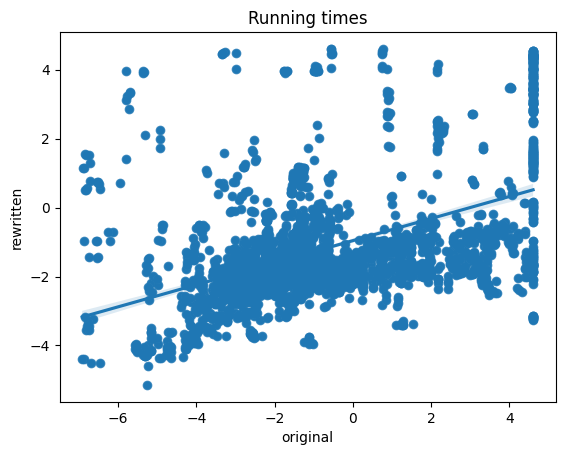

In [22]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [23]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [24]:
y1.value_counts()

orig/rewr(mean)
1    1480
0    1418
Name: count, dtype: int64

In [25]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["orig", "rewr", "equal"]
count

orig     1418
rewr     1480
equal       -
dtype: object

In [26]:
df["orig/rewr(mean)"].value_counts()

orig/rewr(mean)
rewr    1480
orig    1418
Name: count, dtype: int64

#### Classification response with three cases

In [27]:
condition = abs(df["diff rewr-orig"]) < 0.5
df["orig/rewr/equal 0.5"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.5'] = 'equal'

In [28]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

In [29]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

In [30]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

In [31]:
count_05 = df["orig/rewr/equal 0.5"].value_counts()
count_01 = df["orig/rewr/equal 0.1"].value_counts()
count_005 = df["orig/rewr/equal 0.05"].value_counts()
count_001 = df["orig/rewr/equal 0.01"].value_counts()

In [32]:
count_001

orig/rewr/equal 0.01
rewr     1435
orig     1322
equal     141
Name: count, dtype: int64

In [33]:
counts = pd.concat([count_001, count_005, count_01, count_05], axis = 1)
counts.iloc[[0, 1]] = counts.iloc[[1, 0]].values
counts.index = ["orig", "rewr", "equal"]
counts = pd.concat([count, counts], axis = 1)
counts.columns = ["2 classes", "3 classes (0.01)", "3 classes (0.05)", "3 classes (0.1)", "3 classes (0.5)"]
counts

2 classes  3 classes (0.01)  3 classes (0.05)  3 classes (0.1)  \
orig       1418              1322              1007              706   
rewr       1480              1435              1336             1243   
equal         -               141               555              949   

       3 classes (0.5)  
orig               240  
rewr               989  
equal             1669

In [34]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_05 = df['orig/rewr/equal 0.5'].map(mapping1)
y1_equal_05.head()

0    0
1    0
2    0
3    0
4    0
Name: orig/rewr/equal 0.5, dtype: int64

In [35]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.1, dtype: int64

In [36]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0    0
1    0
2   -1
3   -1
4    0
Name: orig/rewr/equal 0.05, dtype: int64

In [37]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [38]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

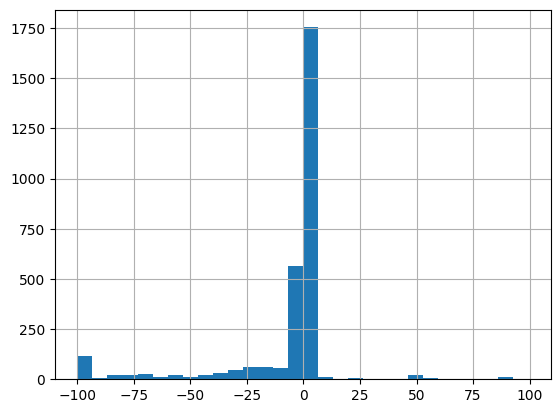

In [39]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

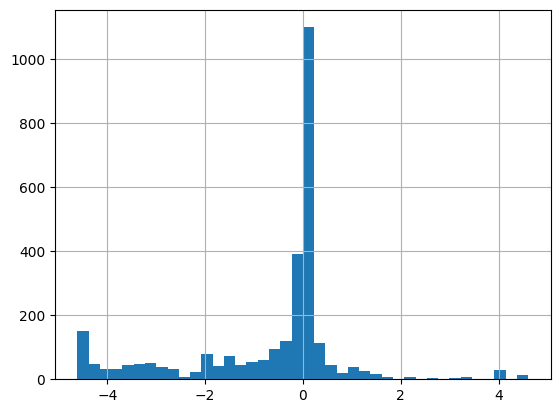

In [40]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

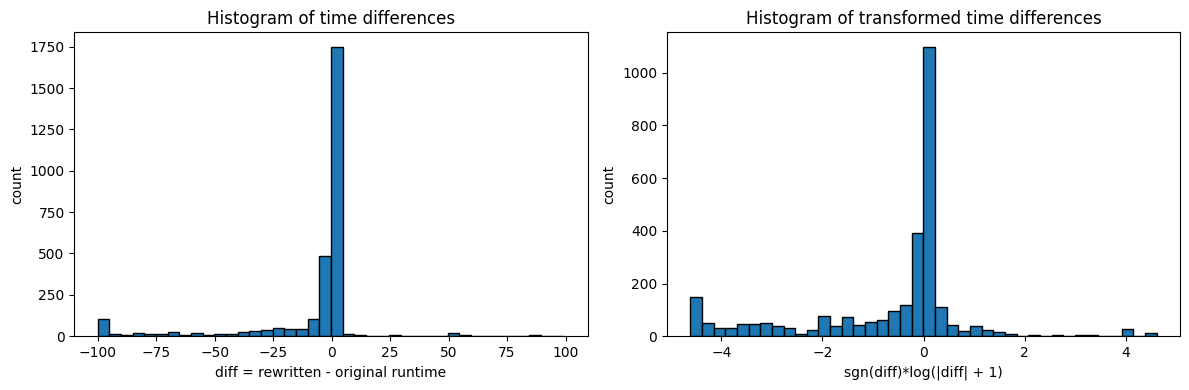

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(y1_diff, bins=40, edgecolor='black')
axs[0].set_title('Histogram of time differences')
axs[0].set_ylabel("count")
axs[0].set_xlabel("diff = rewritten - original runtime")

# Create the second histogram
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) + 1)
axs[1].hist(y1_diff_log, bins=40, edgecolor='black')
axs[1].set_title('Histogram of transformed time differences')
axs[1].set_ylabel("count")
axs[1].set_xlabel("sgn(diff)*log(|diff| + 1)")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [42]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)
X_train_hg = X_hg.loc[X_train.index]
X_val_hg = X_hg.loc[X_val.index]
X_test_hg = X_hg.loc[X_test.index]
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_05_train = y1_equal_05.loc[y1_train.index]
y1_equal_05_val = y1_equal_05.loc[y1_val.index]
y1_equal_05_test = y1_equal_05.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

#### Cross-validation split

We take the same 10% as test set and use the rest for cross-validation.

In [43]:
X_train_cv = pd.concat([X_train, X_val], axis = 0)
y1_train_cv = pd.concat([y1_train, y1_val], axis = 0)
y1_diff_log_train_cv = pd.concat([y1_diff_log_train, y1_diff_log_val], axis = 0)
y1_equal_05_train_cv = pd.concat([y1_equal_05_train, y1_equal_05_val], axis = 0)
y1_equal_01_train_cv = pd.concat([y1_equal_01_train, y1_equal_01_val], axis = 0)
y1_equal_005_train_cv = pd.concat([y1_equal_005_train, y1_equal_005_val], axis = 0)
y1_equal_001_train_cv = pd.concat([y1_equal_001_train, y1_equal_001_val], axis = 0)

In [48]:
model = RandomForestRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mse)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree_reg)
print(mae)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree_reg)
print(r2)

0.06607944449878121
0.11660522425014466
0.9759425584752267


In [49]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.7827586206896552
0.6134969325153374


array([[127,   0],
       [ 63, 100]])

In [50]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.7827586206896552
0.6134969325153374


array([[127,   0],
       [ 63, 100]])

In [51]:
y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = accuracy_score(y1_val, y1_pred_dec_tree_class)
print(accuracy)
recall = recall_score(y1_val, y1_pred_dec_tree_class)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
conf_matrix

0.8896551724137931
0.8098159509202454


array([[126,   1],
       [ 31, 132]])

## ML models

In [44]:
table_2_classes = pd.DataFrame(columns=['acc', 'rec', 'acc', 'rec'])
table_3_classes = pd.DataFrame(columns=['acc', 'rec-mic', 'rec_mac', 'acc', 'rec-mic', 'rec-mac'])
table_time_diff = pd.DataFrame(columns=['MSE', 'MAE', 'R2', 'MSE', 'MAE', 'R2'])

### k-Nearest Neighbors with two classes

Train-test split:

In [45]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_train)
y1_pred_knn = clf.predict(X_val)

In [46]:
accuracy = accuracy_score(y1_val, y1_pred_knn)
recall = recall_score(y1_val, y1_pred_knn)
conf_matrix = confusion_matrix(y1_val, y1_pred_knn)
conf_matrix

array([[120,   7],
       [ 26, 137]])

CV:

In [47]:
y1_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [48]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_knn_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_knn_cv)
conf_matrix_cv

array([[1167,  107],
       [ 135, 1199]])

Adding the values to the result table:

In [49]:
table_2_classes.loc["5-NN"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN  0.886207  0.840491  0.907209  0.898801

### k-Nearest Neighbors with three classes

##### equal cut off: 0.5

Train-test split:

In [50]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_knn = clf.predict(X_val)

In [51]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_knn)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_knn)
conf_matrix

array([[ 23,   2,   0],
       [  5, 154,  10],
       [  0,  16,  80]])

CV:

In [52]:
y1_equal_05_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [53]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_knn_cv)
conf_matrix_cv

array([[ 168,   50,    1],
       [  43, 1395,   51],
       [   5,   77,  818]])

Adding the values to the result table:

In [54]:
table_3_classes.loc["5-NN 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac      acc  rec-mic   rec-mac
5-NN 0.5  0.886207  0.886207  0.888192  0.91296  0.91296  0.870961

##### equal cut off: 0.1

Train-test split:

In [55]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_knn = clf.predict(X_val)

In [56]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_knn)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_knn)
conf_matrix

array([[ 48,   9,   2],
       [ 11,  79,   7],
       [  3,  13, 118]])

CV:

In [57]:
y1_equal_01_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [58]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_knn_cv)
conf_matrix_cv

array([[ 456,  152,   14],
       [ 132,  661,   64],
       [  24,   69, 1036]])

Adding the values to the result table:

In [59]:
table_3_classes.loc["5-NN 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5  0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1  0.844828  0.844828  0.836196  0.825537  0.825537  0.807347

##### equal cut off: 0.05

Train-test split:

In [60]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_knn = clf.predict(X_val)

In [61]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_knn)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_knn)
conf_matrix

array([[ 77,  10,   6],
       [ 18,  32,   6],
       [  8,   8, 125]])

CV:

In [62]:
y1_equal_005_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [63]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_knn_cv)
conf_matrix_cv

array([[ 747,  116,   36],
       [ 184,  254,   62],
       [  52,   54, 1103]])

Adding the values to the result table:

In [64]:
table_3_classes.loc["5-NN 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1   0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05  0.806897  0.806897  0.761970  0.806748  0.806748  0.750416

##### equal cut off: 0.01

Train-test split:

In [65]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_knn = clf.predict(X_val)

In [66]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_knn)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_knn, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_knn)
conf_matrix

array([[110,   2,   7],
       [ 15,   1,   3],
       [ 19,   0, 133]])

CV:

In [67]:
y1_equal_001_pred_knn_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [68]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_knn_cv)
conf_matrix_cv

array([[1077,   20,   89],
       [  70,   30,   29],
       [ 119,    6, 1168]])

Adding the values to the result table:

In [69]:
table_3_classes.loc["5-NN 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5   0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1   0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05  0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01  0.841379  0.841379  0.617334  0.872316  0.872316  0.681326

### k-Nearest Neighbors with time difference

Train-test split:

In [70]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y1_diff_log_train)
y1_pred_knn = model.predict(X_val)

In [71]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_knn)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_knn)
r2 = r2_score(y1_diff_log_val, y1_pred_knn)

CV:

In [72]:
y1_pred_knn_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [73]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_knn_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_knn_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_knn_cv)

Adding the values to the result table:

In [74]:
table_time_diff.loc["5-NN"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN  0.258096  0.246637  0.906035  0.271332  0.239364  0.901992

### Decision tree with two classes

Train-test split:

In [75]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [76]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
recall = recall_score(y1_val, y1_pred_dec_tree)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[122,   5],
       [ 16, 147]])

CV:

In [77]:
y1_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [78]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_dec_tree_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_dec_tree_cv)
conf_matrix_cv

array([[1203,   71],
       [  97, 1237]])

Adding the values to the result table:

In [79]:
table_2_classes.loc["Decision tree"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.886207  0.840491  0.907209  0.898801
Decision tree  0.927586  0.901840  0.935583  0.927286

### Decision tree with three classes

##### equal cut off: 0.5

Train-test split:

In [80]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_dec_tree = clf.predict(X_val)

In [81]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_dec_tree)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_dec_tree)
conf_matrix

array([[ 23,   2,   0],
       [ 10, 157,   2],
       [  0,   2,  94]])

CV:

In [82]:
y1_equal_05_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [83]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_dec_tree_cv)
conf_matrix_cv

array([[ 174,   44,    1],
       [  72, 1411,    6],
       [   6,   11,  883]])

Adding the values to the result table:

In [84]:
table_3_classes.loc["Decision tree 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1           0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05          0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01          0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5  0.944828  0.944828  0.942720  0.946319  0.946319  0.907749

##### equal cut off: 0.1

Train-test split:

In [85]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [86]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[ 53,   6,   0],
       [ 18,  77,   2],
       [  1,   5, 128]])

CV:

In [87]:
y1_equal_01_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [88]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_dec_tree_cv)
conf_matrix_cv

array([[ 502,  112,    8],
       [ 162,  665,   30],
       [  13,   48, 1068]])

Adding the values to the result table:

In [89]:
table_3_classes.loc["Decision tree 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5           0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1           0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05          0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01          0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5  0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1  0.889655  0.889655  0.882448  0.856979  0.856979  0.843002

##### equal cut off: 0.05

Train-test split:

In [90]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [91]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[ 81,  10,   2],
       [ 12,  42,   2],
       [  3,   3, 135]])

CV:

In [92]:
y1_equal_005_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [93]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_dec_tree_cv)
conf_matrix_cv

array([[ 770,  115,   14],
       [ 169,  308,   23],
       [  25,   38, 1146]])

Adding the values to the result table:

In [94]:
table_3_classes.loc["Decision tree 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799

##### equal cut off: 0.01

Train-test split:

In [95]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [96]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_dec_tree, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[110,   4,   5],
       [ 13,   4,   2],
       [ 10,   3, 139]])

CV:

In [97]:
y1_equal_001_pred_dec_tree_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [98]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_dec_tree_cv)
conf_matrix_cv

array([[1100,   41,   45],
       [  66,   43,   20],
       [  68,   20, 1205]])

Adding the values to the result table:

In [99]:
table_3_classes.loc["Decision tree 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921

### Decision tree with time difference

Train-test split:

In [100]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [101]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_dec_tree)
r2 = r2_score(y1_diff_log_val, y1_pred_dec_tree)

CV:

In [102]:
y1_pred_dec_tree_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [103]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_dec_tree_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_dec_tree_cv)

Adding the values to the result table:

In [104]:
table_time_diff.loc["Decision tree"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree  0.084586  0.109318  0.969205  0.125882  0.112860  0.954530

### Random forest with two classes

Train-test split:

In [105]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

In [106]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
recall = recall_score(y1_val, y1_pred_rand_forest)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[123,   4],
       [ 12, 151]])

CV:

In [107]:
y1_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=10)

In [108]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_rand_forest_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_rand_forest_cv)
conf_matrix_cv

array([[1203,   71],
       [  81, 1253]])

Adding the values to the result table:

In [109]:
table_2_classes.loc["Random forest"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.886207  0.840491  0.907209  0.898801
Decision tree  0.927586  0.901840  0.935583  0.927286
Random forest  0.944828  0.926380  0.941718  0.939280

### Random forest with three classes

##### equal cut off: 0.5

Train-test split:

In [110]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_rand_forest = clf.predict(X_val)

In [111]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_rand_forest)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_rand_forest)
conf_matrix

array([[ 23,   2,   0],
       [  7, 160,   2],
       [  0,   2,  94]])

CV:

In [112]:
y1_equal_05_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=10)

In [113]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_rand_forest_cv)
conf_matrix_cv

array([[ 162,   56,    1],
       [  51, 1431,    7],
       [   5,   10,  885]])

Adding the values to the result table:

In [114]:
table_3_classes.loc["Random forest 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702

##### equal cut off: 0.1

Train-test split:

In [115]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_rand_forest = clf.predict(X_val)

In [116]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_rand_forest)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_rand_forest)
conf_matrix

array([[ 51,   8,   0],
       [ 13,  82,   2],
       [  1,   3, 130]])

CV:

In [117]:
y1_equal_01_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=10)

In [118]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_rand_forest_cv)
conf_matrix_cv

array([[ 487,  128,    7],
       [ 138,  685,   34],
       [   9,   35, 1085]])

Adding the values to the result table:

In [119]:
table_3_classes.loc["Random forest 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762

##### equal cut off: 0.05

Train-test split:

In [120]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_rand_forest = clf.predict(X_val)

In [121]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_rand_forest)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_rand_forest)
conf_matrix

array([[ 82,  10,   1],
       [ 12,  40,   4],
       [  2,   2, 137]])

CV:

In [122]:
y1_equal_005_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=10)

In [123]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_rand_forest_cv)
conf_matrix_cv

array([[ 755,  131,   13],
       [ 144,  325,   31],
       [  18,   28, 1163]])

Adding the values to the result table:

In [124]:
table_3_classes.loc["Random forest 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258

##### equal cut off: 0.01

Train-test split:

In [125]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_rand_forest = clf.predict(X_val)

In [126]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_rand_forest)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_rand_forest, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_rand_forest)
conf_matrix

array([[111,   4,   4],
       [ 13,   4,   2],
       [  6,   4, 142]])

CV:

In [127]:
y1_equal_001_pred_rand_forest_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=10)

In [128]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_rand_forest_cv)
conf_matrix_cv

array([[1098,   40,   48],
       [  62,   42,   25],
       [  59,   19, 1215]])

Adding the values to the result table:

In [129]:
table_3_classes.loc["Random forest 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353

### Random forest with time difference

Train-test split:

In [130]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [131]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_rand_forest)
r2 = r2_score(y1_diff_log_val, y1_pred_rand_forest)

CV:

In [132]:
y1_pred_rand_forest_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=10)

In [133]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_rand_forest_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_rand_forest_cv)

Adding the values to the result table:

In [134]:
table_time_diff.loc["Random forest"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree  0.084586  0.109318  0.969205  0.125882  0.112860  0.954530
Random forest  0.066079  0.116605  0.975943  0.107766  0.116251  0.961074

### SVM (Support Vector Machine) with two classes, linear kernel

Train-test split:

In [135]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [136]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[113,  14],
       [ 33, 130]])

CV:

In [137]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [138]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1089,  185],
       [ 232, 1102]])

Adding the values to the result table:

In [139]:
table_2_classes.loc["SVM linear"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.886207  0.840491  0.907209  0.898801
Decision tree  0.927586  0.901840  0.935583  0.927286
Random forest  0.944828  0.926380  0.941718  0.939280
SVM linear     0.837931  0.797546  0.840107  0.826087

### SVM with three classes, linear kernel

##### equal cut off: 0.5

Train-test split:

In [140]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [141]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 21,   3,   1],
       [  2, 150,  17],
       [  0,  19,  77]])

CV:

In [142]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [143]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 160,   56,    3],
       [  30, 1366,   93],
       [   4,  202,  694]])

Adding the values to the result table:

In [144]:
table_3_classes.loc["SVM linear 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366

##### equal cut off: 0.1

Train-test split:

In [145]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [146]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 46,  11,   2],
       [  8,  81,   8],
       [  3,  19, 112]])

CV:

In [147]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [148]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[444, 145,  33],
       [111, 666,  80],
       [ 36, 176, 917]])

Adding the values to the result table:

In [149]:
table_3_classes.loc["SVM linear 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726

##### equal cut off: 0.05

Train-test split:

In [150]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [151]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 69,  12,  12],
       [ 16,  36,   4],
       [ 13,   6, 122]])

CV:

In [152]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [153]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 703,  102,   94],
       [ 160,  253,   87],
       [ 115,   94, 1000]])

Adding the values to the result table:

In [154]:
table_3_classes.loc["SVM linear 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037

##### equal cut off: 0.01

Train-test split:

In [155]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [156]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[106,   0,  13],
       [ 14,   0,   5],
       [ 26,   0, 126]])

CV:

In [157]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [158]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1032,    0,  154],
       [ 101,    0,   28],
       [ 217,    0, 1076]])

Adding the values to the result table:

In [159]:
table_3_classes.loc["SVM linear 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442

### SVM with time difference, linear kernel

Train-test split:

In [160]:
model = SVR(kernel='linear')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [161]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [162]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [163]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [164]:
table_time_diff.loc["SVM linear"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree  0.084586  0.109318  0.969205  0.125882  0.112860  0.954530
Random forest  0.066079  0.116605  0.975943  0.107766  0.116251  0.961074
SVM linear     1.199192  0.672378  0.563412  1.263988  0.695094  0.543436

### SVM (Support Vector Machine) with two classes, polynomial kernel

Train-test split:

In [165]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [166]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[115,  12],
       [ 31, 132]])

CV:

In [167]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [168]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1142,  132],
       [ 250, 1084]])

Adding the values to the result table:

In [169]:
table_2_classes.loc["SVM poly"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.886207  0.840491  0.907209  0.898801
Decision tree  0.927586  0.901840  0.935583  0.927286
Random forest  0.944828  0.926380  0.941718  0.939280
SVM linear     0.837931  0.797546  0.840107  0.826087
SVM poly       0.851724  0.809816  0.853528  0.812594

### SVM with three classes, polynomial kernel

##### equal cut off: 0.5

Train-test split:

In [170]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [171]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 22,   2,   1],
       [  5, 154,  10],
       [  0,  22,  74]])

CV:

In [172]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [173]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 182,   34,    3],
       [  52, 1387,   50],
       [   4,  202,  694]])

Adding the values to the result table:

In [174]:
table_3_classes.loc["SVM poly 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553

##### equal cut off: 0.1

Train-test split:

In [175]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [176]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 46,  12,   1],
       [ 14,  77,   6],
       [  4,  16, 114]])

CV:

In [177]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [178]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[421, 178,  23],
       [ 96, 678,  83],
       [ 45, 154, 930]])

Adding the values to the result table:

In [179]:
table_3_classes.loc["SVM poly 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906

##### equal cut off: 0.05

Train-test split:

In [180]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [181]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 79,   5,   9],
       [ 23,  27,   6],
       [ 14,   1, 126]])

CV:

In [182]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [183]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[752,  75,  72],
       [205, 219,  76],
       [137,  75, 997]])

Adding the values to the result table:

In [184]:
table_3_classes.loc["SVM poly 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711

##### equal cut off: 0.01

Train-test split:

In [185]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [186]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[108,   0,  11],
       [ 14,   0,   5],
       [ 24,   0, 128]])

CV:

In [187]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [188]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1071,    0,  115],
       [  99,    0,   30],
       [ 223,    0, 1070]])

Adding the values to the result table:

In [189]:
table_3_classes.loc["SVM poly 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711
SVM poly 0.01       0.813793  0.813793  0.583223  0.820936  0.820936  0.576856

### SVM with time difference, polynomial kernel

Train-test split:

In [190]:
model = SVR(kernel='poly')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [191]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [192]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [193]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [194]:
table_time_diff.loc["SVM poly"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree  0.084586  0.109318  0.969205  0.125882  0.112860  0.954530
Random forest  0.066079  0.116605  0.975943  0.107766  0.116251  0.961074
SVM linear     1.199192  0.672378  0.563412  1.263988  0.695094  0.543436
SVM poly       1.029136  0.597513  0.625324  0.994276  0.596577  0.640858

### SVM (Support Vector Machine) with two classes, rbf kernel

Train-test split:

In [195]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [196]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
recall = recall_score(y1_val, y1_pred_svm_linear)
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[114,  13],
       [ 27, 136]])

CV:

In [197]:
y1_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_train_cv, cv=5)

In [198]:
accuracy_cv = accuracy_score(y1_train_cv, y1_pred_svm_linear_cv)
recall_cv = recall_score(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv = confusion_matrix(y1_train_cv, y1_pred_svm_linear_cv)
conf_matrix_cv

array([[1090,  184],
       [ 200, 1134]])

Adding the values to the result table:

In [199]:
table_2_classes.loc["SVM rbf"] = [accuracy, recall, accuracy_cv, recall_cv]
table_2_classes

acc       rec       acc       rec
5-NN           0.886207  0.840491  0.907209  0.898801
Decision tree  0.927586  0.901840  0.935583  0.927286
Random forest  0.944828  0.926380  0.941718  0.939280
SVM linear     0.837931  0.797546  0.840107  0.826087
SVM poly       0.851724  0.809816  0.853528  0.812594
SVM rbf        0.862069  0.834356  0.852761  0.850075

### SVM with three classes, rbf kernel

##### equal cut off: 0.5

Train-test split:

In [200]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_05_train)
y1_equal_05_pred_svm_linear = clf.predict(X_val)

In [201]:
accuracy = accuracy_score(y1_equal_05_val, y1_equal_05_pred_svm_linear)
recall_micro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_05_val, y1_equal_05_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_05_val, y1_equal_05_pred_svm_linear)
conf_matrix

array([[ 22,   2,   1],
       [  5, 152,  12],
       [  0,  21,  75]])

CV:

In [202]:
y1_equal_05_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_05_train_cv, cv=5)

In [203]:
accuracy_cv = accuracy_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_05_train_cv, y1_equal_05_pred_svm_linear_cv)
conf_matrix_cv

array([[ 182,   34,    3],
       [  52, 1369,   68],
       [   4,  227,  669]])

Adding the values to the result table:

In [204]:
table_3_classes.loc["SVM rbf 0.5"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711
SVM poly 0.01       0.813793  0.813793  0.583223  0.820936  0.820936  0.576856
SVM rbf 0.5         0.858621  0.858621  0.853553  0.851227  0.851227  0.831264

##### equal cut off: 0.1

Train-test split:

In [205]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_svm_linear = clf.predict(X_val)

In [206]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_svm_linear)
recall_micro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_01_val, y1_equal_01_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_svm_linear)
conf_matrix

array([[ 36,  13,  10],
       [  6,  82,   9],
       [  5,  15, 114]])

CV:

In [207]:
y1_equal_01_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_01_train_cv, cv=5)

In [208]:
accuracy_cv = accuracy_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_01_train_cv, y1_equal_01_pred_svm_linear_cv)
conf_matrix_cv

array([[374, 178,  70],
       [ 78, 667, 112],
       [ 39, 153, 937]])

Adding the values to the result table:

In [209]:
table_3_classes.loc["SVM rbf 0.1"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711
SVM poly 0.01       0.813793  0.813793  0.583223  0.820936  0.820936  0.576856
SVM rbf 0.5         0.858621  0.858621  0.853553  0.851227  0.851227  0.831264
SVM rbf 0.1         0.800000  0.800000  0.768759  0.758436  0.758436  0.736507

##### equal cut off: 0.05

Train-test split:

In [210]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_svm_linear = clf.predict(X_val)

In [211]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_svm_linear)
recall_micro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_005_val, y1_equal_005_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_svm_linear)
conf_matrix

array([[ 75,   6,  12],
       [ 16,  29,  11],
       [ 12,   1, 128]])

CV:

In [212]:
y1_equal_005_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_005_train_cv, cv=5)

In [213]:
accuracy_cv = accuracy_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_005_train_cv, y1_equal_005_pred_svm_linear_cv)
conf_matrix_cv

array([[ 718,   48,  133],
       [ 171,  192,  137],
       [ 106,   53, 1050]])

Adding the values to the result table:

In [214]:
table_3_classes.loc["SVM rbf 0.05"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711
SVM poly 0.01       0.813793  0.813793  0.583223  0.820936  0.820936  0.576856
SVM rbf 0.5         0.858621  0.858621  0.853553  0.851227  0.851227  0.831264
SVM rbf 0.1         0.800000  0.800000  0.768759  0.758436  0.758436  0.736507
SVM rbf 0.05        0.800000  0.800000  0.744037  0.751534  0.751534  0.683717

##### equal cut off: 0.01

Train-test split:

In [215]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_svm_linear = clf.predict(X_val)

In [216]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_svm_linear)
recall_micro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='micro')
recall_macro = recall_score(y1_equal_001_val, y1_equal_001_pred_svm_linear, average='macro')
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_svm_linear)
conf_matrix

array([[106,   0,  13],
       [ 13,   0,   6],
       [ 19,   0, 133]])

CV:

In [217]:
y1_equal_001_pred_svm_linear_cv = cross_val_predict(clf, X_train_cv, y1_equal_001_train_cv, cv=5)

In [218]:
accuracy_cv = accuracy_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
recall_micro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='micro')
recall_macro_cv = recall_score(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv, average='macro')
conf_matrix_cv = confusion_matrix(y1_equal_001_train_cv, y1_equal_001_pred_svm_linear_cv)
conf_matrix_cv

array([[1002,    0,  184],
       [  93,    0,   36],
       [ 175,    0, 1118]])

Adding the values to the result table:

In [219]:
table_3_classes.loc["SVM rbf 0.01"] = [accuracy, recall_micro, recall_macro, accuracy_cv, recall_micro_cv, recall_macro_cv]
table_3_classes

acc   rec-mic   rec_mac       acc   rec-mic   rec-mac
5-NN 0.5            0.886207  0.886207  0.888192  0.912960  0.912960  0.870961
5-NN 0.1            0.844828  0.844828  0.836196  0.825537  0.825537  0.807347
5-NN 0.05           0.806897  0.806897  0.761970  0.806748  0.806748  0.750416
5-NN 0.01           0.841379  0.841379  0.617334  0.872316  0.872316  0.681326
Decision tree 0.5   0.944828  0.944828  0.942720  0.946319  0.946319  0.907749
Decision tree 0.1   0.889655  0.889655  0.882448  0.856979  0.856979  0.843002
Decision tree 0.05  0.889655  0.889655  0.859472  0.852761  0.852761  0.806799
Decision tree 0.01  0.872414  0.872414  0.683123  0.900307  0.900307  0.730921
Random forest 0.5   0.955172  0.955172  0.948637  0.950153  0.950153  0.894702
Random forest 0.1   0.906897  0.906897  0.893306  0.865414  0.865414  0.847762
Random forest 0.05  0.893103  0.893103  0.855879  0.860046  0.860046  0.817258
Random forest 0.01  0.886207  0.886207  0.692503  0.902991  0.902991  0.730353
SVM linear 0.5      0.855172  0.855172  0.843219  0.851227  0.851227  0.806366
SVM linear 0.1      0.824138  0.824138  0.816844  0.777224  0.777224  0.767726
SVM linear 0.05     0.782759  0.782759  0.750014  0.750000  0.750000  0.705037
SVM linear 0.01     0.800000  0.800000  0.573235  0.808282  0.808282  0.567442
SVM poly 0.5        0.862069  0.862069  0.854025  0.867715  0.867715  0.844553
SVM poly 0.1        0.817241  0.817241  0.808074  0.777991  0.777991  0.763906
SVM poly 0.05       0.800000  0.800000  0.741741  0.754601  0.754601  0.699711
SVM poly 0.01       0.813793  0.813793  0.583223  0.820936  0.820936  0.576856
SVM rbf 0.5         0.858621  0.858621  0.853553  0.851227  0.851227  0.831264
SVM rbf 0.1         0.800000  0.800000  0.768759  0.758436  0.758436  0.736507
SVM rbf 0.05        0.800000  0.800000  0.744037  0.751534  0.751534  0.683717
SVM rbf 0.01        0.824138  0.824138  0.588585  0.812883  0.812883  0.569838

### SVM with time difference, rbf kernel

Train-test split:

In [220]:
model = SVR(kernel='rbf')
model.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = model.predict(X_val)

In [221]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mae = mean_absolute_error(y1_diff_log_val, y1_pred_svm_linear)
r2 = r2_score(y1_diff_log_val, y1_pred_svm_linear)

CV:

In [222]:
y1_pred_svm_linear_cv = cross_val_predict(model, X_train_cv, y1_diff_log_train_cv, cv=5)

In [223]:
mse_cv = mean_squared_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
mae_cv = mean_absolute_error(y1_diff_log_train_cv, y1_pred_svm_linear_cv)
r2_cv = r2_score(y1_diff_log_train_cv, y1_pred_svm_linear_cv)

Adding the values to the result table:

In [224]:
table_time_diff.loc["SVM rbf"] = [mse, mae, r2, mse_cv, mae_cv, r2_cv]
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN           0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree  0.084586  0.109318  0.969205  0.125882  0.112860  0.954530
Random forest  0.066079  0.116605  0.975943  0.107766  0.116251  0.961074
SVM linear     1.199192  0.672378  0.563412  1.263988  0.695094  0.543436
SVM poly       1.029136  0.597513  0.625324  0.994276  0.596577  0.640858
SVM rbf        0.915369  0.549977  0.666743  0.897555  0.549955  0.675795

### Deep MLP with two classes

In [225]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [226]:
def MLP_classification(X_training, y_training, X_validation, y_validation, type, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

    mlp = MLPClassifier(random_seed=20)

    loss_function = nn.CrossEntropyLoss()  
        
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            targets = targets.long()  # Convert target tensor to torch.long data type
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data).squeeze()
            val_targets = val_targets.long()
            val_loss = loss_function(val_outputs, val_targets).item()
            #print(f'Validation loss: {val_loss}')
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    print("Training has completed")


    mlp2 = MLPClassifier(random_seed=20)
    mlp2.load_state_dict(best_model_state)
    
    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data).squeeze()
        predicted_labels = torch.argmax(outputs, dim=1).numpy()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)

    if type == "2_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall = recall_score(val_targets, predicted_labels)
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(val_targets, predicted_labels)
        recall_micro = recall_score(val_targets, predicted_labels, average='micro')
        recall_macro = recall_score(val_targets, predicted_labels, average='macro')
        conf_matrix = confusion_matrix(val_targets, predicted_labels)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 30 - 5 - 2

In [227]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
            
        )

    def forward(self, x):
        return self.layers(x)

In [228]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-5-2")

Starting Epoch 1
0.6805606856942177
New best model found at epoch 1 with validation loss 0.6005753874778748
Starting Epoch 2
0.5777882114052773
New best model found at epoch 2 with validation loss 0.53705894947052
Starting Epoch 3
0.5325732765098413
New best model found at epoch 3 with validation loss 0.5068084597587585
Starting Epoch 4
0.5193016106883684
Starting Epoch 5
0.4754859233895938
Starting Epoch 6
0.47193367158373195
Starting Epoch 7
0.46083799625436467
New best model found at epoch 7 with validation loss 0.4340398907661438
Starting Epoch 8
0.4427124112844467
New best model found at epoch 8 with validation loss 0.42237889766693115
Starting Epoch 9
0.43123451868693036
New best model found at epoch 9 with validation loss 0.4177630543708801
Starting Epoch 10
0.4227379870911439
New best model found at epoch 10 with validation loss 0.413032203912735
Starting Epoch 11
0.4176966113348802
Starting Epoch 12
0.42173412442207336
Starting Epoch 13
0.41290566449364025
Starting Epoch 14
0.

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 30 - 10 - 2

In [229]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [230]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-10-2")

Starting Epoch 1
0.854991634686788
New best model found at epoch 1 with validation loss 0.7074089050292969
Starting Epoch 2
0.5730856607357661
New best model found at epoch 2 with validation loss 0.5207722187042236
Starting Epoch 3
0.5162508773307005
New best model found at epoch 3 with validation loss 0.4926377832889557
Starting Epoch 4
0.4956122984488805
New best model found at epoch 4 with validation loss 0.488746702671051
Starting Epoch 5
0.47059739629427594
Starting Epoch 6
0.4652647127707799
Starting Epoch 7
0.4440988314648469
Starting Epoch 8
0.44963618864615756
Starting Epoch 9
0.433134230474631
New best model found at epoch 9 with validation loss 0.4059079587459564
Starting Epoch 10
0.4143261822561423
Starting Epoch 11
0.41241851821541786
Starting Epoch 12
0.40308792764941853
Starting Epoch 13
0.40702362979451817
New best model found at epoch 13 with validation loss 0.39475440979003906
Starting Epoch 14
0.4006539098918438
New best model found at epoch 14 with validation loss 0

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 30 - 20 - 2

In [231]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [232]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-20-2")

Starting Epoch 1
2.1045041208465896
New best model found at epoch 1 with validation loss 0.5356227159500122
Starting Epoch 2
0.6034617212911447
Starting Epoch 3
0.5276332348585129
Starting Epoch 4
0.4842550531029701
New best model found at epoch 4 with validation loss 0.48199009895324707
Starting Epoch 5
0.46595657741030055
New best model found at epoch 5 with validation loss 0.43618935346603394
Starting Epoch 6
0.44493334988753
New best model found at epoch 6 with validation loss 0.4203667640686035
Starting Epoch 7
0.4948120353122552
Starting Epoch 8
0.43139156326651573
Starting Epoch 9
0.4452449791133404
Starting Epoch 10
0.4339984779556592
Starting Epoch 11
0.42946218078335124
Starting Epoch 12
0.41084186484416324
Starting Epoch 13
0.42512820288538933
Starting Epoch 14
0.4375937419633071
Starting Epoch 15
0.4083102761457364
New best model found at epoch 15 with validation loss 0.4200698733329773
Starting Epoch 16
0.41491051639119786
Starting Epoch 17
0.4032117302219073
New best mode

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 30 - 25 - 2

In [233]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 25),
            nn.ReLU(),
            nn.Linear(25, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [234]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-25-2")

Starting Epoch 1
3.5969333027799926
New best model found at epoch 1 with validation loss 1.0895411968231201
Starting Epoch 2
0.585535392165184
New best model found at epoch 2 with validation loss 0.8425859212875366
Starting Epoch 3
0.5223637359837691
New best model found at epoch 3 with validation loss 0.470092236995697
Starting Epoch 4
0.46467165897289914
New best model found at epoch 4 with validation loss 0.44538769125938416
Starting Epoch 5
0.4705460915962855
Starting Epoch 6
0.4466884322464466
Starting Epoch 7
0.44448399792114895
Starting Epoch 8
0.4441722482442856
Starting Epoch 9
0.4427274664243062
New best model found at epoch 9 with validation loss 0.44396355748176575
Starting Epoch 10
0.40952257812023163
New best model found at epoch 10 with validation loss 0.4287506937980652
Starting Epoch 11
0.41252193972468376
New best model found at epoch 11 with validation loss 0.40548408031463623
Starting Epoch 12
0.40439904605348903
New best model found at epoch 12 with validation loss

##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 30 - 40 - 2

In [235]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [236]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-2")

Starting Epoch 1
3.941795151680708
New best model found at epoch 1 with validation loss 0.5764385461807251
Starting Epoch 2
0.5482065267860889
New best model found at epoch 2 with validation loss 0.48102495074272156
Starting Epoch 3
0.4892560951411724
Starting Epoch 4
0.491383525232474
New best model found at epoch 4 with validation loss 0.41109001636505127
Starting Epoch 5
0.45544226343433064
New best model found at epoch 5 with validation loss 0.40358543395996094
Starting Epoch 6
0.42186953251560527
Starting Epoch 7
0.40743990366657573
New best model found at epoch 7 with validation loss 0.38535183668136597
Starting Epoch 8
0.40543517967065174
New best model found at epoch 8 with validation loss 0.3834734857082367
Starting Epoch 9
0.4197600831588109
New best model found at epoch 9 with validation loss 0.3789992034435272
Starting Epoch 10
0.39885694657762844
Starting Epoch 11
0.41249000777800876
Starting Epoch 12
0.39588428164521855
Starting Epoch 13
0.38424763766427833
Starting Epoch

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 30 - 60 - 2

In [237]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [238]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-2")

Starting Epoch 1
3.930084882924954
New best model found at epoch 1 with validation loss 0.5418416857719421
Starting Epoch 2
0.5498329438269138
New best model found at epoch 2 with validation loss 0.5029030442237854
Starting Epoch 3
0.49307831376791
New best model found at epoch 3 with validation loss 0.46565061807632446
Starting Epoch 4
0.4480040060977141
Starting Epoch 5
0.4657806567847729
New best model found at epoch 5 with validation loss 0.4453059732913971
Starting Epoch 6
0.42348823448022205
New best model found at epoch 6 with validation loss 0.4167221188545227
Starting Epoch 7
0.41279403244455654
Starting Epoch 8
0.3980339815219243
New best model found at epoch 8 with validation loss 0.3886863589286804
Starting Epoch 9
0.3902493951221307
Starting Epoch 10
0.40593399728337926
Starting Epoch 11
0.3905521643658479
Starting Epoch 12
0.36497183702886105
New best model found at epoch 12 with validation loss 0.3598349094390869
Starting Epoch 13
0.3813993701090415
Starting Epoch 14
0.3

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 30 - 10 - 5 - 2

In [239]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [240]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-10-5-2")

Starting Epoch 1
0.7383873735864958
New best model found at epoch 1 with validation loss 0.6426882147789001
Starting Epoch 2
0.5876946796973547
New best model found at epoch 2 with validation loss 0.5817424058914185
Starting Epoch 3
0.564192553361257
New best model found at epoch 3 with validation loss 0.5636509656906128
Starting Epoch 4
0.5347738104561964
Starting Epoch 5
0.5245276354253292
Starting Epoch 6
0.5247824589411417
New best model found at epoch 6 with validation loss 0.47510191798210144
Starting Epoch 7
0.4776669417818387
Starting Epoch 8
0.4502697301407655
New best model found at epoch 8 with validation loss 0.4654221534729004
Starting Epoch 9
0.4533754289150238
Starting Epoch 10
0.43578987444440526
New best model found at epoch 10 with validation loss 0.43303626775741577
Starting Epoch 11
0.427258317048351
New best model found at epoch 11 with validation loss 0.4106118083000183
Starting Epoch 12
0.40406204139192897
Starting Epoch 13
0.4126628302037716
Starting Epoch 14
0.

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 30 - 20 - 10 - 2

In [241]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [242]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-20-10-2")

Starting Epoch 1
0.9470635379354159
New best model found at epoch 1 with validation loss 0.6794034838676453
Starting Epoch 2
0.6717418655753136
New best model found at epoch 2 with validation loss 0.6339436769485474
Starting Epoch 3
0.6344890892505646
New best model found at epoch 3 with validation loss 0.5940907001495361
Starting Epoch 4
0.5710340117414793
Starting Epoch 5
0.535202025125424
New best model found at epoch 5 with validation loss 0.5039608478546143
Starting Epoch 6
0.5025560669600964
New best model found at epoch 6 with validation loss 0.4764496982097626
Starting Epoch 7
0.49868101874987286
New best model found at epoch 7 with validation loss 0.46785977482795715
Starting Epoch 8
0.4659089980026086
New best model found at epoch 8 with validation loss 0.4500691294670105
Starting Epoch 9
0.45746268332004547
Starting Epoch 10
0.4636723759273688
New best model found at epoch 10 with validation loss 0.43639296293258667
Starting Epoch 11
0.42989497755964595
Starting Epoch 12
0.4

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 20 - 2

In [243]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [244]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-20-2")

Starting Epoch 1
1.54554928590854
New best model found at epoch 1 with validation loss 0.6005439758300781
Starting Epoch 2
0.5753896422684193
New best model found at epoch 2 with validation loss 0.5404775142669678
Starting Epoch 3
0.5303037924071153
Starting Epoch 4
0.500850573182106
New best model found at epoch 4 with validation loss 0.48638710379600525
Starting Epoch 5
0.4797888634105523
Starting Epoch 6
0.46820954109231633
Starting Epoch 7
0.4783451793094476
Starting Epoch 8
0.41651152198513347
New best model found at epoch 8 with validation loss 0.4353712201118469
Starting Epoch 9
0.4189760449031989
New best model found at epoch 9 with validation loss 0.41812437772750854
Starting Epoch 10
0.4049063076575597
New best model found at epoch 10 with validation loss 0.399707168340683
Starting Epoch 11
0.3900648094713688
Starting Epoch 12
0.3957461106280486
Starting Epoch 13
0.3972298304239909
Starting Epoch 14
0.3761676289141178
New best model found at epoch 14 with validation loss 0.37

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 10 - 2

In [245]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [246]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-40-10-2")

Starting Epoch 1
1.1973962125678856
New best model found at epoch 1 with validation loss 0.6478688716888428
Starting Epoch 2
0.5518638926247755
Starting Epoch 3
0.512988759825627
New best model found at epoch 3 with validation loss 0.5995861887931824
Starting Epoch 4
0.4881059055527051
Starting Epoch 5
0.4692976661026478
New best model found at epoch 5 with validation loss 0.44072264432907104
Starting Epoch 6
0.4370100361605485
Starting Epoch 7
0.4169290376206239
New best model found at epoch 7 with validation loss 0.4044112265110016
Starting Epoch 8
0.41136303668220836
Starting Epoch 9
0.3954702168703079
New best model found at epoch 9 with validation loss 0.3967023193836212
Starting Epoch 10
0.394156535466512
Starting Epoch 11
0.3982101393242677
New best model found at epoch 11 with validation loss 0.36909765005111694
Starting Epoch 12
0.3864363133907318
Starting Epoch 13
0.3721202611923218
Starting Epoch 14
0.3732941597700119
Starting Epoch 15
0.37591631958882016
New best model foun

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 40 - 2

In [247]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [248]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-40-2")

Starting Epoch 1
5.02525893971324
New best model found at epoch 1 with validation loss 0.5607032179832458
Starting Epoch 2
0.5441199714938799
New best model found at epoch 2 with validation loss 0.477626234292984
Starting Epoch 3
0.4661000830431779
New best model found at epoch 3 with validation loss 0.4674204885959625
Starting Epoch 4
0.4454532861709595
Starting Epoch 5
0.42691679547230404
New best model found at epoch 5 with validation loss 0.4140170216560364
Starting Epoch 6
0.415445264428854
Starting Epoch 7
0.4282355234026909
Starting Epoch 8
0.4036287342508634
Starting Epoch 9
0.41332073882222176
New best model found at epoch 9 with validation loss 0.4111180901527405
Starting Epoch 10
0.403305247426033
Starting Epoch 11
0.4050027293463548
New best model found at epoch 11 with validation loss 0.37059715390205383
Starting Epoch 12
0.3752012476325035
Starting Epoch 13
0.3822827525436878
Starting Epoch 14
0.3871391216913859
Starting Epoch 15
0.36342039331793785
Starting Epoch 16
0.35

##### 4-layer MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 20 - 2

In [249]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [250]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-60-20-2")

Starting Epoch 1
2.6599122857054076
New best model found at epoch 1 with validation loss 0.5650079250335693
Starting Epoch 2
0.5429213916261991
New best model found at epoch 2 with validation loss 0.5509030818939209
Starting Epoch 3
0.5050921266277631
New best model found at epoch 3 with validation loss 0.493648499250412
Starting Epoch 4
0.49609872450431186
New best model found at epoch 4 with validation loss 0.48930853605270386
Starting Epoch 5
0.4503420554101467
Starting Epoch 6
0.4602226863304774
Starting Epoch 7
0.41355082765221596
New best model found at epoch 7 with validation loss 0.43486443161964417
Starting Epoch 8
0.43129271517197293
New best model found at epoch 8 with validation loss 0.3985380232334137
Starting Epoch 9
0.4243675122658412
Starting Epoch 10
0.3864615795512994
Starting Epoch 11
0.39120053375760716
Starting Epoch 12
0.4091005486746629
Starting Epoch 13
0.3792899549007416
Starting Epoch 14
0.3796091290811698
Starting Epoch 15
0.3764638553063075
New best model fo

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 30 - 80 - 50 - 2

In [251]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [252]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP: 30-80-50-2")

Starting Epoch 1
7.46465265750885
New best model found at epoch 1 with validation loss 0.5375279784202576
Starting Epoch 2
0.5373213477432728
New best model found at epoch 2 with validation loss 0.49393847584724426
Starting Epoch 3
0.5117901377379894
New best model found at epoch 3 with validation loss 0.46615874767303467
Starting Epoch 4
0.46782440568010014
New best model found at epoch 4 with validation loss 0.46319347620010376
Starting Epoch 5
0.47366100425521535
Starting Epoch 6
0.4524287134408951
Starting Epoch 7
0.45035813624660176
New best model found at epoch 7 with validation loss 0.41351574659347534
Starting Epoch 8
0.4367842997113864
New best model found at epoch 8 with validation loss 0.4086267352104187
Starting Epoch 9
0.4249929388364156
New best model found at epoch 9 with validation loss 0.3946654796600342
Starting Epoch 10
0.4254698120057583
Starting Epoch 11
0.42951743428905803
Starting Epoch 12
0.41115520521998405
Starting Epoch 13
0.41809114068746567
New best model f

In [253]:
table_2_classes

acc       rec       acc       rec
5-NN             0.886207  0.840491  0.907209  0.898801
Decision tree    0.927586  0.901840  0.935583  0.927286
Random forest    0.944828  0.926380  0.941718   0.93928
SVM linear       0.837931  0.797546  0.840107  0.826087
SVM poly         0.851724  0.809816  0.853528  0.812594
SVM rbf          0.862069  0.834356  0.852761  0.850075
MLP: 30-5-2      0.834483  0.822086         -         -
MLP: 30-10-2     0.855172  0.822086         -         -
MLP: 30-20-2     0.862069  0.852761         -         -
MLP: 30-25-2     0.868966  0.858896         -         -
MLP: 30-40-2     0.865517  0.858896         -         -
MLP: 30-60-2     0.875862  0.871166         -         -
MLP: 30-10-5-2   0.848276  0.834356         -         -
MLP: 30-20-10-2  0.865517  0.852761         -         -
MLP: 30-40-20-2  0.875862  0.846626         -         -
MLP: 30-40-10-2  0.882759  0.883436         -         -
MLP: 30-60-40-2  0.917241  0.920245         -         -
MLP: 30-60-20-2  0.893103  0.901840         -         -
MLP: 30-80-50-2  0.886207  0.907975         -         -

best performing model until now: 4 layers, 30-60-40-2

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the median

In [255]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [256]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,15,17,22,27]]

In [257]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'median(table rows)', 'median(join rows)', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [258]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [259]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-median: 10-60-40-2")

Starting Epoch 1
1.7375371158123016
New best model found at epoch 1 with validation loss 0.5736355781555176
Starting Epoch 2
0.5269714208940665
New best model found at epoch 2 with validation loss 0.5293944478034973
Starting Epoch 3
0.4968630522489548
New best model found at epoch 3 with validation loss 0.4761391580104828
Starting Epoch 4
0.47963500767946243
New best model found at epoch 4 with validation loss 0.47049975395202637
Starting Epoch 5
0.475713479022185
Starting Epoch 6
0.46388998751839
New best model found at epoch 6 with validation loss 0.43397536873817444
Starting Epoch 7
0.4605126765867074
Starting Epoch 8
0.4500041678547859
Starting Epoch 9
0.4388160581390063
New best model found at epoch 9 with validation loss 0.43204638361930847
Starting Epoch 10
0.43349561219414073
Starting Epoch 11
0.4127054630468289
New best model found at epoch 11 with validation loss 0.3915800154209137
Starting Epoch 12
0.4376980202893416
Starting Epoch 13
0.41079486533999443
Starting Epoch 14
0.

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the mean

In [260]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [261]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [262]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'mean(table rows)', 'mean(join rows)', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [263]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [264]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-mean: 10-60-40-2")

Starting Epoch 1
1.9961942782004674
New best model found at epoch 1 with validation loss 0.47970616817474365
Starting Epoch 2
0.45157482847571373
New best model found at epoch 2 with validation loss 0.4220952093601227
Starting Epoch 3
0.4816182566185792
New best model found at epoch 3 with validation loss 0.3977932929992676
Starting Epoch 4
0.43618587404489517
Starting Epoch 5
0.41259313623110455
New best model found at epoch 5 with validation loss 0.38807937502861023
Starting Epoch 6
0.4080071871479352
Starting Epoch 7
0.40823377668857574
Starting Epoch 8
0.3998429588973522
Starting Epoch 9
0.3932175549368064
New best model found at epoch 9 with validation loss 0.3827323913574219
Starting Epoch 10
0.3831791567305724
Starting Epoch 11
0.3670982451488574
New best model found at epoch 11 with validation loss 0.36426135897636414
Starting Epoch 12
0.38456856459379196
Starting Epoch 13
0.37043192113439244
Starting Epoch 14
0.3742856743435065
New best model found at epoch 14 with validation 

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the min

In [265]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [266]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [267]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'min(join rows)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [268]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [269]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-min: 10-60-40-2")

Starting Epoch 1
1.5125701303283374
New best model found at epoch 1 with validation loss 0.6522083878517151
Starting Epoch 2
0.5387169569730759
New best model found at epoch 2 with validation loss 0.5697665214538574
Starting Epoch 3
0.5066773841778437
New best model found at epoch 3 with validation loss 0.5033637881278992
Starting Epoch 4
0.49364548549056053
Starting Epoch 5
0.4900393895804882
New best model found at epoch 5 with validation loss 0.45894479751586914
Starting Epoch 6
0.4704323510328929
Starting Epoch 7
0.4652942841251691
Starting Epoch 8
0.4486219423512618
Starting Epoch 9
0.45005012551943463
New best model found at epoch 9 with validation loss 0.42155739665031433
Starting Epoch 10
0.4377959370613098
Starting Epoch 11
0.43183009947339696
Starting Epoch 12
0.4398856498301029
Starting Epoch 13
0.4289309171338876
New best model found at epoch 13 with validation loss 0.4185926616191864
Starting Epoch 14
0.4200571874777476
Starting Epoch 15
0.41848280280828476
Starting Epoch 

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the max

In [270]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [271]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [272]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'max(table rows)', 'max(join rows)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [273]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [274]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-max: 10-60-40-2")

Starting Epoch 1
1.6709878034889698
New best model found at epoch 1 with validation loss 0.48966333270072937
Starting Epoch 2
0.4669602153201898
New best model found at epoch 2 with validation loss 0.4420278072357178
Starting Epoch 3
0.4761032611131668
New best model found at epoch 3 with validation loss 0.4169694483280182
Starting Epoch 4
0.444851436962684
Starting Epoch 5
0.4186312717696031
New best model found at epoch 5 with validation loss 0.38481608033180237
Starting Epoch 6
0.40160076320171356
Starting Epoch 7
0.39996371666590375
Starting Epoch 8
0.40710677206516266
Starting Epoch 9
0.39279961089293164
New best model found at epoch 9 with validation loss 0.3675679564476013
Starting Epoch 10
0.3829305519660314
Starting Epoch 11
0.3678632167478402
New best model found at epoch 11 with validation loss 0.3542678952217102
Starting Epoch 12
0.3791225316623847
Starting Epoch 13
0.36878637596964836
Starting Epoch 14
0.3688586540520191
New best model found at epoch 14 with validation los

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [275]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [276]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,14,17,21,28]]

In [277]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q25(table rows)', 'q25(join rows)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [278]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [279]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q25: 10-60-40-2")

Starting Epoch 1
1.5913589832683404
New best model found at epoch 1 with validation loss 0.5478705167770386
Starting Epoch 2
0.5294301733374596
New best model found at epoch 2 with validation loss 0.5187722444534302
Starting Epoch 3
0.5089029793938001
New best model found at epoch 3 with validation loss 0.490558385848999
Starting Epoch 4
0.48656294867396355
New best model found at epoch 4 with validation loss 0.46487751603126526
Starting Epoch 5
0.48717067639033
New best model found at epoch 5 with validation loss 0.4640686511993408
Starting Epoch 6
0.46481499324242276
New best model found at epoch 6 with validation loss 0.4547959566116333
Starting Epoch 7
0.4663594613472621
Starting Epoch 8
0.4522530796627204
Starting Epoch 9
0.46992947285374004
Starting Epoch 10
0.44926780089735985
Starting Epoch 11
0.4384213164448738
Starting Epoch 12
0.4387729826072852
New best model found at epoch 12 with validation loss 0.431077241897583
Starting Epoch 13
0.4263229990998904
Starting Epoch 14
0.42

##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [280]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [281]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [282]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q75(table rows)', 'q75(join rows)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [283]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [284]:
MLP_classification(X_train_small, y1_train, X_val_small, y1_val, "2_class", "MLP, small-q75: 10-60-40-2")

Starting Epoch 1
1.9516753492256005
New best model found at epoch 1 with validation loss 0.5091240406036377
Starting Epoch 2
0.4778424029548963
New best model found at epoch 2 with validation loss 0.4264271557331085
Starting Epoch 3
0.48493701095382374
Starting Epoch 4
0.4508875298003356
Starting Epoch 5
0.4397667609155178
Starting Epoch 6
0.4375300357739131
Starting Epoch 7
0.42072989667455357
Starting Epoch 8
0.4120401454468568
Starting Epoch 9
0.41492364183068275
New best model found at epoch 9 with validation loss 0.38440361618995667
Starting Epoch 10
0.40451109285155934
Starting Epoch 11
0.3896958989401658
New best model found at epoch 11 with validation loss 0.3733510375022888
Starting Epoch 12
0.4061420609553655
Starting Epoch 13
0.3868155963718891
New best model found at epoch 13 with validation loss 0.3716419041156769
Starting Epoch 14
0.387304166952769
New best model found at epoch 14 with validation loss 0.36970168352127075
Starting Epoch 15
0.4001685368518035
Starting Epoch

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 2 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [285]:
custom_dataset = CustomDataset(X_train, y1_train)
trainloader = DataLoader(custom_dataset, batch_size=100, shuffle=True)

In [286]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [287]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [288]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [289]:
MLP_classification(X_train, y1_train, X_val, y1_val, "2_class", "MLP, custom: 10-60-40-2")

Starting Epoch 1
2.5663010676701865
New best model found at epoch 1 with validation loss 0.5053063035011292
Starting Epoch 2
0.4989068644742171
Starting Epoch 3
0.45831815525889397
New best model found at epoch 3 with validation loss 0.448812335729599
Starting Epoch 4
0.4265625203649203
New best model found at epoch 4 with validation loss 0.4095601737499237
Starting Epoch 5
0.44746020063757896
Starting Epoch 6
0.40645839149753255
New best model found at epoch 6 with validation loss 0.40905100107192993
Starting Epoch 7
0.4049155203004678
Starting Epoch 8
0.394764003654321
Starting Epoch 9
0.38197314615050953
New best model found at epoch 9 with validation loss 0.3996756374835968
Starting Epoch 10
0.38454683870077133
New best model found at epoch 10 with validation loss 0.3821083903312683
Starting Epoch 11
0.368186650176843
New best model found at epoch 11 with validation loss 0.35292139649391174
Starting Epoch 12
0.35376467928290367
Starting Epoch 13
0.38694732760389644
Starting Epoch 1

In [290]:
table_2_classes

acc       rec       acc       rec
5-NN                           0.886207  0.840491  0.907209  0.898801
Decision tree                  0.927586  0.901840  0.935583  0.927286
Random forest                  0.944828  0.926380  0.941718   0.93928
SVM linear                     0.837931  0.797546  0.840107  0.826087
SVM poly                       0.851724  0.809816  0.853528  0.812594
SVM rbf                        0.862069  0.834356  0.852761  0.850075
MLP: 30-5-2                    0.834483  0.822086         -         -
MLP: 30-10-2                   0.855172  0.822086         -         -
MLP: 30-20-2                   0.862069  0.852761         -         -
MLP: 30-25-2                   0.868966  0.858896         -         -
MLP: 30-40-2                   0.865517  0.858896         -         -
MLP: 30-60-2                   0.875862  0.871166         -         -
MLP: 30-10-5-2                 0.848276  0.834356         -         -
MLP: 30-20-10-2                0.865517  0.852761         -         -
MLP: 30-40-20-2                0.875862  0.846626         -         -
MLP: 30-40-10-2                0.882759  0.883436         -         -
MLP: 30-60-40-2                0.917241  0.920245         -         -
MLP: 30-60-20-2                0.893103  0.901840         -         -
MLP: 30-80-50-2                0.886207  0.907975         -         -
MLP, small-median: 10-60-40-2  0.886207  0.871166         -         -
MLP, small-mean: 10-60-40-2    0.858621  0.865031         -         -
MLP, small-min: 10-60-40-2     0.868966  0.840491         -         -
MLP, small-max: 10-60-40-2     0.889655  0.914110         -         -
MLP, small-q25: 10-60-40-2     0.889655  0.914110         -         -
MLP, small-q75: 10-60-40-2     0.875862  0.914110         -         -
MLP, custom: 10-60-40-2        0.906897  0.883436         -         -

### Deep MLP with three classes

In [291]:
y1_equal_05_train_mlp = y1_equal_05_train + 1
y1_equal_05_val_mlp = y1_equal_05_val + 1
y1_equal_01_train_mlp = y1_equal_01_train + 1
y1_equal_01_val_mlp = y1_equal_01_val + 1
y1_equal_005_train_mlp = y1_equal_005_train + 1
y1_equal_005_val_mlp = y1_equal_005_val + 1
y1_equal_001_train_mlp = y1_equal_001_train + 1
y1_equal_001_val_mlp = y1_equal_001_val + 1

In [292]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

#### 3-layer MLP
*  Loss: Cross-Entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 5 - 3

In [293]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
            
        )

    def forward(self, x):
        return self.layers(x)

In [294]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-5-3")

Starting Epoch 1
1.0185183808207512
New best model found at epoch 1 with validation loss 0.7645302414894104
Starting Epoch 2
0.746623640259107
New best model found at epoch 2 with validation loss 0.7255897521972656
Starting Epoch 3
0.7257845376928648
New best model found at epoch 3 with validation loss 0.7100661993026733
Starting Epoch 4
0.7099058851599693
New best model found at epoch 4 with validation loss 0.6954694986343384
Starting Epoch 5
0.6959470734000206
New best model found at epoch 5 with validation loss 0.6914655566215515
Starting Epoch 6
0.687195839981238
Starting Epoch 7
0.6687364702423414
New best model found at epoch 7 with validation loss 0.6829208135604858
Starting Epoch 8
0.6587226515014967
Starting Epoch 9
0.6469506323337555
New best model found at epoch 9 with validation loss 0.6615394353866577
Starting Epoch 10
0.6415009672443072
Starting Epoch 11
0.630157637099425
Starting Epoch 12
0.6090520123640696
New best model found at epoch 12 with validation loss 0.59559041

In [295]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-5-3")

Starting Epoch 1
1.0106433431307476
New best model found at epoch 1 with validation loss 0.8987242579460144
Starting Epoch 2
0.9154721200466156
New best model found at epoch 2 with validation loss 0.881183922290802
Starting Epoch 3
0.8719797631104788
New best model found at epoch 3 with validation loss 0.8416878581047058
Starting Epoch 4
0.8611672421296438
New best model found at epoch 4 with validation loss 0.8144696950912476
Starting Epoch 5
0.8436875119805336
New best model found at epoch 5 with validation loss 0.807756245136261
Starting Epoch 6
0.8425727039575577
New best model found at epoch 6 with validation loss 0.7914910912513733
Starting Epoch 7
0.808547114332517
New best model found at epoch 7 with validation loss 0.7651672959327698
Starting Epoch 8
0.8032071764270464
New best model found at epoch 8 with validation loss 0.7517454028129578
Starting Epoch 9
0.8032343834638596
Starting Epoch 10
0.7920848205685616
New best model found at epoch 10 with validation loss 0.7357197999

In [296]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-5-3")

Starting Epoch 1
1.0627992550532024
New best model found at epoch 1 with validation loss 0.895275354385376
Starting Epoch 2
0.8810262630383173
New best model found at epoch 2 with validation loss 0.859194815158844
Starting Epoch 3
0.8297487820188204
Starting Epoch 4
0.8131080294648806
New best model found at epoch 4 with validation loss 0.7937865853309631
Starting Epoch 5
0.791540597875913
New best model found at epoch 5 with validation loss 0.7740954160690308
Starting Epoch 6
0.7851219475269318
Starting Epoch 7
0.7556100760897001
New best model found at epoch 7 with validation loss 0.7278688549995422
Starting Epoch 8
0.7405097012718519
Starting Epoch 9
0.7341200510660807
Starting Epoch 10
0.7323323835929235
New best model found at epoch 10 with validation loss 0.7235271334648132
Starting Epoch 11
0.7199343194564184
New best model found at epoch 11 with validation loss 0.6963850855827332
Starting Epoch 12
0.7099866742889086
Starting Epoch 13
0.7051173796256384
New best model found at e

In [297]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-5-3")

Starting Epoch 1
1.0495677789052327
New best model found at epoch 1 with validation loss 0.7688595652580261
Starting Epoch 2
0.717704306046168
New best model found at epoch 2 with validation loss 0.7100616097450256
Starting Epoch 3
0.6479651580254236
Starting Epoch 4
0.6465605621536573
Starting Epoch 5
0.6466416046023369
New best model found at epoch 5 with validation loss 0.6719827055931091
Starting Epoch 6
0.6273005853096644
Starting Epoch 7
0.5946043096482754
New best model found at epoch 7 with validation loss 0.6270238161087036
Starting Epoch 8
0.5804696256915728
New best model found at epoch 8 with validation loss 0.624036431312561
Starting Epoch 9
0.5785511036713918
Starting Epoch 10
0.5876876500745615
New best model found at epoch 10 with validation loss 0.6112512350082397
Starting Epoch 11
0.5656939024726549
Starting Epoch 12
0.5581688098609447
Starting Epoch 13
0.5637012297908465
New best model found at epoch 13 with validation loss 0.5870146751403809
Starting Epoch 14
0.5472

##### 3-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 10 - 3

In [298]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [299]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-10-3")

Starting Epoch 1
1.2364624241987865
New best model found at epoch 1 with validation loss 0.9535713791847229
Starting Epoch 2
0.9377867306272188
New best model found at epoch 2 with validation loss 0.9181338548660278
Starting Epoch 3
0.9133807147542635
New best model found at epoch 3 with validation loss 0.9047209620475769
Starting Epoch 4
0.9085129325588545
New best model found at epoch 4 with validation loss 0.8988852500915527
Starting Epoch 5
0.8977086842060089
New best model found at epoch 5 with validation loss 0.8954746723175049
Starting Epoch 6
0.901302307844162
New best model found at epoch 6 with validation loss 0.8944234848022461
Starting Epoch 7
0.8938410306970278
New best model found at epoch 7 with validation loss 0.893104076385498
Starting Epoch 8
0.8932079002261162
New best model found at epoch 8 with validation loss 0.8927098512649536
Starting Epoch 9
0.901365598042806
Starting Epoch 10
0.8976902763048807
New best model found at epoch 10 with validation loss 0.8926399946

In [300]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-10-3")

Starting Epoch 1
1.2262679859995842
New best model found at epoch 1 with validation loss 0.9487711787223816
Starting Epoch 2
0.931057391067346
New best model found at epoch 2 with validation loss 0.8971126079559326
Starting Epoch 3
0.8980038414398829
New best model found at epoch 3 with validation loss 0.8824460506439209
Starting Epoch 4
0.879067083199819
New best model found at epoch 4 with validation loss 0.8162886500358582
Starting Epoch 5
0.842855637272199
Starting Epoch 6
0.8258208508292834
Starting Epoch 7
0.8148700247208277
New best model found at epoch 7 with validation loss 0.7558560371398926
Starting Epoch 8
0.8136218264698982
Starting Epoch 9
0.7935212105512619
New best model found at epoch 9 with validation loss 0.7379391193389893
Starting Epoch 10
0.7868696625034014
New best model found at epoch 10 with validation loss 0.7205374836921692
Starting Epoch 11
0.7789450411995252
Starting Epoch 12
0.7756302878260612
Starting Epoch 13
0.774927998582522
Starting Epoch 14
0.7589996

In [301]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-10-3")

Starting Epoch 1
1.197662077844143
New best model found at epoch 1 with validation loss 0.9332441687583923
Starting Epoch 2
0.8980995491147041
New best model found at epoch 2 with validation loss 0.9113947153091431
Starting Epoch 3
0.861552283167839
New best model found at epoch 3 with validation loss 0.8451360464096069
Starting Epoch 4
0.8508717368046442
New best model found at epoch 4 with validation loss 0.7945119142532349
Starting Epoch 5
0.8101253161827723
Starting Epoch 6
0.7898318494359652
New best model found at epoch 6 with validation loss 0.7693794369697571
Starting Epoch 7
0.7884975249568621
Starting Epoch 8
0.7847538118561109
Starting Epoch 9
0.7627342740694681
New best model found at epoch 9 with validation loss 0.7618061900138855
Starting Epoch 10
0.7559439018368721
New best model found at epoch 10 with validation loss 0.7108455896377563
Starting Epoch 11
0.7442891051371893
New best model found at epoch 11 with validation loss 0.7095044255256653
Starting Epoch 12
0.752194

In [302]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-10-3")

Starting Epoch 1
1.0937213624517124
New best model found at epoch 1 with validation loss 0.7646204233169556
Starting Epoch 2
0.6921929096182188
New best model found at epoch 2 with validation loss 0.7544620633125305
Starting Epoch 3
0.6662000889579455
New best model found at epoch 3 with validation loss 0.6949987411499023
Starting Epoch 4
0.6338146179914474
New best model found at epoch 4 with validation loss 0.6652159094810486
Starting Epoch 5
0.6074293528993925
Starting Epoch 6
0.5877056233584881
New best model found at epoch 6 with validation loss 0.6245648264884949
Starting Epoch 7
0.5792893382410208
Starting Epoch 8
0.580422089745601
Starting Epoch 9
0.5545799086491267
Starting Epoch 10
0.5596677710612615
Starting Epoch 11
0.5457104916373888
New best model found at epoch 11 with validation loss 0.5794367790222168
Starting Epoch 12
0.54934078703324
Starting Epoch 13
0.536673275132974
Starting Epoch 14
0.528051475683848
Starting Epoch 15
0.5383206183711687
Starting Epoch 16
0.536224

##### 3-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 20 - 3

In [303]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [304]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-20-3")

Starting Epoch 1
1.2380321224530537
New best model found at epoch 1 with validation loss 0.7127764225006104
Starting Epoch 2
0.6689006959398588
New best model found at epoch 2 with validation loss 0.6401809453964233
Starting Epoch 3
0.6143675446510315
New best model found at epoch 3 with validation loss 0.5737012624740601
Starting Epoch 4
0.5840181149542332
Starting Epoch 5
0.5868207526703676
New best model found at epoch 5 with validation loss 0.5014396905899048
Starting Epoch 6
0.5320077749590079
Starting Epoch 7
0.5289894777039686
New best model found at epoch 7 with validation loss 0.4798251986503601
Starting Epoch 8
0.5430464707314968
Starting Epoch 9
0.4855262488126755
New best model found at epoch 9 with validation loss 0.4633622169494629
Starting Epoch 10
0.4836874107519786
Starting Epoch 11
0.47570619235436123
New best model found at epoch 11 with validation loss 0.4483063220977783
Starting Epoch 12
0.4798409976065159
Starting Epoch 13
0.4866122417151928
Starting Epoch 14
0.49

In [305]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-20-3")

Starting Epoch 1
2.330400802195072
New best model found at epoch 1 with validation loss 1.0417969226837158
Starting Epoch 2
0.8863751764098803
New best model found at epoch 2 with validation loss 0.90135657787323
Starting Epoch 3
0.8278272623817126
New best model found at epoch 3 with validation loss 0.7776239514350891
Starting Epoch 4
0.7856080085039139
Starting Epoch 5
0.7578149934609731
New best model found at epoch 5 with validation loss 0.7130115032196045
Starting Epoch 6
0.7582433546582857
Starting Epoch 7
0.706389419734478
New best model found at epoch 7 with validation loss 0.6335820555686951
Starting Epoch 8
0.7223278507590294
Starting Epoch 9
0.6825525934497515
New best model found at epoch 9 with validation loss 0.6253174543380737
Starting Epoch 10
0.6745785251259804
Starting Epoch 11
0.674943265815576
Starting Epoch 12
0.6713670740524927
Starting Epoch 13
0.6801524683833122
Starting Epoch 14
0.663198304673036
New best model found at epoch 14 with validation loss 0.600842773

In [306]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-20-3")

Starting Epoch 1
2.3438001374403634
New best model found at epoch 1 with validation loss 1.0110256671905518
Starting Epoch 2
0.8508691266179085
New best model found at epoch 2 with validation loss 0.8075503706932068
Starting Epoch 3
0.790780504544576
New best model found at epoch 3 with validation loss 0.745186448097229
Starting Epoch 4
0.7548914228876432
New best model found at epoch 4 with validation loss 0.7042564153671265
Starting Epoch 5
0.7588202257951101
New best model found at epoch 5 with validation loss 0.6946050524711609
Starting Epoch 6
0.7473171030481657
Starting Epoch 7
0.7076410402854284
New best model found at epoch 7 with validation loss 0.6580195426940918
Starting Epoch 8
0.7442831769585609
Starting Epoch 9
0.679187148809433
New best model found at epoch 9 with validation loss 0.6391268968582153
Starting Epoch 10
0.6798075164357821
Starting Epoch 11
0.6789934386809667
Starting Epoch 12
0.6758275826772054
Starting Epoch 13
0.6932107135653496
New best model found at epo

In [307]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-20-3")

Starting Epoch 1
2.6090738773345947
New best model found at epoch 1 with validation loss 1.5218353271484375
Starting Epoch 2
0.7571195165316263
New best model found at epoch 2 with validation loss 0.6730017066001892
Starting Epoch 3
0.6462218314409256
New best model found at epoch 3 with validation loss 0.6494879126548767
Starting Epoch 4
0.6280178104837736
Starting Epoch 5
0.6270530944069227
New best model found at epoch 5 with validation loss 0.6155276298522949
Starting Epoch 6
0.6130158541103204
Starting Epoch 7
0.579684363057216
Starting Epoch 8
0.616018811861674
Starting Epoch 9
0.5701642086108526
New best model found at epoch 9 with validation loss 0.5801295042037964
Starting Epoch 10
0.5486264191567898
Starting Epoch 11
0.561078363408645
Starting Epoch 12
0.5424593165516853
Starting Epoch 13
0.5753054382900397
New best model found at epoch 13 with validation loss 0.5758482813835144
Starting Epoch 14
0.5455187298357487
Starting Epoch 15
0.5465602663656076
Starting Epoch 16
0.5518

##### 3-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 25 - 3

In [308]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 25),
            nn.ReLU(),
            nn.Linear(25, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [309]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-25-3")

Starting Epoch 1
2.7102184568842254
New best model found at epoch 1 with validation loss 0.649556577205658
Starting Epoch 2
0.648082378009955
New best model found at epoch 2 with validation loss 0.5604247450828552
Starting Epoch 3
0.5925184798737367
New best model found at epoch 3 with validation loss 0.5597034692764282
Starting Epoch 4
0.5557274719079336
Starting Epoch 5
0.5577807972828547
New best model found at epoch 5 with validation loss 0.5082975625991821
Starting Epoch 6
0.5409285413722197
New best model found at epoch 6 with validation loss 0.48928242921829224
Starting Epoch 7
0.5264830527206262
New best model found at epoch 7 with validation loss 0.4843311607837677
Starting Epoch 8
0.5285584665834904
New best model found at epoch 8 with validation loss 0.47656723856925964
Starting Epoch 9
0.5055688632031282
Starting Epoch 10
0.5151176415383816
New best model found at epoch 10 with validation loss 0.46585899591445923
Starting Epoch 11
0.49823333819707233
Starting Epoch 12
0.505

In [310]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-25-3")

Starting Epoch 1
4.374207238356273
New best model found at epoch 1 with validation loss 1.7416017055511475
Starting Epoch 2
1.0472713907559712
New best model found at epoch 2 with validation loss 0.8205453753471375
Starting Epoch 3
0.8550122256080309
New best model found at epoch 3 with validation loss 0.8098312616348267
Starting Epoch 4
0.826350192228953
Starting Epoch 5
0.7911905621488889
Starting Epoch 6
0.7803127666314443
New best model found at epoch 6 with validation loss 0.6787793636322021
Starting Epoch 7
0.7249082699418068
Starting Epoch 8
0.7162515223026276
New best model found at epoch 8 with validation loss 0.6543589234352112
Starting Epoch 9
0.7010412141680717
Starting Epoch 10
0.7126269390185674
New best model found at epoch 10 with validation loss 0.6463876366615295
Starting Epoch 11
0.7014148905873299
Starting Epoch 12
0.6943677986661593
New best model found at epoch 12 with validation loss 0.6110089421272278
Starting Epoch 13
0.7015878433982531
Starting Epoch 14
0.6912

In [311]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-25-3")

Starting Epoch 1
4.015119386216004
New best model found at epoch 1 with validation loss 1.3557868003845215
Starting Epoch 2
0.9969839528203011
New best model found at epoch 2 with validation loss 0.8331004977226257
Starting Epoch 3
0.8801998719573021
New best model found at epoch 3 with validation loss 0.7814231514930725
Starting Epoch 4
0.8376581693689028
Starting Epoch 5
0.8043149635195732
Starting Epoch 6
0.8077337245146433
New best model found at epoch 6 with validation loss 0.7273113131523132
Starting Epoch 7
0.7489730070034663
New best model found at epoch 7 with validation loss 0.7261452078819275
Starting Epoch 8
0.7610302418470383
Starting Epoch 9
0.7362770487864813
Starting Epoch 10
0.7321514189243317
New best model found at epoch 10 with validation loss 0.6793588399887085
Starting Epoch 11
0.7215162664651871
New best model found at epoch 11 with validation loss 0.6640266180038452
Starting Epoch 12
0.7222493092219034
New best model found at epoch 12 with validation loss 0.6605

In [312]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-25-3")

Starting Epoch 1
3.7199702064196267
New best model found at epoch 1 with validation loss 1.6524813175201416
Starting Epoch 2
0.8694787919521332
New best model found at epoch 2 with validation loss 0.6954789161682129
Starting Epoch 3
0.7285632764299711
New best model found at epoch 3 with validation loss 0.6593801379203796
Starting Epoch 4
0.6678848291436831
Starting Epoch 5
0.66318907837073
Starting Epoch 6
0.642075702548027
New best model found at epoch 6 with validation loss 0.6076054573059082
Starting Epoch 7
0.6060899297396342
Starting Epoch 8
0.6043189192811648
Starting Epoch 9
0.5817819200456142
Starting Epoch 10
0.584217426677545
New best model found at epoch 10 with validation loss 0.5887306928634644
Starting Epoch 11
0.5702375036974748
New best model found at epoch 11 with validation loss 0.5877020955085754
Starting Epoch 12
0.5623214604953924
Starting Epoch 13
0.5649016934136549
New best model found at epoch 13 with validation loss 0.5821417570114136
Starting Epoch 14
0.56412

##### 3-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 40 - 3

In [313]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [314]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-3")

Starting Epoch 1
2.714601270854473
New best model found at epoch 1 with validation loss 0.6054174900054932
Starting Epoch 2
0.605677917599678
New best model found at epoch 2 with validation loss 0.5366144180297852
Starting Epoch 3
0.5694699908296267
Starting Epoch 4
0.5595156848430634
Starting Epoch 5
0.5313989271720251
Starting Epoch 6
0.5193842674295107
Starting Epoch 7
0.5237441447873911
New best model found at epoch 7 with validation loss 0.4733484089374542
Starting Epoch 8
0.4945710723598798
Starting Epoch 9
0.4632843981186549
Starting Epoch 10
0.4681948907673359
Starting Epoch 11
0.47401345272858936
Starting Epoch 12
0.49112120519081753
New best model found at epoch 12 with validation loss 0.45366647839546204
Starting Epoch 13
0.446540134648482
Starting Epoch 14
0.4570455489059289
Starting Epoch 15
0.4865767111380895
New best model found at epoch 15 with validation loss 0.43917742371559143
Starting Epoch 16
0.46861658866206807
New best model found at epoch 16 with validation loss

In [315]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-3")

Starting Epoch 1
5.084906285007794
New best model found at epoch 1 with validation loss 0.9137900471687317
Starting Epoch 2
0.8199499274293581
New best model found at epoch 2 with validation loss 0.7194435596466064
Starting Epoch 3
0.7856575498978297
Starting Epoch 4
0.7521530538797379
New best model found at epoch 4 with validation loss 0.7006528377532959
Starting Epoch 5
0.7186083247264227
Starting Epoch 6
0.7228783741593361
New best model found at epoch 6 with validation loss 0.6573173403739929
Starting Epoch 7
0.6915726711352667
New best model found at epoch 7 with validation loss 0.6282364726066589
Starting Epoch 8
0.6863527844349543
New best model found at epoch 8 with validation loss 0.6095449328422546
Starting Epoch 9
0.6718467548489571
Starting Epoch 10
0.6664498349030813
New best model found at epoch 10 with validation loss 0.6012483835220337
Starting Epoch 11
0.6549218421181043
Starting Epoch 12
0.6652671794096628
Starting Epoch 13
0.6343501272300879
Starting Epoch 14
0.6553

In [316]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-3")

Starting Epoch 1
5.390325171252091
New best model found at epoch 1 with validation loss 0.7908870577812195
Starting Epoch 2
0.8141033376256624
New best model found at epoch 2 with validation loss 0.7599466443061829
Starting Epoch 3
0.7718519767125448
Starting Epoch 4
0.7558666368325552
Starting Epoch 5
0.7421009217699369
Starting Epoch 6
0.7197215482592583
New best model found at epoch 6 with validation loss 0.7092364430427551
Starting Epoch 7
0.7098621229330698
New best model found at epoch 7 with validation loss 0.6633739471435547
Starting Epoch 8
0.696080764134725
Starting Epoch 9
0.6967021053036054
Starting Epoch 10
0.6823476304610571
Starting Epoch 11
0.676896907389164
New best model found at epoch 11 with validation loss 0.6498129963874817
Starting Epoch 12
0.7003036588430405
New best model found at epoch 12 with validation loss 0.6257959008216858
Starting Epoch 13
0.6562368857363859
New best model found at epoch 13 with validation loss 0.6151038408279419
Starting Epoch 14
0.6650

In [317]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-3")

Starting Epoch 1
4.044599408904712
New best model found at epoch 1 with validation loss 0.696223258972168
Starting Epoch 2
0.6707810635368029
New best model found at epoch 2 with validation loss 0.6779388785362244
Starting Epoch 3
0.6290148297945658
Starting Epoch 4
0.5908153131604195
Starting Epoch 5
0.5807449147105217
New best model found at epoch 5 with validation loss 0.6728200316429138
Starting Epoch 6
0.5727741507192453
New best model found at epoch 6 with validation loss 0.6046578288078308
Starting Epoch 7
0.5578159193197886
New best model found at epoch 7 with validation loss 0.5766911506652832
Starting Epoch 8
0.5564110428094864
New best model found at epoch 8 with validation loss 0.5695350170135498
Starting Epoch 9
0.5541518591344357
Starting Epoch 10
0.5325522546966871
New best model found at epoch 10 with validation loss 0.5586737990379333
Starting Epoch 11
0.5204874662061533
Starting Epoch 12
0.5479964564243952
Starting Epoch 13
0.5139660090208054
New best model found at e

##### 3-layer MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 3 (including input and output layer), sizes:  30 - 60 - 3

In [318]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 60),
            nn.ReLU(),
            nn.Linear(60, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [319]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-3")

Starting Epoch 1
2.4186411537230015
New best model found at epoch 1 with validation loss 0.672488808631897
Starting Epoch 2
0.6615732957919439
Starting Epoch 3
0.6060930813352267
New best model found at epoch 3 with validation loss 0.609352171421051
Starting Epoch 4
0.5706734818716844
New best model found at epoch 4 with validation loss 0.521087110042572
Starting Epoch 5
0.5591408212979635
Starting Epoch 6
0.5491375575462977
Starting Epoch 7
0.523183053980271
Starting Epoch 8
0.5089604407548904
Starting Epoch 9
0.5014253780245781
New best model found at epoch 9 with validation loss 0.4554976224899292
Starting Epoch 10
0.5341364170114199
Starting Epoch 11
0.48304591576258343
Starting Epoch 12
0.4924108472963174
Starting Epoch 13
0.4890582710504532
Starting Epoch 14
0.4824608626465003
Starting Epoch 15
0.46018599222103757
Starting Epoch 16
0.4888791839281718
New best model found at epoch 16 with validation loss 0.44651010632514954
Starting Epoch 17
0.4574667972822984
Starting Epoch 18
0.

In [320]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-3")

Starting Epoch 1
3.1694356128573418
New best model found at epoch 1 with validation loss 0.8129037618637085
Starting Epoch 2
0.8357376356919607
Starting Epoch 3
0.820385217666626
Starting Epoch 4
0.7725159252683321
New best model found at epoch 4 with validation loss 0.79447340965271
Starting Epoch 5
0.7756972139080366
Starting Epoch 6
0.7071647693713506
New best model found at epoch 6 with validation loss 0.6961736679077148
Starting Epoch 7
0.7160273591677347
Starting Epoch 8
0.71170857300361
Starting Epoch 9
0.6926488280296326
New best model found at epoch 9 with validation loss 0.6447314620018005
Starting Epoch 10
0.692034013569355
New best model found at epoch 10 with validation loss 0.6315651535987854
Starting Epoch 11
0.6687617066005865
Starting Epoch 12
0.6797427758574486
Starting Epoch 13
0.690289298693339
Starting Epoch 14
0.6547407954931259
Starting Epoch 15
0.6655120154221853
New best model found at epoch 15 with validation loss 0.5866096615791321
Starting Epoch 16
0.6521921

In [321]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-3")

Starting Epoch 1
3.6210776194930077
New best model found at epoch 1 with validation loss 0.8964703679084778
Starting Epoch 2
0.8561749582489332
New best model found at epoch 2 with validation loss 0.8563003540039062
Starting Epoch 3
0.8238155767321587
New best model found at epoch 3 with validation loss 0.7857202291488647
Starting Epoch 4
0.7742443556586901
Starting Epoch 5
0.7710820858677229
Starting Epoch 6
0.7488673354188601
New best model found at epoch 6 with validation loss 0.7439532279968262
Starting Epoch 7
0.7233380054434141
Starting Epoch 8
0.7276501171290874
Starting Epoch 9
0.7034849363068739
New best model found at epoch 9 with validation loss 0.678122341632843
Starting Epoch 10
0.6951494986812273
Starting Epoch 11
0.691761739552021
New best model found at epoch 11 with validation loss 0.66020667552948
Starting Epoch 12
0.6885706558823586
New best model found at epoch 12 with validation loss 0.6442696452140808
Starting Epoch 13
0.6899244685967764
Starting Epoch 14
0.667670

In [322]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-3")

Starting Epoch 1
3.657830854256948
New best model found at epoch 1 with validation loss 0.6908526420593262
Starting Epoch 2
0.660606121023496
Starting Epoch 3
0.650958701968193
Starting Epoch 4
0.6280547045171261
Starting Epoch 5
0.6056008823215961
Starting Epoch 6
0.5832203874985377
New best model found at epoch 6 with validation loss 0.6218544244766235
Starting Epoch 7
0.5980671793222427
Starting Epoch 8
0.5947870935002962
New best model found at epoch 8 with validation loss 0.5893826484680176
Starting Epoch 9
0.5538769786556562
New best model found at epoch 9 with validation loss 0.5759313106536865
Starting Epoch 10
0.5509229774276415
New best model found at epoch 10 with validation loss 0.5743747353553772
Starting Epoch 11
0.5417339901129404
Starting Epoch 12
0.5445308859149615
Starting Epoch 13
0.5544313428302606
New best model found at epoch 13 with validation loss 0.5731382966041565
Starting Epoch 14
0.520809014638265
New best model found at epoch 14 with validation loss 0.56639

#### 4-layer MLP
*  Loss: Cross-entropy
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 10 - 5 - 3

In [323]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [324]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-10-5-3")

Starting Epoch 1
0.9705646460254987
New best model found at epoch 1 with validation loss 0.9101182818412781
Starting Epoch 2
0.9063613042235374
New best model found at epoch 2 with validation loss 0.8971049189567566
Starting Epoch 3
0.8968848089377085
New best model found at epoch 3 with validation loss 0.8948661088943481
Starting Epoch 4
0.8897673934698105
New best model found at epoch 4 with validation loss 0.8922714591026306
Starting Epoch 5
0.9027265061934789
Starting Epoch 6
0.8940678462386131
New best model found at epoch 6 with validation loss 0.8921398520469666
Starting Epoch 7
0.898439921438694
Starting Epoch 8
0.8957034374276797
Starting Epoch 9
0.8937474762399992
Starting Epoch 10
0.8956017270684242
Starting Epoch 11
0.9001238743464152
Starting Epoch 12
0.8900800322492918
Starting Epoch 13
0.8956622406840324
Starting Epoch 14
0.9038279503583908
Starting Epoch 15
0.890107142428557
Starting Epoch 16
0.9009756321708361
Starting Epoch 17
0.8939563184976578
Starting Epoch 18
0.89

In [325]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-10-5-3")

Starting Epoch 1
1.2956861108541489
New best model found at epoch 1 with validation loss 1.0460938215255737
Starting Epoch 2
1.0263855084776878
New best model found at epoch 2 with validation loss 1.0073325634002686
Starting Epoch 3
0.985533041258653
New best model found at epoch 3 with validation loss 0.9787336587905884
Starting Epoch 4
0.9539506112535795
New best model found at epoch 4 with validation loss 0.9521854519844055
Starting Epoch 5
0.9391911675532659
New best model found at epoch 5 with validation loss 0.9171363711357117
Starting Epoch 6
0.924905796845754
New best model found at epoch 6 with validation loss 0.9128079414367676
Starting Epoch 7
0.9124752754966418
New best model found at epoch 7 with validation loss 0.8889413475990295
Starting Epoch 8
0.8999210471908251
Starting Epoch 9
0.8822870403528214
New best model found at epoch 9 with validation loss 0.8536146283149719
Starting Epoch 10
0.8605876490473747
New best model found at epoch 10 with validation loss 0.849080920

In [326]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-10-5-3")

Starting Epoch 1
1.3659236679474513
New best model found at epoch 1 with validation loss 1.01030433177948
Starting Epoch 2
0.9880058020353317
New best model found at epoch 2 with validation loss 0.9740060567855835
Starting Epoch 3
0.9584051246444384
New best model found at epoch 3 with validation loss 0.9632418155670166
Starting Epoch 4
0.9382492130001386
New best model found at epoch 4 with validation loss 0.9262568950653076
Starting Epoch 5
0.9241070946057638
New best model found at epoch 5 with validation loss 0.9112135171890259
Starting Epoch 6
0.9032690301537514
Starting Epoch 7
0.8948578611016273
New best model found at epoch 7 with validation loss 0.8955127596855164
Starting Epoch 8
0.8747173994779587
New best model found at epoch 8 with validation loss 0.8586150407791138
Starting Epoch 9
0.8538505782683691
Starting Epoch 10
0.8313962792356809
Starting Epoch 11
0.8145798097054163
New best model found at epoch 11 with validation loss 0.8097343444824219
Starting Epoch 12
0.8075050

In [327]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-10-5-3")

Starting Epoch 1
1.1611334731181462
New best model found at epoch 1 with validation loss 0.8085888624191284
Starting Epoch 2
0.7224417130152384
New best model found at epoch 2 with validation loss 0.7341167330741882
Starting Epoch 3
0.6852477019031843
Starting Epoch 4
0.6475417464971542
Starting Epoch 5
0.6479877134164175
Starting Epoch 6
0.6304829443494478
Starting Epoch 7
0.614361564318339
New best model found at epoch 7 with validation loss 0.7007355093955994
Starting Epoch 8
0.5972773842513561
New best model found at epoch 8 with validation loss 0.6246020197868347
Starting Epoch 9
0.5858279690146446
Starting Epoch 10
0.5695102214813232
New best model found at epoch 10 with validation loss 0.6164469718933105
Starting Epoch 11
0.5555597071846327
New best model found at epoch 11 with validation loss 0.5973010063171387
Starting Epoch 12
0.567072498301665
Starting Epoch 13
0.5425658610959848
New best model found at epoch 13 with validation loss 0.577478289604187
Starting Epoch 14
0.5671

##### 4-layer MLP: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 20 - 10 - 3

In [328]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [329]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-20-10-3")

Starting Epoch 1
1.0076582903663318
New best model found at epoch 1 with validation loss 0.7966515421867371
Starting Epoch 2
0.7690693760911623
New best model found at epoch 2 with validation loss 0.7036466002464294
Starting Epoch 3
0.7482539216677347
New best model found at epoch 3 with validation loss 0.6896281242370605
Starting Epoch 4
0.7160082086920738
Starting Epoch 5
0.6783254245917002
Starting Epoch 6
0.6674053097764651
New best model found at epoch 6 with validation loss 0.6661190986633301
Starting Epoch 7
0.6366306593020757
New best model found at epoch 7 with validation loss 0.657052218914032
Starting Epoch 8
0.6382153754432996
New best model found at epoch 8 with validation loss 0.5964678525924683
Starting Epoch 9
0.6110511124134064
Starting Epoch 10
0.6150430018703142
New best model found at epoch 10 with validation loss 0.5722712278366089
Starting Epoch 11
0.5987772519389788
Starting Epoch 12
0.6138712763786316
New best model found at epoch 12 with validation loss 0.57066

In [330]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-20-10-3")

Starting Epoch 1
1.1718325267235439
New best model found at epoch 1 with validation loss 0.948055624961853
Starting Epoch 2
0.9371234079202017
New best model found at epoch 2 with validation loss 0.8990082740783691
Starting Epoch 3
0.8871945713957151
New best model found at epoch 3 with validation loss 0.8083840608596802
Starting Epoch 4
0.8788286373019218
Starting Epoch 5
0.8532207806905111
New best model found at epoch 5 with validation loss 0.7433804273605347
Starting Epoch 6
0.8160294890403748
Starting Epoch 7
0.777372973660628
New best model found at epoch 7 with validation loss 0.7102447748184204
Starting Epoch 8
0.7736128866672516
Starting Epoch 9
0.7971821650862694
Starting Epoch 10
0.7761900251110395
New best model found at epoch 10 with validation loss 0.7098597884178162
Starting Epoch 11
0.7613973021507263
Starting Epoch 12
0.7666231170296669
Starting Epoch 13
0.7568555747469267
New best model found at epoch 13 with validation loss 0.6772885322570801
Starting Epoch 14
0.7473

In [331]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-20-10-3")

Starting Epoch 1
1.158894158899784
New best model found at epoch 1 with validation loss 0.980995237827301
Starting Epoch 2
0.9486978774269422
New best model found at epoch 2 with validation loss 0.9748101830482483
Starting Epoch 3
0.9025317405660948
New best model found at epoch 3 with validation loss 0.8667681217193604
Starting Epoch 4
0.8565689052144686
Starting Epoch 5
0.8339284186561903
New best model found at epoch 5 with validation loss 0.7839229702949524
Starting Epoch 6
0.8177885090311369
Starting Epoch 7
0.778469222287337
New best model found at epoch 7 with validation loss 0.7791773676872253
Starting Epoch 8
0.7651361500223478
New best model found at epoch 8 with validation loss 0.7513523697853088
Starting Epoch 9
0.771685299774011
Starting Epoch 10
0.7504685868819555
New best model found at epoch 10 with validation loss 0.7464780211448669
Starting Epoch 11
0.7205300045510133
Starting Epoch 12
0.7236810823281606
Starting Epoch 13
0.7093345249692599
New best model found at epo

In [332]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-20-10-3")

Starting Epoch 1
1.08273845911026
New best model found at epoch 1 with validation loss 0.8296186327934265
Starting Epoch 2
0.7501547435919443
New best model found at epoch 2 with validation loss 0.7930846810340881
Starting Epoch 3
0.7020152186354002
New best model found at epoch 3 with validation loss 0.7126646637916565
Starting Epoch 4
0.6657683824499449
Starting Epoch 5
0.6443169166644415
New best model found at epoch 5 with validation loss 0.6626495122909546
Starting Epoch 6
0.6385785341262817
Starting Epoch 7
0.6075290565689405
Starting Epoch 8
0.598087590187788
Starting Epoch 9
0.5933122485876083
Starting Epoch 10
0.5871652079125246
New best model found at epoch 10 with validation loss 0.6149658560752869
Starting Epoch 11
0.5642773484190305
Starting Epoch 12
0.5669585851331552
Starting Epoch 13
0.5617472541828951
New best model found at epoch 13 with validation loss 0.6010435819625854
Starting Epoch 14
0.5569698077936968
New best model found at epoch 14 with validation loss 0.5790

##### 4-layer MLP: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 40 - 20 - 3

In [333]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [334]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-20-3")

Starting Epoch 1
1.6101047098636627
New best model found at epoch 1 with validation loss 0.7839077115058899
Starting Epoch 2
0.7624658445517222
New best model found at epoch 2 with validation loss 0.744347095489502
Starting Epoch 3
0.7644092018405596
Starting Epoch 4
0.6895098115007082
New best model found at epoch 4 with validation loss 0.6901911497116089
Starting Epoch 5
0.6726359302798907
Starting Epoch 6
0.6405321409304937
New best model found at epoch 6 with validation loss 0.6720244288444519
Starting Epoch 7
0.6376481751600901
New best model found at epoch 7 with validation loss 0.6356391906738281
Starting Epoch 8
0.639974315961202
New best model found at epoch 8 with validation loss 0.5745665431022644
Starting Epoch 9
0.5991049980123838
New best model found at epoch 9 with validation loss 0.560210645198822
Starting Epoch 10
0.5927109681069851
Starting Epoch 11
0.6210773177444935
New best model found at epoch 11 with validation loss 0.5550715923309326
Starting Epoch 12
0.57830807

In [335]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-20-3")

Starting Epoch 1
1.6551521172126133
New best model found at epoch 1 with validation loss 0.899018406867981
Starting Epoch 2
0.8641025573015213
New best model found at epoch 2 with validation loss 0.7878760099411011
Starting Epoch 3
0.8376662184794744
Starting Epoch 4
0.7987324595451355
Starting Epoch 5
0.771968017021815
New best model found at epoch 5 with validation loss 0.6790064573287964
Starting Epoch 6
0.7385286092758179
New best model found at epoch 6 with validation loss 0.660257875919342
Starting Epoch 7
0.743251234292984
New best model found at epoch 7 with validation loss 0.6446800231933594
Starting Epoch 8
0.7126494000355402
Starting Epoch 9
0.7007787351806959
New best model found at epoch 9 with validation loss 0.630450963973999
Starting Epoch 10
0.685426764190197
Starting Epoch 11
0.6845202048619589
New best model found at epoch 11 with validation loss 0.6080632209777832
Starting Epoch 12
0.6763980189959208
Starting Epoch 13
0.6852302923798561
Starting Epoch 14
0.693336352

In [336]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-20-3")

Starting Epoch 1
1.7366544678807259
New best model found at epoch 1 with validation loss 0.9233589768409729
Starting Epoch 2
0.8664878606796265
New best model found at epoch 2 with validation loss 0.8006003499031067
Starting Epoch 3
0.8340256710847219
Starting Epoch 4
0.7762118776639303
Starting Epoch 5
0.7599690357844034
New best model found at epoch 5 with validation loss 0.7118496894836426
Starting Epoch 6
0.7379889289538065
Starting Epoch 7
0.7312726775805155
Starting Epoch 8
0.7000023573637009
Starting Epoch 9
0.6932507082819939
New best model found at epoch 9 with validation loss 0.6405529975891113
Starting Epoch 10
0.6865616664290428
Starting Epoch 11
0.687918946146965
Starting Epoch 12
0.6828260322411855
Starting Epoch 13
0.66347769399484
Starting Epoch 14
0.6752303267518679
Starting Epoch 15
0.6619834626714388
New best model found at epoch 15 with validation loss 0.6339898109436035
Starting Epoch 16
0.6503516286611557
New best model found at epoch 16 with validation loss 0.613

In [337]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-20-3")

Starting Epoch 1
4.029934766391913
New best model found at epoch 1 with validation loss 0.7568770051002502
Starting Epoch 2
0.6914286067088445
New best model found at epoch 2 with validation loss 0.6978744268417358
Starting Epoch 3
0.6989978154500326
Starting Epoch 4
0.6454290722807249
Starting Epoch 5
0.6464202677210172
New best model found at epoch 5 with validation loss 0.6622859239578247
Starting Epoch 6
0.6162518834074339
New best model found at epoch 6 with validation loss 0.6292144060134888
Starting Epoch 7
0.6254215190807978
New best model found at epoch 7 with validation loss 0.6225526332855225
Starting Epoch 8
0.5970444008708
Starting Epoch 9
0.5920200037459532
Starting Epoch 10
0.5742801328500112
New best model found at epoch 10 with validation loss 0.6131978631019592
Starting Epoch 11
0.5729528330266476
Starting Epoch 12
0.5909762978553772
New best model found at epoch 12 with validation loss 0.5832338929176331
Starting Epoch 13
0.5703525245189667
New best model found at ep

##### 4-layer MLP: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 40 - 10 - 3

In [338]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [339]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-40-10-3")

Starting Epoch 1
1.117231900493304
New best model found at epoch 1 with validation loss 0.946769654750824
Starting Epoch 2
0.9265943641463915
New best model found at epoch 2 with validation loss 0.9106188416481018
Starting Epoch 3
0.9068914204835892
New best model found at epoch 3 with validation loss 0.9002319574356079
Starting Epoch 4
0.900895873705546
New best model found at epoch 4 with validation loss 0.8963376879692078
Starting Epoch 5
0.8952782054742178
New best model found at epoch 5 with validation loss 0.8939981460571289
Starting Epoch 6
0.8973652223745981
New best model found at epoch 6 with validation loss 0.8934205174446106
Starting Epoch 7
0.8937351827820142
New best model found at epoch 7 with validation loss 0.8926532864570618
Starting Epoch 8
0.8982905472318331
New best model found at epoch 8 with validation loss 0.8923633694648743
Starting Epoch 9
0.902069536348184
Starting Epoch 10
0.9029772952198982
Starting Epoch 11
0.8929995894432068
Starting Epoch 12
0.8909165064

In [340]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-40-10-3")

Starting Epoch 1
1.3127213393648465
New best model found at epoch 1 with validation loss 0.9199866056442261
Starting Epoch 2
0.8980731070041656
New best model found at epoch 2 with validation loss 0.8409197330474854
Starting Epoch 3
0.8737508406241735
New best model found at epoch 3 with validation loss 0.8236907720565796
Starting Epoch 4
0.8476490850249926
New best model found at epoch 4 with validation loss 0.8215008974075317
Starting Epoch 5
0.8200340494513512
New best model found at epoch 5 with validation loss 0.8089575171470642
Starting Epoch 6
0.7723352760076523
New best model found at epoch 6 with validation loss 0.6873216032981873
Starting Epoch 7
0.7659287825226784
Starting Epoch 8
0.727726345260938
Starting Epoch 9
0.7147705679138502
New best model found at epoch 9 with validation loss 0.632745087146759
Starting Epoch 10
0.7026095812519392
Starting Epoch 11
0.686635747551918
Starting Epoch 12
0.6900104458133379
Starting Epoch 13
0.6600372704366843
New best model found at epo

In [341]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-40-10-3")

Starting Epoch 1
1.515243945022424
New best model found at epoch 1 with validation loss 0.9673494696617126
Starting Epoch 2
0.9184133037924767
Starting Epoch 3
0.8877159481247267
New best model found at epoch 3 with validation loss 0.8486008048057556
Starting Epoch 4
0.8391184359788895
Starting Epoch 5
0.8434997051954269
Starting Epoch 6
0.8206955368320147
New best model found at epoch 6 with validation loss 0.8058297634124756
Starting Epoch 7
0.8023127441604933
Starting Epoch 8
0.767240971326828
Starting Epoch 9
0.7849814494450887
New best model found at epoch 9 with validation loss 0.7029216289520264
Starting Epoch 10
0.7659916753570238
Starting Epoch 11
0.7331587274869283
Starting Epoch 12
0.7598695829510689
Starting Epoch 13
0.7233513295650482
Starting Epoch 14
0.7296277408798536
New best model found at epoch 14 with validation loss 0.6807073354721069
Starting Epoch 15
0.6981358428796133
Starting Epoch 16
0.7253171155850092
New best model found at epoch 16 with validation loss 0.65

In [342]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-40-10-3")

Starting Epoch 1
1.7956250980496407
New best model found at epoch 1 with validation loss 0.9303607940673828
Starting Epoch 2
0.9038069769740105
New best model found at epoch 2 with validation loss 0.9018828272819519
Starting Epoch 3
0.8847829351822535
New best model found at epoch 3 with validation loss 0.8926533460617065
Starting Epoch 4
0.8657801548639933
New best model found at epoch 4 with validation loss 0.8887055516242981
Starting Epoch 5
0.863111379245917
New best model found at epoch 5 with validation loss 0.8877758383750916
Starting Epoch 6
0.8555404394865036
New best model found at epoch 6 with validation loss 0.8867952823638916
Starting Epoch 7
0.8565319056312243
New best model found at epoch 7 with validation loss 0.8867517113685608
Starting Epoch 8
0.8556674644351006
Starting Epoch 9
0.8617726316054662
Starting Epoch 10
0.8496074825525284
New best model found at epoch 10 with validation loss 0.8864662051200867
Starting Epoch 11
0.8649259184797605
Starting Epoch 12
0.853070

##### 4-layer MLP: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 60 - 40 - 3

In [343]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [344]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-40-3")

Starting Epoch 1
7.944203659892082
New best model found at epoch 1 with validation loss 0.9548481106758118
Starting Epoch 2
0.6624191688994566
New best model found at epoch 2 with validation loss 0.5408840775489807
Starting Epoch 3
0.5592971357206503
Starting Epoch 4
0.529281829794248
Starting Epoch 5
0.5568541636069616
New best model found at epoch 5 with validation loss 0.49437928199768066
Starting Epoch 6
0.504088164617618
Starting Epoch 7
0.5106583287318548
New best model found at epoch 7 with validation loss 0.47662705183029175
Starting Epoch 8
0.4584486459692319
Starting Epoch 9
0.4781273454427719
New best model found at epoch 9 with validation loss 0.46932414174079895
Starting Epoch 10
0.47243859618902206
Starting Epoch 11
0.47656488542755443
New best model found at epoch 11 with validation loss 0.44227883219718933
Starting Epoch 12
0.462472149481376
Starting Epoch 13
0.450909315298001
Starting Epoch 14
0.42156021669507027
New best model found at epoch 14 with validation loss 0.

In [345]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-40-3")

Starting Epoch 1
4.625513821840286
New best model found at epoch 1 with validation loss 0.9673042297363281
Starting Epoch 2
0.8728088612357775
New best model found at epoch 2 with validation loss 0.7691589593887329
Starting Epoch 3
0.8196567495663961
New best model found at epoch 3 with validation loss 0.7164583802223206
Starting Epoch 4
0.77957633882761
Starting Epoch 5
0.7518307169278463
New best model found at epoch 5 with validation loss 0.6480709314346313
Starting Epoch 6
0.7573751856883367
New best model found at epoch 6 with validation loss 0.6445255875587463
Starting Epoch 7
0.6974050278464953
Starting Epoch 8
0.6930416524410248
Starting Epoch 9
0.6964975272615751
Starting Epoch 10
0.686355377237002
Starting Epoch 11
0.6672340979178747
New best model found at epoch 11 with validation loss 0.6073962450027466
Starting Epoch 12
0.6754081224401792
Starting Epoch 13
0.6733004649480184
Starting Epoch 14
0.6279634187618891
Starting Epoch 15
0.6305771047870318
New best model found at e

In [346]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-40-3")

Starting Epoch 1
4.264251286784808
New best model found at epoch 1 with validation loss 0.9849069714546204
Starting Epoch 2
0.9420731514692307
New best model found at epoch 2 with validation loss 0.8877010941505432
Starting Epoch 3
0.8815022384126981
Starting Epoch 4
0.8635460038979849
New best model found at epoch 4 with validation loss 0.8336076140403748
Starting Epoch 5
0.8242370337247849
New best model found at epoch 5 with validation loss 0.7826924324035645
Starting Epoch 6
0.8099804619948069
Starting Epoch 7
0.7853897412618002
New best model found at epoch 7 with validation loss 0.730604887008667
Starting Epoch 8
0.7441695804397265
New best model found at epoch 8 with validation loss 0.7166746854782104
Starting Epoch 9
0.7498899102210999
New best model found at epoch 9 with validation loss 0.7144567966461182
Starting Epoch 10
0.7263018439213434
New best model found at epoch 10 with validation loss 0.7127527594566345
Starting Epoch 11
0.7188733567794164
New best model found at epo

In [347]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-40-3")

Starting Epoch 1
4.169185188909371
New best model found at epoch 1 with validation loss 0.9195577502250671
Starting Epoch 2
0.690612773100535
New best model found at epoch 2 with validation loss 0.7512843012809753
Starting Epoch 3
0.6548023844758669
New best model found at epoch 3 with validation loss 0.6965675950050354
Starting Epoch 4
0.6334666796028614
Starting Epoch 5
0.6047547707955042
New best model found at epoch 5 with validation loss 0.6273577213287354
Starting Epoch 6
0.5844520653287569
Starting Epoch 7
0.5785645234088103
Starting Epoch 8
0.5540804279347261
New best model found at epoch 8 with validation loss 0.5763615965843201
Starting Epoch 9
0.5556677070756754
Starting Epoch 10
0.5495731371144453
Starting Epoch 11
0.527791994313399
Starting Epoch 12
0.534256519128879
New best model found at epoch 12 with validation loss 0.5740338563919067
Starting Epoch 13
0.5395585012932619
Starting Epoch 14
0.5310499134163061
Starting Epoch 15
0.5127758073310057
New best model found at e

##### 4-layers MLP: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 60 - 20 - 3

In [348]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [349]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-60-20-3")

Starting Epoch 1
2.2186774934331575
New best model found at epoch 1 with validation loss 0.797642707824707
Starting Epoch 2
0.7149961963295937
New best model found at epoch 2 with validation loss 0.7398064732551575
Starting Epoch 3
0.6575764467318853
New best model found at epoch 3 with validation loss 0.6486652493476868
Starting Epoch 4
0.6291419677436352
Starting Epoch 5
0.5963036417961121
Starting Epoch 6
0.5368610955774784
New best model found at epoch 6 with validation loss 0.49235597252845764
Starting Epoch 7
0.5522250744203726
Starting Epoch 8
0.5330863036215305
Starting Epoch 9
0.5051829231282076
Starting Epoch 10
0.4923855774104595
New best model found at epoch 10 with validation loss 0.47926267981529236
Starting Epoch 11
0.49817293758193654
New best model found at epoch 11 with validation loss 0.4632700979709625
Starting Epoch 12
0.48776983097195625
Starting Epoch 13
0.48207157974441844
New best model found at epoch 13 with validation loss 0.4523375928401947
Starting Epoch 14

In [350]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-60-20-3")

Starting Epoch 1
1.8171322445074718
New best model found at epoch 1 with validation loss 0.8774256706237793
Starting Epoch 2
0.8701215237379074
New best model found at epoch 2 with validation loss 0.8636098504066467
Starting Epoch 3
0.8174517949422201
New best model found at epoch 3 with validation loss 0.8376815319061279
Starting Epoch 4
0.806328592201074
New best model found at epoch 4 with validation loss 0.8363521695137024
Starting Epoch 5
0.7915530030926069
Starting Epoch 6
0.7265439704060555
New best model found at epoch 6 with validation loss 0.7159984707832336
Starting Epoch 7
0.7377725032468637
New best model found at epoch 7 with validation loss 0.6265184283256531
Starting Epoch 8
0.7110300436615944
Starting Epoch 9
0.7170356288552284
Starting Epoch 10
0.7062885562578837
New best model found at epoch 10 with validation loss 0.6099866628646851
Starting Epoch 11
0.6832092180848122
Starting Epoch 12
0.70288664350907
New best model found at epoch 12 with validation loss 0.6004778

In [351]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-60-20-3")

Starting Epoch 1
1.7374752710262935
New best model found at epoch 1 with validation loss 0.8843209147453308
Starting Epoch 2
0.8579171597957611
New best model found at epoch 2 with validation loss 0.8047943711280823
Starting Epoch 3
0.8086424966653188
New best model found at epoch 3 with validation loss 0.7613652944564819
Starting Epoch 4
0.7896919523676237
New best model found at epoch 4 with validation loss 0.7278331518173218
Starting Epoch 5
0.7538393462697665
New best model found at epoch 5 with validation loss 0.7203032374382019
Starting Epoch 6
0.7263514921069145
New best model found at epoch 6 with validation loss 0.6854563355445862
Starting Epoch 7
0.7022013987104098
Starting Epoch 8
0.7075810531775156
Starting Epoch 9
0.6812698418895403
Starting Epoch 10
0.6816158692042033
New best model found at epoch 10 with validation loss 0.6585653424263
Starting Epoch 11
0.6519712482889494
New best model found at epoch 11 with validation loss 0.6016141176223755
Starting Epoch 12
0.6588217

In [352]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-60-20-3")

Starting Epoch 1
1.6210259720683098
New best model found at epoch 1 with validation loss 0.7422657608985901
Starting Epoch 2
0.674001157283783
New best model found at epoch 2 with validation loss 0.7180337309837341
Starting Epoch 3
0.6293966956436634
New best model found at epoch 3 with validation loss 0.689123809337616
Starting Epoch 4
0.6275955115755399
Starting Epoch 5
0.5993410299221674
Starting Epoch 6
0.5611566677689552
New best model found at epoch 6 with validation loss 0.6012461185455322
Starting Epoch 7
0.5740709702173868
Starting Epoch 8
0.5562525888284048
Starting Epoch 9
0.5409173878530661
Starting Epoch 10
0.5195721176763376
New best model found at epoch 10 with validation loss 0.5993618965148926
Starting Epoch 11
0.5282264190415541
Starting Epoch 12
0.5419479496777058
New best model found at epoch 12 with validation loss 0.5716012120246887
Starting Epoch 13
0.5243610081573328
Starting Epoch 14
0.5274433058996996
New best model found at epoch 14 with validation loss 0.558

##### 4-layer MLP: Version 7, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes:  30 - 80 - 50 - 3

In [353]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear( 30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [354]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5:  30-80-50-3")

Starting Epoch 1
8.795551610489687
New best model found at epoch 1 with validation loss 0.7664198279380798
Starting Epoch 2
0.7168637936313947
New best model found at epoch 2 with validation loss 0.5434706807136536
Starting Epoch 3
0.6320473452409109
New best model found at epoch 3 with validation loss 0.4946093261241913
Starting Epoch 4
0.5896116110185782
Starting Epoch 5
0.5672691240906715
Starting Epoch 6
0.5370838058491548
Starting Epoch 7
0.529384351025025
New best model found at epoch 7 with validation loss 0.46883854269981384
Starting Epoch 8
0.49720626200238865
Starting Epoch 9
0.5238350170354048
Starting Epoch 10
0.4791608614226182
New best model found at epoch 10 with validation loss 0.45836880803108215
Starting Epoch 11
0.4656472826997439
Starting Epoch 12
0.47173041726152104
Starting Epoch 13
0.5060039199888706
Starting Epoch 14
0.4574846203128497
New best model found at epoch 14 with validation loss 0.4416884779930115
Starting Epoch 15
0.4484857792655627
New best model fou

In [355]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1:  30-80-50-3")

Starting Epoch 1
6.096552699804306
New best model found at epoch 1 with validation loss 0.9766393303871155
Starting Epoch 2
0.8379417310158411
New best model found at epoch 2 with validation loss 0.8548165559768677
Starting Epoch 3
0.8008642916878065
Starting Epoch 4
0.7647004922231039
Starting Epoch 5
0.7318798527121544
New best model found at epoch 5 with validation loss 0.6496418714523315
Starting Epoch 6
0.7356359561284384
Starting Epoch 7
0.6896219253540039
New best model found at epoch 7 with validation loss 0.6450350284576416
Starting Epoch 8
0.6899267037709554
Starting Epoch 9
0.672693577905496
New best model found at epoch 9 with validation loss 0.6037104725837708
Starting Epoch 10
0.6538243045409521
New best model found at epoch 10 with validation loss 0.5770777463912964
Starting Epoch 11
0.6445325141151746
New best model found at epoch 11 with validation loss 0.5718012452125549
Starting Epoch 12
0.6414839600523313
Starting Epoch 13
0.6291701098283132
Starting Epoch 14
0.6546

In [356]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05:  30-80-50-3")

Starting Epoch 1
4.135143612821897
New best model found at epoch 1 with validation loss 0.9113560318946838
Starting Epoch 2
0.8706158399581909
Starting Epoch 3
0.8423238669832548
New best model found at epoch 3 with validation loss 0.7924098372459412
Starting Epoch 4
0.7829814404249191
Starting Epoch 5
0.8532171125213305
New best model found at epoch 5 with validation loss 0.7343518733978271
Starting Epoch 6
0.7630303303400675
New best model found at epoch 6 with validation loss 0.7326481342315674
Starting Epoch 7
0.7226865192254385
New best model found at epoch 7 with validation loss 0.6886483430862427
Starting Epoch 8
0.7106413518389066
Starting Epoch 9
0.7195700332522392
New best model found at epoch 9 with validation loss 0.66606205701828
Starting Epoch 10
0.7020204216241837
Starting Epoch 11
0.6803114476303259
Starting Epoch 12
0.6720654542247454
Starting Epoch 13
0.659867562353611
Starting Epoch 14
0.6623026393353939
New best model found at epoch 14 with validation loss 0.6606821

In [357]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01:  30-80-50-3")

Starting Epoch 1
5.318696064253648
New best model found at epoch 1 with validation loss 0.733111560344696
Starting Epoch 2
0.6334971239169439
New best model found at epoch 2 with validation loss 0.6860377192497253
Starting Epoch 3
0.6195124561587969
New best model found at epoch 3 with validation loss 0.6461222767829895
Starting Epoch 4
0.5950696902970473
Starting Epoch 5
0.6154340170323849
New best model found at epoch 5 with validation loss 0.6191602945327759
Starting Epoch 6
0.5869986265897751
New best model found at epoch 6 with validation loss 0.6079006791114807
Starting Epoch 7
0.5448398540417353
Starting Epoch 8
0.5683441311120987
Starting Epoch 9
0.5501250810921192
New best model found at epoch 9 with validation loss 0.5585949420928955
Starting Epoch 10
0.5246514690419039
Starting Epoch 11
0.5150472434858481
Starting Epoch 12
0.5155258625745773
Starting Epoch 13
0.5211411652465662
Starting Epoch 14
0.5197906990845998
Starting Epoch 15
0.5110123045742512
Starting Epoch 16
0.5015

In [358]:
pd.set_option('display.max_rows', None)
table_3_classes[:76]

acc   rec-mic   rec_mac       acc   rec-mic  \
5-NN 0.5               0.886207  0.886207  0.888192   0.91296   0.91296   
5-NN 0.1               0.844828  0.844828  0.836196  0.825537  0.825537   
5-NN 0.05              0.806897  0.806897  0.761970  0.806748  0.806748   
5-NN 0.01              0.841379  0.841379  0.617334  0.872316  0.872316   
Decision tree 0.5      0.944828  0.944828  0.942720  0.946319  0.946319   
Decision tree 0.1      0.889655  0.889655  0.882448  0.856979  0.856979   
Decision tree 0.05     0.889655  0.889655  0.859472  0.852761  0.852761   
Decision tree 0.01     0.872414  0.872414  0.683123  0.900307  0.900307   
Random forest 0.5      0.955172  0.955172  0.948637  0.950153  0.950153   
Random forest 0.1      0.906897  0.906897  0.893306  0.865414  0.865414   
Random forest 0.05     0.893103  0.893103  0.855879  0.860046  0.860046   
Random forest 0.01     0.886207  0.886207  0.692503  0.902991  0.902991   
SVM linear 0.5         0.855172  0.855172  0.843219  0.851227  0.851227   
SVM linear 0.1         0.824138  0.824138  0.816844  0.777224  0.777224   
SVM linear 0.05        0.782759  0.782759  0.750014      0.75      0.75   
SVM linear 0.01        0.800000  0.800000  0.573235  0.808282  0.808282   
SVM poly 0.5           0.862069  0.862069  0.854025  0.867715  0.867715   
SVM poly 0.1           0.817241  0.817241  0.808074  0.777991  0.777991   
SVM poly 0.05          0.800000  0.800000  0.741741  0.754601  0.754601   
SVM poly 0.01          0.813793  0.813793  0.583223  0.820936  0.820936   
SVM rbf 0.5            0.858621  0.858621  0.853553  0.851227  0.851227   
SVM rbf 0.1            0.800000  0.800000  0.768759  0.758436  0.758436   
SVM rbf 0.05           0.800000  0.800000  0.744037  0.751534  0.751534   
SVM rbf 0.01           0.824138  0.824138  0.588585  0.812883  0.812883   
MLP 0.5:  30-5-3       0.820690  0.820690  0.811497         -         -   
MLP 0.1:  30-5-3       0.713793  0.713793  0.689801         -         -   
MLP 0.05:  30-5-3      0.734483  0.734483  0.608480         -         -   
MLP 0.01:  30-5-3      0.796552  0.796552  0.568609         -         -   
MLP 0.5:  30-10-3      0.582759  0.582759  0.333333         -         -   
MLP 0.1:  30-10-3      0.717241  0.717241  0.695451         -         -   
MLP 0.05:  30-10-3     0.734483  0.734483  0.608480         -         -   
MLP 0.01:  30-10-3     0.817241  0.817241  0.586024         -         -   
MLP 0.5:  30-20-3      0.862069  0.862069  0.855525         -         -   
MLP 0.1:  30-20-3      0.824138  0.824138  0.821271         -         -   
MLP 0.05:  30-20-3     0.810345  0.810345  0.769143         -         -   
MLP 0.01:  30-20-3     0.817241  0.817241  0.585416         -         -   
MLP 0.5:  30-25-3      0.875862  0.875862  0.864915         -         -   
MLP 0.1:  30-25-3      0.824138  0.824138  0.813049         -         -   
MLP 0.05:  30-25-3     0.793103  0.793103  0.739309         -         -   
MLP 0.01:  30-25-3     0.824138  0.824138  0.589194         -         -   
MLP 0.5:  30-40-3      0.882759  0.882759  0.878720         -         -   
MLP 0.1:  30-40-3      0.858621  0.858621  0.837609         -         -   
MLP 0.05:  30-40-3     0.800000  0.800000  0.747625         -         -   
MLP 0.01:  30-40-3     0.824138  0.824138  0.619287         -         -   
MLP 0.5:  30-60-3      0.886207  0.886207  0.882193         -         -   
MLP 0.1:  30-60-3      0.844828  0.844828  0.824497         -         -   
MLP 0.05:  30-60-3     0.810345  0.810345  0.758450         -         -   
MLP 0.01:  30-60-3     0.820690  0.820690  0.587001         -         -   
MLP 0.5:  30-10-5-3    0.582759  0.582759  0.333333         -         -   
MLP 0.1:  30-10-5-3    0.806897  0.806897  0.784800         -         -   
MLP 0.05:  30-10-5-3   0.803448  0.803448  0.751209         -         -   
MLP 0.01:  30-10-5-3   0.820690  0.820690  0.587001         -         -   
MLP 0.5:  30-20-10-3   0.810345  0.810345  0.804080  

In [359]:
df1 = table_3_classes.iloc[::4][6:19]
df1

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.5:  30-5-3      0.820690  0.820690  0.811497   -       -       -
MLP 0.5:  30-10-3     0.582759  0.582759  0.333333   -       -       -
MLP 0.5:  30-20-3     0.862069  0.862069  0.855525   -       -       -
MLP 0.5:  30-25-3     0.875862  0.875862  0.864915   -       -       -
MLP 0.5:  30-40-3     0.882759  0.882759  0.878720   -       -       -
MLP 0.5:  30-60-3     0.886207  0.886207  0.882193   -       -       -
MLP 0.5:  30-10-5-3   0.582759  0.582759  0.333333   -       -       -
MLP 0.5:  30-20-10-3  0.810345  0.810345  0.804080   -       -       -
MLP 0.5:  30-40-20-3  0.868966  0.868966  0.860970   -       -       -
MLP 0.5:  30-40-10-3  0.582759  0.582759  0.333333   -       -       -
MLP 0.5:  30-60-40-3  0.889655  0.889655  0.857581   -       -       -
MLP 0.5:  30-60-20-3  0.862069  0.862069  0.858525   -       -       -
MLP 0.5:  30-80-50-3  0.872414  0.872414  0.875803   -       -       -

In [360]:
df2 = table_3_classes.iloc[1::4][6:19]
df2

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.1:  30-5-3      0.713793  0.713793  0.689801   -       -       -
MLP 0.1:  30-10-3     0.717241  0.717241  0.695451   -       -       -
MLP 0.1:  30-20-3     0.824138  0.824138  0.821271   -       -       -
MLP 0.1:  30-25-3     0.824138  0.824138  0.813049   -       -       -
MLP 0.1:  30-40-3     0.858621  0.858621  0.837609   -       -       -
MLP 0.1:  30-60-3     0.844828  0.844828  0.824497   -       -       -
MLP 0.1:  30-10-5-3   0.806897  0.806897  0.784800   -       -       -
MLP 0.1:  30-20-10-3  0.734483  0.734483  0.703149   -       -       -
MLP 0.1:  30-40-20-3  0.817241  0.817241  0.778350   -       -       -
MLP 0.1:  30-40-10-3  0.800000  0.800000  0.775712   -       -       -
MLP 0.1:  30-60-40-3  0.879310  0.879310  0.860441   -       -       -
MLP 0.1:  30-60-20-3  0.837931  0.837931  0.821102   -       -       -
MLP 0.1:  30-80-50-3  0.841379  0.841379  0.821691   -       -       -

In [361]:
df3 = table_3_classes.iloc[2::4][6:19]
df3

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.05:  30-5-3      0.734483  0.734483  0.608480   -       -       -
MLP 0.05:  30-10-3     0.734483  0.734483  0.608480   -       -       -
MLP 0.05:  30-20-3     0.810345  0.810345  0.769143   -       -       -
MLP 0.05:  30-25-3     0.793103  0.793103  0.739309   -       -       -
MLP 0.05:  30-40-3     0.800000  0.800000  0.747625   -       -       -
MLP 0.05:  30-60-3     0.810345  0.810345  0.758450   -       -       -
MLP 0.05:  30-10-5-3   0.803448  0.803448  0.751209   -       -       -
MLP 0.05:  30-20-10-3  0.796552  0.796552  0.748921   -       -       -
MLP 0.05:  30-40-20-3  0.803448  0.803448  0.751281   -       -       -
MLP 0.05:  30-40-10-3  0.810345  0.810345  0.759670   -       -       -
MLP 0.05:  30-60-40-3  0.827586  0.827586  0.802421   -       -       -
MLP 0.05:  30-60-20-3  0.817241  0.817241  0.760738   -       -       -
MLP 0.05:  30-80-50-3  0.827586  0.827586  0.761873   -       -       -

In [362]:
df4 = table_3_classes.iloc[3::4][6:19]
df4

acc   rec-mic   rec_mac acc rec-mic rec-mac
MLP 0.01:  30-5-3      0.796552  0.796552  0.568609   -       -       -
MLP 0.01:  30-10-3     0.817241  0.817241  0.586024   -       -       -
MLP 0.01:  30-20-3     0.817241  0.817241  0.585416   -       -       -
MLP 0.01:  30-25-3     0.824138  0.824138  0.589194   -       -       -
MLP 0.01:  30-40-3     0.824138  0.824138  0.619287   -       -       -
MLP 0.01:  30-60-3     0.820690  0.820690  0.587001   -       -       -
MLP 0.01:  30-10-5-3   0.820690  0.820690  0.587001   -       -       -
MLP 0.01:  30-20-10-3  0.817241  0.817241  0.584199   -       -       -
MLP 0.01:  30-40-20-3  0.810345  0.810345  0.576773   -       -       -
MLP 0.01:  30-40-10-3  0.524138  0.524138  0.333333   -       -       -
MLP 0.01:  30-60-40-3  0.817241  0.817241  0.582375   -       -       -
MLP 0.01:  30-60-20-3  0.824138  0.824138  0.588585   -       -       -
MLP 0.01:  30-80-50-3  0.820690  0.820690  0.587609   -       -       -

best performing model until now: 
*  cut-off 0.5: 4 layers,  30-60-40-3
*  cut-off 0.1: 4 layers,  30-60-40-3
*  cut-off 0.05: 4 layers,  30-60-20-3/ 30-80-50-3
*  cut-off 0.01: 4 layers,  30-60-20-3

For comparibility we decide to use 17-60-40-3 as "best model" for all the next models

##### 4-layer MLP, smaller feature dataset: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the median

In [363]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [364]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,15,17,22,27]]

In [365]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'median(table rows)', 'median(join rows)', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [366]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [367]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_median: 10-60-40-3")

Starting Epoch 1
1.8883481944600742
New best model found at epoch 1 with validation loss 0.7635149359703064
Starting Epoch 2
0.6534696817398071
Starting Epoch 3
0.6038954854011536
New best model found at epoch 3 with validation loss 0.6024997234344482
Starting Epoch 4
0.5642928667366505
Starting Epoch 5
0.5601228748758634
New best model found at epoch 5 with validation loss 0.519932210445404
Starting Epoch 6
0.5424417567749819
Starting Epoch 7
0.5179030100504557
Starting Epoch 8
0.5263474757472674
Starting Epoch 9
0.5191352454324564
Starting Epoch 10
0.5230574781696001
Starting Epoch 11
0.5226704676946005
Starting Epoch 12
0.4907522077361743
Starting Epoch 13
0.5159219751755396
New best model found at epoch 13 with validation loss 0.474539190530777
Starting Epoch 14
0.47564826036492985
Starting Epoch 15
0.47420887897411984
New best model found at epoch 15 with validation loss 0.45856648683547974
Starting Epoch 16
0.4710390778879325
Starting Epoch 17
0.46101152648528415
Starting Epoch 1

In [368]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_median: 10-60-40-3")

Starting Epoch 1
2.1142958799997964
New best model found at epoch 1 with validation loss 0.9049801826477051
Starting Epoch 2
0.8565307855606079
New best model found at epoch 2 with validation loss 0.8622139096260071
Starting Epoch 3
0.8261434137821198
New best model found at epoch 3 with validation loss 0.7931438684463501
Starting Epoch 4
0.787628673017025
Starting Epoch 5
0.7810776382684708
New best model found at epoch 5 with validation loss 0.7266637682914734
Starting Epoch 6
0.7378232801953951
New best model found at epoch 6 with validation loss 0.7214028835296631
Starting Epoch 7
0.7442830204963684
New best model found at epoch 7 with validation loss 0.7193177342414856
Starting Epoch 8
0.7292162974675497
Starting Epoch 9
0.7285217642784119
Starting Epoch 10
0.7338166683912277
Starting Epoch 11
0.7096792211135229
New best model found at epoch 11 with validation loss 0.6791396737098694
Starting Epoch 12
0.7024550015727679
Starting Epoch 13
0.7473924160003662
Starting Epoch 14
0.6823

In [369]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_median: 10-60-40-3")

Starting Epoch 1
1.7143639475107193
New best model found at epoch 1 with validation loss 0.8644221425056458
Starting Epoch 2
0.8504010662436485
New best model found at epoch 2 with validation loss 0.8419089913368225
Starting Epoch 3
0.8216718956828117
Starting Epoch 4
0.7890618617335955
Starting Epoch 5
0.7835889557997385
Starting Epoch 6
0.752694142361482
New best model found at epoch 6 with validation loss 0.7929878234863281
Starting Epoch 7
0.7573990921179453
Starting Epoch 8
0.7333108708262444
Starting Epoch 9
0.7499605640769005
Starting Epoch 10
0.7375995516777039
New best model found at epoch 10 with validation loss 0.7000629305839539
Starting Epoch 11
0.7012172341346741
New best model found at epoch 11 with validation loss 0.6739878058433533
Starting Epoch 12
0.7051621327797571
Starting Epoch 13
0.7253553420305252
Starting Epoch 14
0.6879032130042712
Starting Epoch 15
0.6707962850729624
Starting Epoch 16
0.6799743995070457
Starting Epoch 17
0.6796361009279887
New best model foun

In [370]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_median: 10-60-40-3")

Starting Epoch 1
1.8071822002530098
New best model found at epoch 1 with validation loss 0.7645207047462463
Starting Epoch 2
0.6844185292720795
New best model found at epoch 2 with validation loss 0.7264195680618286
Starting Epoch 3
0.6784383058547974
New best model found at epoch 3 with validation loss 0.7184545397758484
Starting Epoch 4
0.637940930823485
Starting Epoch 5
0.6228959759076437
Starting Epoch 6
0.6117776917914549
New best model found at epoch 6 with validation loss 0.6655257940292358
Starting Epoch 7
0.5831799246370792
New best model found at epoch 7 with validation loss 0.6380437612533569
Starting Epoch 8
0.5936053817470869
Starting Epoch 9
0.5929045056303343
Starting Epoch 10
0.5728357049326102
Starting Epoch 11
0.5613082374135653
New best model found at epoch 11 with validation loss 0.6348689794540405
Starting Epoch 12
0.5653609819710255
Starting Epoch 13
0.5689472494026026
Starting Epoch 14
0.5437455885112286
Starting Epoch 15
0.5177637773255507
Starting Epoch 16
0.53

##### 4-layer MLP, smaller feature dataset: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the mean

In [371]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [372]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [373]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'mean(table rows)', 'mean(join rows)', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [374]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [375]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_mean: 10-60-40-3")

Starting Epoch 1
2.019122968117396
New best model found at epoch 1 with validation loss 0.7222601771354675
Starting Epoch 2
0.7104528422156969
New best model found at epoch 2 with validation loss 0.5749377608299255
Starting Epoch 3
0.5819784514605999
Starting Epoch 4
0.5453219786286354
New best model found at epoch 4 with validation loss 0.5399603247642517
Starting Epoch 5
0.5393410411973795
New best model found at epoch 5 with validation loss 0.5229917764663696
Starting Epoch 6
0.5174125445385774
Starting Epoch 7
0.4970318228006363
New best model found at epoch 7 with validation loss 0.5070181488990784
Starting Epoch 8
0.5003427416086197
Starting Epoch 9
0.5028267602125803
New best model found at epoch 9 with validation loss 0.48633164167404175
Starting Epoch 10
0.482914703587691
Starting Epoch 11
0.493368203441302
Starting Epoch 12
0.4575362540781498
Starting Epoch 13
0.4844083972275257
Starting Epoch 14
0.4496463903536399
New best model found at epoch 14 with validation loss 0.45671

In [376]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_mean: 10-60-40-3")

Starting Epoch 1
2.313932945330938
New best model found at epoch 1 with validation loss 1.132878065109253
Starting Epoch 2
0.8554500316580137
New best model found at epoch 2 with validation loss 0.956156313419342
Starting Epoch 3
0.7963296075661978
New best model found at epoch 3 with validation loss 0.6657052636146545
Starting Epoch 4
0.7216481442252795
Starting Epoch 5
0.7318398853143057
New best model found at epoch 5 with validation loss 0.6100322604179382
Starting Epoch 6
0.6585130468010902
Starting Epoch 7
0.6773684943715731
New best model found at epoch 7 with validation loss 0.5934877991676331
Starting Epoch 8
0.6630067378282547
Starting Epoch 9
0.6645918066302935
Starting Epoch 10
0.6582449426253637
Starting Epoch 11
0.6452075093984604
Starting Epoch 12
0.6366339599092802
Starting Epoch 13
0.6644782721996307
Starting Epoch 14
0.6276613250374794
New best model found at epoch 14 with validation loss 0.5703999996185303
Starting Epoch 15
0.612609817336003
New best model found at e

In [377]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_mean: 10-60-40-3")

Starting Epoch 1
1.8939528440435727
New best model found at epoch 1 with validation loss 1.0171064138412476
Starting Epoch 2
0.8437446132302284
New best model found at epoch 2 with validation loss 0.8711299300193787
Starting Epoch 3
0.7790323967734972
New best model found at epoch 3 with validation loss 0.7982227802276611
Starting Epoch 4
0.7146722202499708
Starting Epoch 5
0.7097151254614195
New best model found at epoch 5 with validation loss 0.6830417513847351
Starting Epoch 6
0.6822444349527359
Starting Epoch 7
0.6780211379130682
Starting Epoch 8
0.6739104141791662
Starting Epoch 9
0.674213595688343
Starting Epoch 10
0.677080549299717
New best model found at epoch 10 with validation loss 0.6477218866348267
Starting Epoch 11
0.6454599983990192
New best model found at epoch 11 with validation loss 0.6296141147613525
Starting Epoch 12
0.6427935188015302
Starting Epoch 13
0.6714490031202635
Starting Epoch 14
0.6319137079020342
Starting Epoch 15
0.6200161005059878
Starting Epoch 16
0.62

In [378]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_mean: 10-60-40-3")

Starting Epoch 1
1.6703082496921222
New best model found at epoch 1 with validation loss 0.7751180529594421
Starting Epoch 2
0.6371220300594965
Starting Epoch 3
0.6471100101868311
New best model found at epoch 3 with validation loss 0.6285544037818909
Starting Epoch 4
0.5638406897584597
Starting Epoch 5
0.5685615353286266
Starting Epoch 6
0.5420374559859434
Starting Epoch 7
0.5421998985111713
New best model found at epoch 7 with validation loss 0.5588783621788025
Starting Epoch 8
0.5375776439905167
Starting Epoch 9
0.5316218001147112
Starting Epoch 10
0.524343757579724
Starting Epoch 11
0.5075247623026371
Starting Epoch 12
0.5131651510794958
Starting Epoch 13
0.5182515618701776
Starting Epoch 14
0.5008273050189018
Starting Epoch 15
0.48482224345207214
Starting Epoch 16
0.4973140483101209
New best model found at epoch 16 with validation loss 0.5522369146347046
Starting Epoch 17
0.48666590203841525
Starting Epoch 18
0.5040800621112188
Starting Epoch 19
0.49774804959694546
Starting Epoch 

##### 4-layer MLP, smaller feature dataset: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the min

In [379]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [380]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [381]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'min(join rows)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [382]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [383]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_min: 10-60-40-3")

Starting Epoch 1
1.5936924020449321
New best model found at epoch 1 with validation loss 1.0896070003509521
Starting Epoch 2
0.7186288783947626
New best model found at epoch 2 with validation loss 0.7734778523445129
Starting Epoch 3
0.6554370895028114
New best model found at epoch 3 with validation loss 0.6468285918235779
Starting Epoch 4
0.6096150130033493
Starting Epoch 5
0.5946311950683594
New best model found at epoch 5 with validation loss 0.6027984619140625
Starting Epoch 6
0.5745416308442751
Starting Epoch 7
0.5406563853224119
New best model found at epoch 7 with validation loss 0.5494437217712402
Starting Epoch 8
0.5456743724644184
Starting Epoch 9
0.5291972619791826
Starting Epoch 10
0.5236001424491405
Starting Epoch 11
0.5241139618059
Starting Epoch 12
0.4797287893791993
Starting Epoch 13
0.5158780713876089
Starting Epoch 14
0.4800441438953082
New best model found at epoch 14 with validation loss 0.4962604343891144
Starting Epoch 15
0.47789066284894943
Starting Epoch 16
0.469

In [384]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_min: 10-60-40-3")

Starting Epoch 1
1.9417367056012154
New best model found at epoch 1 with validation loss 1.2874239683151245
Starting Epoch 2
0.8862568636735281
New best model found at epoch 2 with validation loss 0.8464142680168152
Starting Epoch 3
0.837929201622804
New best model found at epoch 3 with validation loss 0.8026817440986633
Starting Epoch 4
0.8125154102842013
Starting Epoch 5
0.8050087839365005
New best model found at epoch 5 with validation loss 0.7746660709381104
Starting Epoch 6
0.7733355263868967
Starting Epoch 7
0.7966257383426031
New best model found at epoch 7 with validation loss 0.728751003742218
Starting Epoch 8
0.7576351538300514
Starting Epoch 9
0.7603791256745657
Starting Epoch 10
0.7420659412940344
Starting Epoch 11
0.7230091020464897
New best model found at epoch 11 with validation loss 0.6703413128852844
Starting Epoch 12
0.7262441913286845
Starting Epoch 13
0.722627691924572
New best model found at epoch 13 with validation loss 0.6655869483947754
Starting Epoch 14
0.69281

In [385]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_min: 10-60-40-3")

Starting Epoch 1
1.7372408856948216
New best model found at epoch 1 with validation loss 0.9822766780853271
Starting Epoch 2
0.8473391508062681
New best model found at epoch 2 with validation loss 0.8553545475006104
Starting Epoch 3
0.8339177817106247
Starting Epoch 4
0.7881672109166781
Starting Epoch 5
0.7864694371819496
New best model found at epoch 5 with validation loss 0.8474999070167542
Starting Epoch 6
0.7629884903629621
New best model found at epoch 6 with validation loss 0.7816967368125916
Starting Epoch 7
0.7489333475629488
Starting Epoch 8
0.7369910279909769
Starting Epoch 9
0.7572497179110845
Starting Epoch 10
0.7493646144866943
New best model found at epoch 10 with validation loss 0.7418880462646484
Starting Epoch 11
0.7043343484401703
New best model found at epoch 11 with validation loss 0.6794409155845642
Starting Epoch 12
0.7004889448483785
Starting Epoch 13
0.7069870556394259
New best model found at epoch 13 with validation loss 0.6779148578643799
Starting Epoch 14
0.6

In [386]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_min: 10-60-40-3")

Starting Epoch 1
1.539247100551923
New best model found at epoch 1 with validation loss 0.7806299328804016
Starting Epoch 2
0.6771157458424568
New best model found at epoch 2 with validation loss 0.7066438794136047
Starting Epoch 3
0.6832723518212637
New best model found at epoch 3 with validation loss 0.6852419972419739
Starting Epoch 4
0.626926182458798
Starting Epoch 5
0.6182167616983255
Starting Epoch 6
0.6182780663172404
New best model found at epoch 6 with validation loss 0.642486572265625
Starting Epoch 7
0.588579960167408
New best model found at epoch 7 with validation loss 0.6277057528495789
Starting Epoch 8
0.6080745980143547
Starting Epoch 9
0.6006803226967653
Starting Epoch 10
0.6009042089184126
Starting Epoch 11
0.5735815092921257
New best model found at epoch 11 with validation loss 0.6246064305305481
Starting Epoch 12
0.5776737866302332
Starting Epoch 13
0.5737575888633728
Starting Epoch 14
0.5501356025536855
Starting Epoch 15
0.5539970522125562
Starting Epoch 16
0.56189

##### 4-layer MLP, smaller feature dataset: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the max

In [387]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [388]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [389]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'max(table rows)', 'max(join rows)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [390]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [391]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_max: 10-60-40-3")

Starting Epoch 1
2.2972284679611525
New best model found at epoch 1 with validation loss 0.7431344985961914
Starting Epoch 2
0.651082786420981
New best model found at epoch 2 with validation loss 0.5381184816360474
Starting Epoch 3
0.6020174870888392
Starting Epoch 4
0.53531339392066
New best model found at epoch 4 with validation loss 0.5263630747795105
Starting Epoch 5
0.5220682298143705
New best model found at epoch 5 with validation loss 0.49967703223228455
Starting Epoch 6
0.5177544889350733
Starting Epoch 7
0.48399298762281734
Starting Epoch 8
0.5119799450039864
Starting Epoch 9
0.4869897576669852
Starting Epoch 10
0.47417282437284786
New best model found at epoch 10 with validation loss 0.48120757937431335
Starting Epoch 11
0.48763518159588176
Starting Epoch 12
0.4503043306370576
Starting Epoch 13
0.46599647775292397
Starting Epoch 14
0.44148055712382
New best model found at epoch 14 with validation loss 0.4740538001060486
Starting Epoch 15
0.4336070977151394
New best model foun

In [392]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_max: 10-60-40-3")

Starting Epoch 1
2.303463153541088
New best model found at epoch 1 with validation loss 0.9743698835372925
Starting Epoch 2
0.8709960033496221
New best model found at epoch 2 with validation loss 0.7537525296211243
Starting Epoch 3
0.8073461701472601
New best model found at epoch 3 with validation loss 0.6897979974746704
Starting Epoch 4
0.7314304386576017
Starting Epoch 5
0.7566839580734571
New best model found at epoch 5 with validation loss 0.6261778473854065
Starting Epoch 6
0.6972084653874239
Starting Epoch 7
0.6962920899192492
New best model found at epoch 7 with validation loss 0.5978657603263855
Starting Epoch 8
0.6799441973368326
Starting Epoch 9
0.6673992251356443
Starting Epoch 10
0.6755974342425665
Starting Epoch 11
0.6601764981945356
New best model found at epoch 11 with validation loss 0.5955942869186401
Starting Epoch 12
0.6584746440251669
Starting Epoch 13
0.6791215538978577
Starting Epoch 14
0.6469419822096825
New best model found at epoch 14 with validation loss 0.559

In [393]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_max: 10-60-40-3")

Starting Epoch 1
1.8875579337279003
New best model found at epoch 1 with validation loss 0.8442705273628235
Starting Epoch 2
0.8136432195703188
New best model found at epoch 2 with validation loss 0.7250486016273499
Starting Epoch 3
0.7867901399731636
Starting Epoch 4
0.7334706137577692
Starting Epoch 5
0.7281486317515373
New best model found at epoch 5 with validation loss 0.6890612840652466
Starting Epoch 6
0.6947673534353574
New best model found at epoch 6 with validation loss 0.6660293340682983
Starting Epoch 7
0.6698838248848915
New best model found at epoch 7 with validation loss 0.6510772705078125
Starting Epoch 8
0.6850465933481852
Starting Epoch 9
0.6609970331192017
Starting Epoch 10
0.6809851055343946
Starting Epoch 11
0.6494143257538477
New best model found at epoch 11 with validation loss 0.5976365804672241
Starting Epoch 12
0.6466178397337595
Starting Epoch 13
0.6707769508163134
Starting Epoch 14
0.6395185006161531
Starting Epoch 15
0.6216179206967354
Starting Epoch 16
0.6

In [394]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_max: 10-60-40-3")

Starting Epoch 1
1.657910601546367
New best model found at epoch 1 with validation loss 0.8201307058334351
Starting Epoch 2
0.6311643347144127
New best model found at epoch 2 with validation loss 0.7134890556335449
Starting Epoch 3
0.6419533304870129
New best model found at epoch 3 with validation loss 0.6564432382583618
Starting Epoch 4
0.566913598527511
Starting Epoch 5
0.5620431303977966
Starting Epoch 6
0.546248289446036
New best model found at epoch 6 with validation loss 0.6157146692276001
Starting Epoch 7
0.5225731531778971
New best model found at epoch 7 with validation loss 0.5538754463195801
Starting Epoch 8
0.5333011063436667
New best model found at epoch 8 with validation loss 0.5538449287414551
Starting Epoch 9
0.5200796512266
Starting Epoch 10
0.522702602048715
Starting Epoch 11
0.4994766836365064
Starting Epoch 12
0.5087684132158756
Starting Epoch 13
0.5157901793718338
Starting Epoch 14
0.4870845501621564
Starting Epoch 15
0.48225684836506844
Starting Epoch 16
0.48401479

##### 4-layer MLP, smaller feature dataset: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [395]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [396]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,14,17,21,28]]

In [397]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q25(table rows)', 'q25(join rows)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [398]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [399]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q25: 10-60-40-3")

Starting Epoch 1
1.8805237362782161
New best model found at epoch 1 with validation loss 0.7013108730316162
Starting Epoch 2
0.6405559554696083
New best model found at epoch 2 with validation loss 0.6796790361404419
Starting Epoch 3
0.5988136182228724
New best model found at epoch 3 with validation loss 0.5743645429611206
Starting Epoch 4
0.5790308776001135
Starting Epoch 5
0.5685984008014202
New best model found at epoch 5 with validation loss 0.515046238899231
Starting Epoch 6
0.5455055572092533
Starting Epoch 7
0.5198232096930345
Starting Epoch 8
0.5205359806617101
Starting Epoch 9
0.5152387768030167
Starting Epoch 10
0.5147216891249021
Starting Epoch 11
0.5156506237884363
Starting Epoch 12
0.47090013201038045
Starting Epoch 13
0.5006868802011013
New best model found at epoch 13 with validation loss 0.48268428444862366
Starting Epoch 14
0.4603317342698574
Starting Epoch 15
0.46241529037555057
New best model found at epoch 15 with validation loss 0.45585983991622925
Starting Epoch 16

In [400]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q25: 10-60-40-3")

Starting Epoch 1
2.127226526538531
New best model found at epoch 1 with validation loss 0.9110185503959656
Starting Epoch 2
0.8345231960217158
Starting Epoch 3
0.8239441936214765
New best model found at epoch 3 with validation loss 0.779017448425293
Starting Epoch 4
0.7833249469598135
Starting Epoch 5
0.7750285963217417
New best model found at epoch 5 with validation loss 0.6880796551704407
Starting Epoch 6
0.7399626187980175
Starting Epoch 7
0.7498149946331978
New best model found at epoch 7 with validation loss 0.6462591886520386
Starting Epoch 8
0.7387269859512647
Starting Epoch 9
0.7442512959241867
Starting Epoch 10
0.7258001690109571
Starting Epoch 11
0.6982624307274818
New best model found at epoch 11 with validation loss 0.6060934066772461
Starting Epoch 12
0.6998150423169136
Starting Epoch 13
0.7352863798538843
Starting Epoch 14
0.6703692475954691
Starting Epoch 15
0.6649023766318957
New best model found at epoch 15 with validation loss 0.571410059928894
Starting Epoch 16
0.671

In [401]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q25: 10-60-40-3")

Starting Epoch 1
1.7010007376472156
New best model found at epoch 1 with validation loss 0.9034186005592346
Starting Epoch 2
0.8644000291824341
New best model found at epoch 2 with validation loss 0.855732262134552
Starting Epoch 3
0.8397633954882622
Starting Epoch 4
0.8113899752497673
Starting Epoch 5
0.7945137570301691
Starting Epoch 6
0.7867104386289915
New best model found at epoch 6 with validation loss 0.7838518619537354
Starting Epoch 7
0.7609405865271887
New best model found at epoch 7 with validation loss 0.7216545939445496
Starting Epoch 8
0.7620450158913931
Starting Epoch 9
0.7513323177893957
Starting Epoch 10
0.7694374248385429
New best model found at epoch 10 with validation loss 0.7064520120620728
Starting Epoch 11
0.731144425769647
Starting Epoch 12
0.7271133785446485
Starting Epoch 13
0.7498535215854645
Starting Epoch 14
0.7130132888754209
New best model found at epoch 14 with validation loss 0.7015100121498108
Starting Epoch 15
0.6927640636761984
New best model found a

In [402]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q25: 10-60-40-3")

Starting Epoch 1
1.5228959247469902
New best model found at epoch 1 with validation loss 0.7613763809204102
Starting Epoch 2
0.6881907880306244
New best model found at epoch 2 with validation loss 0.7313424944877625
Starting Epoch 3
0.6649674524863561
New best model found at epoch 3 with validation loss 0.7232054471969604
Starting Epoch 4
0.6321886194248995
Starting Epoch 5
0.6269273459911346
Starting Epoch 6
0.626647079984347
New best model found at epoch 6 with validation loss 0.6848520636558533
Starting Epoch 7
0.583793024222056
New best model found at epoch 7 with validation loss 0.6683308482170105
Starting Epoch 8
0.5856170803308487
Starting Epoch 9
0.5790225950380167
Starting Epoch 10
0.5961574589212736
Starting Epoch 11
0.5618700149158636
New best model found at epoch 11 with validation loss 0.6393830180168152
Starting Epoch 12
0.5649320967495441
Starting Epoch 13
0.5651968059440454
Starting Epoch 14
0.5361178976794084
New best model found at epoch 14 with validation loss 0.6282

##### 4-layer MLP, smaller feature dataset: Version 6, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [403]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [404]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [405]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q75(table rows)', 'q75(join rows)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [406]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [407]:
MLP_classification(X_train_small, y1_equal_05_train_mlp, X_val_small, y1_equal_05_val_mlp, "3_class", "MLP 0.5, small_q75: 10-60-40-3")

Starting Epoch 1
1.9597252483169239
New best model found at epoch 1 with validation loss 0.8296458721160889
Starting Epoch 2
0.6772281204660734
New best model found at epoch 2 with validation loss 0.7429534792900085
Starting Epoch 3
0.615391286710898
New best model found at epoch 3 with validation loss 0.5885794758796692
Starting Epoch 4
0.559332059075435
Starting Epoch 5
0.5475896572073301
New best model found at epoch 5 with validation loss 0.49862775206565857
Starting Epoch 6
0.5259331415096918
Starting Epoch 7
0.5088214315474033
New best model found at epoch 7 with validation loss 0.45509958267211914
Starting Epoch 8
0.5063507383068403
Starting Epoch 9
0.5044974200427532
Starting Epoch 10
0.4914902150630951
Starting Epoch 11
0.4952486455440521
Starting Epoch 12
0.46142714098095894
Starting Epoch 13
0.48456264038880664
Starting Epoch 14
0.45587411522865295
New best model found at epoch 14 with validation loss 0.4329909086227417
Starting Epoch 15
0.4452223206559817
Starting Epoch 16


In [408]:
MLP_classification(X_train_small, y1_equal_01_train_mlp, X_val_small, y1_equal_01_val_mlp, "3_class", "MLP 0.1, small_q75: 10-60-40-3")

Starting Epoch 1
2.2910263439019523
New best model found at epoch 1 with validation loss 0.9332635402679443
Starting Epoch 2
0.8265604227781296
New best model found at epoch 2 with validation loss 0.7917294502258301
Starting Epoch 3
0.7902242590983709
New best model found at epoch 3 with validation loss 0.6754011511802673
Starting Epoch 4
0.734699030717214
Starting Epoch 5
0.7212415337562561
New best model found at epoch 5 with validation loss 0.6162559390068054
Starting Epoch 6
0.6945525308450063
Starting Epoch 7
0.6944245571891466
New best model found at epoch 7 with validation loss 0.6127236485481262
Starting Epoch 8
0.6855917399128278
Starting Epoch 9
0.6765182043115298
Starting Epoch 10
0.6780124008655548
Starting Epoch 11
0.6589429602026939
Starting Epoch 12
0.6652478526035944
Starting Epoch 13
0.6867013722658157
Starting Epoch 14
0.6384070962667465
New best model found at epoch 14 with validation loss 0.6026278138160706
Starting Epoch 15
0.6424517333507538
New best model found a

In [409]:
MLP_classification(X_train_small, y1_equal_005_train_mlp, X_val_small, y1_equal_005_val_mlp, "3_class", "MLP 0.05, small_q75: 10-60-40-3")

Starting Epoch 1
1.7131691078344982
New best model found at epoch 1 with validation loss 1.4361743927001953
Starting Epoch 2
0.8962675308187803
New best model found at epoch 2 with validation loss 0.7944294214248657
Starting Epoch 3
0.8122480188806852
Starting Epoch 4
0.7715799883008003
Starting Epoch 5
0.7696360126137733
Starting Epoch 6
0.7342743935684363
Starting Epoch 7
0.722169374426206
New best model found at epoch 7 with validation loss 0.7805472612380981
Starting Epoch 8
0.699492871761322
New best model found at epoch 8 with validation loss 0.6482815742492676
Starting Epoch 9
0.7010185966889063
Starting Epoch 10
0.6986111750205358
New best model found at epoch 10 with validation loss 0.6407104730606079
Starting Epoch 11
0.6745545317729315
Starting Epoch 12
0.6707467809319496
Starting Epoch 13
0.7155329138040543
Starting Epoch 14
0.6506536975502968
Starting Epoch 15
0.6390161837140719
Starting Epoch 16
0.6449516067902247
Starting Epoch 17
0.6425205022096634
New best model found 

In [410]:
MLP_classification(X_train_small, y1_equal_001_train_mlp, X_val_small, y1_equal_001_val_mlp, "3_class", "MLP 0.01, small_q75: 10-60-40-3")

Starting Epoch 1
1.474016363422076
New best model found at epoch 1 with validation loss 0.8918262124061584
Starting Epoch 2
0.6562058106064796
New best model found at epoch 2 with validation loss 0.7452921867370605
Starting Epoch 3
0.676163719346126
New best model found at epoch 3 with validation loss 0.7123637199401855
Starting Epoch 4
0.6001019887626171
Starting Epoch 5
0.6020653521021208
Starting Epoch 6
0.5800834881762663
New best model found at epoch 6 with validation loss 0.659087598323822
Starting Epoch 7
0.5546839907765388
New best model found at epoch 7 with validation loss 0.5827240943908691
Starting Epoch 8
0.5627529298265775
Starting Epoch 9
0.5652994935711225
Starting Epoch 10
0.5437363535165787
Starting Epoch 11
0.5272557499508063
New best model found at epoch 11 with validation loss 0.5761610865592957
Starting Epoch 12
0.5171396546065807
Starting Epoch 13
0.53984027231733
Starting Epoch 14
0.506492322931687
Starting Epoch 15
0.4851911813020706
Starting Epoch 16
0.4928684

##### 4-layer MLP, custom layer, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 10 - 60 - 40 - 3 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [411]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [412]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [413]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [414]:
MLP_classification(X_train, y1_equal_05_train_mlp, X_val, y1_equal_05_val_mlp, "3_class", "MLP 0.5, custom: 10-60-40-3")

Starting Epoch 1
1.4022491549452145
New best model found at epoch 1 with validation loss 0.9899572134017944
Starting Epoch 2
0.6753927407165369
Starting Epoch 3
0.5959995922942957
New best model found at epoch 3 with validation loss 0.6661975979804993
Starting Epoch 4
0.5507776277760664
New best model found at epoch 4 with validation loss 0.6340144872665405
Starting Epoch 5
0.49204493189851445
New best model found at epoch 5 with validation loss 0.5663406252861023
Starting Epoch 6
0.5061410578588644
New best model found at epoch 6 with validation loss 0.5277644991874695
Starting Epoch 7
0.4597183130681515
New best model found at epoch 7 with validation loss 0.42854222655296326
Starting Epoch 8
0.43189627925554913
Starting Epoch 9
0.4352998398244381
Starting Epoch 10
0.4175012446939945
Starting Epoch 11
0.40752295528848964
Starting Epoch 12
0.4173841178417206
Starting Epoch 13
0.407058946788311
New best model found at epoch 13 with validation loss 0.40409451723098755
Starting Epoch 14
0

In [415]:
MLP_classification(X_train, y1_equal_01_train_mlp, X_val, y1_equal_01_val_mlp, "3_class", "MLP 0.1, custom: 10-60-40-3")

Starting Epoch 1
1.3397652134299278
New best model found at epoch 1 with validation loss 0.9752180576324463
Starting Epoch 2
0.8496855398019155
Starting Epoch 3
0.8662519479791323
New best model found at epoch 3 with validation loss 0.7404183745384216
Starting Epoch 4
0.7628551026185354
Starting Epoch 5
0.7159367625912031
New best model found at epoch 5 with validation loss 0.5946971774101257
Starting Epoch 6
0.6997619817654291
Starting Epoch 7
0.6761659532785416
New best model found at epoch 7 with validation loss 0.5865636467933655
Starting Epoch 8
0.6519646644592285
New best model found at epoch 8 with validation loss 0.570334792137146
Starting Epoch 9
0.6380253955721855
New best model found at epoch 9 with validation loss 0.5217424631118774
Starting Epoch 10
0.6108101718127728
Starting Epoch 11
0.6487134868899981
Starting Epoch 12
0.6100640942653021
Starting Epoch 13
0.5925492023428282
New best model found at epoch 13 with validation loss 0.519188404083252
Starting Epoch 14
0.57387

In [416]:
MLP_classification(X_train, y1_equal_005_train_mlp, X_val, y1_equal_005_val_mlp, "3_class", "MLP 0.05, custom: 10-60-40-3")

Starting Epoch 1
1.4484947075446446
New best model found at epoch 1 with validation loss 0.8794674873352051
Starting Epoch 2
0.8743631144364675
Starting Epoch 3
0.85101717710495
New best model found at epoch 3 with validation loss 0.862536609172821
Starting Epoch 4
0.7848860174417496
New best model found at epoch 4 with validation loss 0.7826006412506104
Starting Epoch 5
0.7267862434188525
New best model found at epoch 5 with validation loss 0.6885476112365723
Starting Epoch 6
0.7098133439819018
Starting Epoch 7
0.7099840939044952
New best model found at epoch 7 with validation loss 0.6763875484466553
Starting Epoch 8
0.6637604956825575
Starting Epoch 9
0.6464172378182411
Starting Epoch 10
0.6326650381088257
New best model found at epoch 10 with validation loss 0.5918652415275574
Starting Epoch 11
0.651894802848498
Starting Epoch 12
0.6218514194091161
Starting Epoch 13
0.6238913362224897
Starting Epoch 14
0.5966648745040098
Starting Epoch 15
0.5765405607720216
Starting Epoch 16
0.58543

In [417]:
MLP_classification(X_train, y1_equal_001_train_mlp, X_val, y1_equal_001_val_mlp, "3_class", "MLP 0.01, custom: 10-60-40-3")

Starting Epoch 1
1.2281771500905354
New best model found at epoch 1 with validation loss 0.7496451139450073
Starting Epoch 2
0.7144197896122932
New best model found at epoch 2 with validation loss 0.7130544185638428
Starting Epoch 3
0.6795886432131132
Starting Epoch 4
0.6287891094883283
Starting Epoch 5
0.6104243074854215
Starting Epoch 6
0.6286846287548542
New best model found at epoch 6 with validation loss 0.7057753205299377
Starting Epoch 7
0.5800209281345209
New best model found at epoch 7 with validation loss 0.6054555177688599
Starting Epoch 8
0.5694945293168227
Starting Epoch 9
0.5694741271436214
Starting Epoch 10
0.5516058554251989
Starting Epoch 11
0.5587560310959816
Starting Epoch 12
0.5353199057281017
New best model found at epoch 12 with validation loss 0.56084144115448
Starting Epoch 13
0.5686005999644598
Starting Epoch 14
0.5160590646167597
Starting Epoch 15
0.5180970132350922
Starting Epoch 16
0.48796021814147633
Starting Epoch 17
0.5108611695468426
New best model found

In [418]:
pd.set_option('display.max_rows', None)
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                            0.886207  0.886207  0.888192   0.91296   
5-NN 0.1                            0.844828  0.844828  0.836196  0.825537   
5-NN 0.05                           0.806897  0.806897  0.761970  0.806748   
5-NN 0.01                           0.841379  0.841379  0.617334  0.872316   
Decision tree 0.5                   0.944828  0.944828  0.942720  0.946319   
Decision tree 0.1                   0.889655  0.889655  0.882448  0.856979   
Decision tree 0.05                  0.889655  0.889655  0.859472  0.852761   
Decision tree 0.01                  0.872414  0.872414  0.683123  0.900307   
Random forest 0.5                   0.955172  0.955172  0.948637  0.950153   
Random forest 0.1                   0.906897  0.906897  0.893306  0.865414   
Random forest 0.05                  0.893103  0.893103  0.855879  0.860046   
Random forest 0.01                  0.886207  0.886207  0.692503  0.902991   
SVM linear 0.5                      0.855172  0.855172  0.843219  0.851227   
SVM linear 0.1                      0.824138  0.824138  0.816844  0.777224   
SVM linear 0.05                     0.782759  0.782759  0.750014      0.75   
SVM linear 0.01                     0.800000  0.800000  0.573235  0.808282   
SVM poly 0.5                        0.862069  0.862069  0.854025  0.867715   
SVM poly 0.1                        0.817241  0.817241  0.808074  0.777991   
SVM poly 0.05                       0.800000  0.800000  0.741741  0.754601   
SVM poly 0.01                       0.813793  0.813793  0.583223  0.820936   
SVM rbf 0.5                         0.858621  0.858621  0.853553  0.851227   
SVM rbf 0.1                         0.800000  0.800000  0.768759  0.758436   
SVM rbf 0.05                        0.800000  0.800000  0.744037  0.751534   
SVM rbf 0.01                        0.824138  0.824138  0.588585  0.812883   
MLP 0.5:  30-5-3                    0.820690  0.820690  0.811497         -   
MLP 0.1:  30-5-3                    0.713793  0.713793  0.689801         -   
MLP 0.05:  30-5-3                   0.734483  0.734483  0.608480         -   
MLP 0.01:  30-5-3                   0.796552  0.796552  0.568609         -   
MLP 0.5:  30-10-3                   0.582759  0.582759  0.333333         -   
MLP 0.1:  30-10-3                   0.717241  0.717241  0.695451         -   
MLP 0.05:  30-10-3                  0.734483  0.734483  0.608480         -   
MLP 0.01:  30-10-3                  0.817241  0.817241  0.586024         -   
MLP 0.5:  30-20-3                   0.862069  0.862069  0.855525         -   
MLP 0.1:  30-20-3                   0.824138  0.824138  0.821271         -   
MLP 0.05:  30-20-3                  0.810345  0.810345  0.769143         -   
MLP 0.01:  30-20-3                  0.817241  0.817241  0.585416         -   
MLP 0.5:  30-25-3                   0.875862  0.875862  0.864915         -   
MLP 0.1:  30-25-3                   0.824138  0.824138  0.813049         -   
MLP 0.05:  30-25-3                  0.793103  0.793103  0.739309         -   
MLP 0.01:  30-25-3                  0.824138  0.824138  0.589194         -   
MLP 0.5:  30-40-3                   0.882759  0.882759  0.878720         -   
MLP 0.1:  30-40-3                   0.858621  0.858621  0.837609         -   
MLP 0.05:  30-40-3                  0.800000  0.800000  0.747625         -   
MLP 0.01:  30-40-3                  0.824138  0.824138  0.619287         -   
MLP 0.5:  30-60-3                   0.886207  0.886207  0.882193         -   
MLP 0.1:  30-60-3                   0.844828  0.844828  0.824497         -   
MLP 0.05:  30-60-3                  0.810345  0.810345  0.758450         -   
MLP 0.01:  30-60-3                  0.820690  0.820690  0.587001         -   
MLP 0.5:  30-10-5-3                 0.582759  0.582759  0.333333         -   
MLP 0.1:  30-10-5-3                 0.806897  0.806897  0.784800         -   
MLP 0.05:  30-10-5-3                0.803448  0.803448  0.75120

### Deep MLP with time difference

In [419]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [420]:
def MLP_regression(X_training, y_training, X_validation, y_validation, text):
    custom_dataset = CustomDataset(X_training, y_training)
    trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

    mlp = MLP(random_seed=20)
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)
    
    val_data = torch.tensor(X_validation.values, dtype=torch.float32)
    val_targets = torch.tensor(y_validation.values, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(0,300):
        print(f'Starting Epoch {epoch+1}')
    
        current_loss = 0.0
    
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
    
            optimizer.zero_grad()
    
            outputs = mlp(inputs)
    
            loss = loss_function(outputs, targets)
    
            loss.backward()
    
            optimizer.step()
    
            current_loss += loss.item()
    
        print(current_loss/len(trainloader))
    
        mlp.eval()
        with torch.no_grad():
            val_outputs = mlp(val_data)
            val_loss = loss_function(val_outputs, val_targets.reshape(val_targets.shape[0], 1)).item()
            print(f'Validation loss: {val_loss}')
            print("mse", mean_squared_error(np.array(val_targets), np.array(val_outputs.squeeze().tolist())))
    
        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(mlp.state_dict())
            print(f'New best model found at epoch {epoch+1} with validation loss {best_val_loss}')
    
    
    print("Training has completed")

    mlp2 = MLP(random_seed=20)
    mlp2.load_state_dict(best_model_state)

    mlp2.eval() 
    
    with torch.no_grad():
        outputs = mlp2(val_data)
        predicted_labels = outputs.squeeze().tolist()
    
    predicted_labels = np.array(predicted_labels)
    val_targets = np.array(val_targets)
    
    mse = mean_squared_error(val_targets, predicted_labels)
    mae = mean_absolute_error(val_targets, predicted_labels)
    r2 = r2_score(val_targets, predicted_labels)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### 3-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 3-layer MLP: Version 1
*  Layers: 3 (including input and output layer), sizes: 30 - 5 - 1

In [421]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [422]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-5-1")

Starting Epoch 1
2.286329671740532
Validation loss: 2.060368776321411
mse 2.060369031375462
New best model found at epoch 1 with validation loss 2.060368776321411
Starting Epoch 2
1.9451831181844075
Validation loss: 1.8863234519958496
mse 1.8863234859645872
New best model found at epoch 2 with validation loss 1.8863234519958496
Starting Epoch 3
1.8294637749592464
Validation loss: 1.7758780717849731
mse 1.7758780695746972
New best model found at epoch 3 with validation loss 1.7758780717849731
Starting Epoch 4
1.7531059607863426
Validation loss: 1.6997137069702148
mse 1.699713747310696
New best model found at epoch 4 with validation loss 1.6997137069702148
Starting Epoch 5
1.6946403334538143
Validation loss: 1.639647126197815
mse 1.6396471750754618
New best model found at epoch 5 with validation loss 1.639647126197815
Starting Epoch 6
1.6465586523214977
Validation loss: 1.5866116285324097
mse 1.5866115801662815
New best model found at epoch 6 with validation loss 1.5866116285324097
Start

##### 3-layer MLP: Version 2
*  Layers: 3 (including input and output layer), sizes: 30 - 10 - 1

In [423]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [424]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-10-1")

Starting Epoch 1
4.660686353842418
Validation loss: 2.521266222000122
mse 2.521266182679246
New best model found at epoch 1 with validation loss 2.521266222000122
Starting Epoch 2
2.192491754889488
Validation loss: 2.1313469409942627
mse 2.1313473279715716
New best model found at epoch 2 with validation loss 2.1313469409942627
Starting Epoch 3
1.8998396570483844
Validation loss: 1.9182510375976562
mse 1.9182509635295928
New best model found at epoch 3 with validation loss 1.9182510375976562
Starting Epoch 4
1.7590169136722882
Validation loss: 1.8246402740478516
mse 1.8246405055529333
New best model found at epoch 4 with validation loss 1.8246402740478516
Starting Epoch 5
1.6999320437510808
Validation loss: 1.7688318490982056
mse 1.7688320130545336
New best model found at epoch 5 with validation loss 1.7688318490982056
Starting Epoch 6
1.6642753134171169
Validation loss: 1.732157588005066
mse 1.7321576741417808
New best model found at epoch 6 with validation loss 1.732157588005066
Start

##### 3-layer MLP: Version 3
*  Layers: 3 (including input and output layer), sizes: 30 - 20 - 1

In [425]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [426]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-20-1")

Starting Epoch 1
2.092270478606224
Validation loss: 1.6810965538024902
mse 1.6810964439146905
New best model found at epoch 1 with validation loss 1.6810965538024902
Starting Epoch 2
1.6098749140898387
Validation loss: 1.488759160041809
mse 1.4887590725122155
New best model found at epoch 2 with validation loss 1.488759160041809
Starting Epoch 3
1.483683779835701
Validation loss: 1.3901959657669067
mse 1.3901958685049247
New best model found at epoch 3 with validation loss 1.3901959657669067
Starting Epoch 4
1.416946679353714
Validation loss: 1.3311948776245117
mse 1.3311949209454434
New best model found at epoch 4 with validation loss 1.3311948776245117
Starting Epoch 5
1.372685010234515
Validation loss: 1.294736385345459
mse 1.2947363902825635
New best model found at epoch 5 with validation loss 1.294736385345459
Starting Epoch 6
1.3388476346929867
Validation loss: 1.262522578239441
mse 1.2625223869274966
New best model found at epoch 6 with validation loss 1.262522578239441
Starting

##### 3-layer MLP: Version 4
*  Layers: 3 (including input and output layer), sizes: 30 - 25 - 1

In [427]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 25),
            nn.ReLU(),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [428]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-25-1")

Starting Epoch 1
2.1303106397390366
Validation loss: 1.7418392896652222
mse 1.7418392878065803
New best model found at epoch 1 with validation loss 1.7418392896652222
Starting Epoch 2
1.6472529595096905
Validation loss: 1.5358860492706299
mse 1.5358861158057113
New best model found at epoch 2 with validation loss 1.5358860492706299
Starting Epoch 3
1.5168602913618088
Validation loss: 1.4163579940795898
mse 1.4163579361408876
New best model found at epoch 3 with validation loss 1.4163579940795898
Starting Epoch 4
1.4342282464106877
Validation loss: 1.3401308059692383
mse 1.340130777153352
New best model found at epoch 4 with validation loss 1.3401308059692383
Starting Epoch 5
1.3783080925544102
Validation loss: 1.2930545806884766
mse 1.2930545525724786
New best model found at epoch 5 with validation loss 1.2930545806884766
Starting Epoch 6
1.335341031352679
Validation loss: 1.2611814737319946
mse 1.2611813340640667
New best model found at epoch 6 with validation loss 1.2611814737319946


##### 3-layer MLP: Version 5
*  Layers: 3 (including input and output layer), sizes: 30 - 40 - 1

In [429]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [430]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-1")

Starting Epoch 1
2.37639527519544
Validation loss: 1.5410410165786743
mse 1.5410409981456323
New best model found at epoch 1 with validation loss 1.5410410165786743
Starting Epoch 2
1.5066057095925014
Validation loss: 1.3449114561080933
mse 1.3449113445651455
New best model found at epoch 2 with validation loss 1.3449114561080933
Starting Epoch 3
1.3758850172162056
Validation loss: 1.2415672540664673
mse 1.2415673103807787
New best model found at epoch 3 with validation loss 1.2415672540664673
Starting Epoch 4
1.3079178060094516
Validation loss: 1.1877256631851196
mse 1.1877255854102275
New best model found at epoch 4 with validation loss 1.1877256631851196
Starting Epoch 5
1.2654635285337765
Validation loss: 1.1520822048187256
mse 1.1520823554332058
New best model found at epoch 5 with validation loss 1.1520822048187256
Starting Epoch 6
1.2341746389865875
Validation loss: 1.127916693687439
mse 1.1279168720777675
New best model found at epoch 6 with validation loss 1.127916693687439
St

##### 3-layer MLP: Version 6
*  Layers: 3 (including input and output layer), sizes: 30 - 60 - 1

In [431]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [432]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-1")

Starting Epoch 1
2.8204202527801194
Validation loss: 1.6551364660263062
mse 1.6551363167906037
New best model found at epoch 1 with validation loss 1.6551364660263062
Starting Epoch 2
1.5667078172167141
Validation loss: 1.449060320854187
mse 1.4490604053152392
New best model found at epoch 2 with validation loss 1.449060320854187
Starting Epoch 3
1.440684013068676
Validation loss: 1.387115716934204
mse 1.3871157379589116
New best model found at epoch 3 with validation loss 1.387115716934204
Starting Epoch 4
1.3720372766256332
Validation loss: 1.2840386629104614
mse 1.2840387759011185
New best model found at epoch 4 with validation loss 1.2840386629104614
Starting Epoch 5
1.3147907902797062
Validation loss: 1.2395761013031006
mse 1.2395762426371904
New best model found at epoch 5 with validation loss 1.2395761013031006
Starting Epoch 6
1.2766564587752025
Validation loss: 1.2028329372406006
mse 1.2028330207334514
New best model found at epoch 6 with validation loss 1.2028329372406006
Sta

#### 4-layer MLP
*  Loss: MSE
*  Batch size: 100
*  Epochs: 300 (saving best model)
*  Leaning rate: 0.1

##### 4-layer MLP: Version 1
*  Layers: 4 (including input and output layer), sizes: 30 - 10 - 5 - 1

In [433]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [434]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-10-5-1")

Starting Epoch 1
1.9967903345823288
Validation loss: 1.7883682250976562
mse 1.788368369374253
New best model found at epoch 1 with validation loss 1.7883682250976562
Starting Epoch 2
1.7422593807180722
Validation loss: 1.67042875289917
mse 1.6704287837416256
New best model found at epoch 2 with validation loss 1.67042875289917
Starting Epoch 3
1.6569532454013824
Validation loss: 1.5864298343658447
mse 1.586429934678561
New best model found at epoch 3 with validation loss 1.5864298343658447
Starting Epoch 4
1.5951665143171947
Validation loss: 1.51535165309906
mse 1.5153517426992338
New best model found at epoch 4 with validation loss 1.51535165309906
Starting Epoch 5
1.5464898645877838
Validation loss: 1.4676542282104492
mse 1.4676542116182774
New best model found at epoch 5 with validation loss 1.4676542282104492
Starting Epoch 6
1.510221133629481
Validation loss: 1.4296046495437622
mse 1.4296048158178938
New best model found at epoch 6 with validation loss 1.4296046495437622
Starting 

##### 4-layer MLP: Version 2
*  Layers: 4 (including input and output layer), sizes: 30 - 20 - 10 - 1

In [435]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [436]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-20-10-1")

Starting Epoch 1
2.1860652094086013
Validation loss: 1.751558542251587
mse 1.751558496694027
New best model found at epoch 1 with validation loss 1.751558542251587
Starting Epoch 2
1.6627293974161148
Validation loss: 1.5544931888580322
mse 1.554493121544666
New best model found at epoch 2 with validation loss 1.5544931888580322
Starting Epoch 3
1.5084358900785446
Validation loss: 1.423852801322937
mse 1.423852829342028
New best model found at epoch 3 with validation loss 1.423852801322937
Starting Epoch 4
1.4200894261399906
Validation loss: 1.3461612462997437
mse 1.3461612270932133
New best model found at epoch 4 with validation loss 1.3461612462997437
Starting Epoch 5
1.3621721267700195
Validation loss: 1.289876103401184
mse 1.2898762520429348
New best model found at epoch 5 with validation loss 1.289876103401184
Starting Epoch 6
1.3186418761809666
Validation loss: 1.2442247867584229
mse 1.2442247450475996
New best model found at epoch 6 with validation loss 1.2442247867584229
Startin

##### 4-layer MLP: Version 3
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 20 - 1

In [437]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [438]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-20-1")

Starting Epoch 1
2.102939193447431
Validation loss: 1.778212547302246
mse 1.7782123654892008
New best model found at epoch 1 with validation loss 1.778212547302246
Starting Epoch 2
1.6756495808561642
Validation loss: 1.5768322944641113
mse 1.5768322092485278
New best model found at epoch 2 with validation loss 1.5768322944641113
Starting Epoch 3
1.5276036982734997
Validation loss: 1.4253427982330322
mse 1.4253426930626445
New best model found at epoch 3 with validation loss 1.4253427982330322
Starting Epoch 4
1.4182970995704334
Validation loss: 1.3144272565841675
mse 1.3144272078842003
New best model found at epoch 4 with validation loss 1.3144272565841675
Starting Epoch 5
1.3441606536507607
Validation loss: 1.242368459701538
mse 1.2423685016733301
New best model found at epoch 5 with validation loss 1.242368459701538
Starting Epoch 6
1.2819278811415036
Validation loss: 1.1924642324447632
mse 1.1924641595529315
New best model found at epoch 6 with validation loss 1.1924642324447632
Sta

##### 4-layer MLP: Version 4
*  Layers: 4 (including input and output layer), sizes: 30 - 40 - 10 - 1

In [439]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [440]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-40-10-1")

Starting Epoch 1
2.2721084505319595
Validation loss: 1.8901605606079102
mse 1.8901603778456078
New best model found at epoch 1 with validation loss 1.8901605606079102
Starting Epoch 2
1.777055487036705
Validation loss: 1.7718725204467773
mse 1.771872314912276
New best model found at epoch 2 with validation loss 1.7718725204467773
Starting Epoch 3
1.6758759866158168
Validation loss: 1.6866589784622192
mse 1.686659034014528
New best model found at epoch 3 with validation loss 1.6866589784622192
Starting Epoch 4
1.5943277801076572
Validation loss: 1.6059906482696533
mse 1.6059907292828954
New best model found at epoch 4 with validation loss 1.6059906482696533
Starting Epoch 5
1.5236089378595352
Validation loss: 1.5355947017669678
mse 1.535594636259534
New best model found at epoch 5 with validation loss 1.5355947017669678
Starting Epoch 6
1.4355254446466763
Validation loss: 1.4062618017196655
mse 1.4062617045330421
New best model found at epoch 6 with validation loss 1.4062618017196655
St

##### 4-layer MLP: Version 5
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 40 - 1

In [441]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [442]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-40-1")

Starting Epoch 1
2.019430304567019
Validation loss: 1.3661795854568481
mse 1.366179590428728
New best model found at epoch 1 with validation loss 1.3661795854568481
Starting Epoch 2
1.3978156745433807
Validation loss: 1.199900507926941
mse 1.1999003576325158
New best model found at epoch 2 with validation loss 1.199900507926941
Starting Epoch 3
1.256602831184864
Validation loss: 1.1402117013931274
mse 1.1402115886100093
New best model found at epoch 3 with validation loss 1.1402117013931274
Starting Epoch 4
1.1760825241605442
Validation loss: 1.1046234369277954
mse 1.104623369774376
New best model found at epoch 4 with validation loss 1.1046234369277954
Starting Epoch 5
1.1259542629122734
Validation loss: 1.0718274116516113
mse 1.0718275132380701
New best model found at epoch 5 with validation loss 1.0718274116516113
Starting Epoch 6
1.0850009719530742
Validation loss: 1.0470703840255737
mse 1.0470705566885028
New best model found at epoch 6 with validation loss 1.0470703840255737
Star

##### 4-layers MLP: Version 6
*  Layers: 4 (including input and output layer), sizes: 30 - 60 - 20 - 1

In [443]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [444]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-60-20-1")

Starting Epoch 1
1.8333275243639946
Validation loss: 1.3457633256912231
mse 1.3457632639385126
New best model found at epoch 1 with validation loss 1.3457633256912231
Starting Epoch 2
1.3758832067251205
Validation loss: 1.1790809631347656
mse 1.1790808887081217
New best model found at epoch 2 with validation loss 1.1790809631347656
Starting Epoch 3
1.2549411604801815
Validation loss: 1.1444272994995117
mse 1.144427231123931
New best model found at epoch 3 with validation loss 1.1444272994995117
Starting Epoch 4
1.179099828004837
Validation loss: 1.115230679512024
mse 1.1152308122106735
New best model found at epoch 4 with validation loss 1.115230679512024
Starting Epoch 5
1.138485426704089
Validation loss: 1.0900923013687134
mse 1.090092303196668
New best model found at epoch 5 with validation loss 1.0900923013687134
Starting Epoch 6
1.1003822311758995
Validation loss: 1.0683883428573608
mse 1.0683883683546935
New best model found at epoch 6 with validation loss 1.0683883428573608
Star

##### 4-layer MLP: Version 7
*  Layers: 4 (including input and output layer), sizes: 30 - 80 - 50 - 1

In [445]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [446]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP: 30-80-50-1")

Starting Epoch 1
2.5027000407377877
Validation loss: 1.5694328546524048
mse 1.5694328140643403
New best model found at epoch 1 with validation loss 1.5694328546524048
Starting Epoch 2
1.5108550265431404
Validation loss: 1.2905184030532837
mse 1.2905184249860695
New best model found at epoch 2 with validation loss 1.2905184030532837
Starting Epoch 3
1.3166104555130005
Validation loss: 1.1777838468551636
mse 1.1777838479018305
New best model found at epoch 3 with validation loss 1.1777838468551636
Starting Epoch 4
1.2256284827987354
Validation loss: 1.1268366575241089
mse 1.1268365118177337
New best model found at epoch 4 with validation loss 1.1268366575241089
Starting Epoch 5
1.1715612237652142
Validation loss: 1.0961412191390991
mse 1.0961411836676238
New best model found at epoch 5 with validation loss 1.0961412191390991
Starting Epoch 6
1.1320330227414768
Validation loss: 1.0755202770233154
mse 1.0755203644519018
New best model found at epoch 6 with validation loss 1.075520277023315

In [447]:
table_time_diff

MSE       MAE        R2       MSE       MAE        R2
5-NN             0.258096  0.246637  0.906035  0.271332  0.239364  0.901992
Decision tree    0.084586  0.109318  0.969205  0.125882   0.11286   0.95453
Random forest    0.066079  0.116605  0.975943  0.107766  0.116251  0.961074
SVM linear       1.199192  0.672378  0.563412  1.263988  0.695094  0.543436
SVM poly         1.029136  0.597513  0.625324  0.994276  0.596577  0.640858
SVM rbf          0.915369  0.549977  0.666743  0.897555  0.549955  0.675795
MLP: 30-5-1      0.977338  0.700222  0.644182         -         -         -
MLP: 30-10-1     1.013570  0.726874  0.630991         -         -         -
MLP: 30-20-1     0.744338  0.640355  0.729010         -         -         -
MLP: 30-25-1     0.754493  0.634500  0.725313         -         -         -
MLP: 30-40-1     0.720663  0.621208  0.737629         -         -         -
MLP: 30-60-1     0.717311  0.611597  0.738850         -         -         -
MLP: 30-10-5-1   0.921822  0.659577  0.664394         -         -         -
MLP: 30-20-10-1  0.687109  0.564794  0.749845         -         -         -
MLP: 30-40-20-1  0.581158  0.535787  0.788419         -         -         -
MLP: 30-40-10-1  0.714566  0.617071  0.739849         -         -         -
MLP: 30-60-40-1  0.474642  0.448418  0.827198         -         -         -
MLP: 30-60-20-1  0.478286  0.463767  0.825871         -         -         -
MLP: 30-80-50-1  0.450861  0.448826  0.835856         -         -         -

best performing model until now: 4 layers, 30-80-50-1

##### 4-layer MLP, smaller feature dataset: Version 1
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the median

In [448]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [449]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,15,17,22,27]]

In [450]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'median(table rows)', 'median(join rows)', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [451]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [452]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-median: 10-80-50-1")

Starting Epoch 1
2.3545256356398263
Validation loss: 1.4995863437652588
mse 1.4995863457715004
New best model found at epoch 1 with validation loss 1.4995863437652588
Starting Epoch 2
1.532902017235756
Validation loss: 1.386205792427063
mse 1.3862057095251004
New best model found at epoch 2 with validation loss 1.386205792427063
Starting Epoch 3
1.4238066499431927
Validation loss: 1.3213567733764648
mse 1.3213566039277593
New best model found at epoch 3 with validation loss 1.3213567733764648
Starting Epoch 4
1.3512492378552754
Validation loss: 1.270431399345398
mse 1.2704314503930927
New best model found at epoch 4 with validation loss 1.270431399345398
Starting Epoch 5
1.2937004367510478
Validation loss: 1.234566330909729
mse 1.2345663304945238
New best model found at epoch 5 with validation loss 1.234566330909729
Starting Epoch 6
1.250534512102604
Validation loss: 1.2051599025726318
mse 1.205159959862716
New best model found at epoch 6 with validation loss 1.2051599025726318
Startin

##### 4-layer MLP, smaller feature dataset: Version 2
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the mean

In [453]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [454]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,7,13,17,20,26]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,7,13,17,20,26]]

In [455]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'mean(table rows)', 'mean(join rows)', 'depth',
       'mean(container counts)', 'mean(branching factors)'],
      dtype='object')

In [456]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [457]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-mean: 10-80-50-1")

Starting Epoch 1
2.383111521601677
Validation loss: 1.4143685102462769
mse 1.4143685874925194
New best model found at epoch 1 with validation loss 1.4143685102462769
Starting Epoch 2
1.4373210643728573
Validation loss: 1.292039394378662
mse 1.2920393090748292
New best model found at epoch 2 with validation loss 1.292039394378662
Starting Epoch 3
1.3289363185564678
Validation loss: 1.2279577255249023
mse 1.2279577309222147
New best model found at epoch 3 with validation loss 1.2279577255249023
Starting Epoch 4
1.2626876061161358
Validation loss: 1.1870367527008057
mse 1.187036729884048
New best model found at epoch 4 with validation loss 1.1870367527008057
Starting Epoch 5
1.215216559668382
Validation loss: 1.155400276184082
mse 1.155400284703171
New best model found at epoch 5 with validation loss 1.155400276184082
Starting Epoch 6
1.1784284710884094
Validation loss: 1.1314260959625244
mse 1.1314261173148774
New best model found at epoch 6 with validation loss 1.1314260959625244
Starti

##### 4-layer MLP, smaller feature dataset: Version 3
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the min

In [458]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [459]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,5,11,17,18,24]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,5,11,17,18,24]]

In [460]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'min(join rows)', 'depth', 'min(container counts)',
       'min(branching factors)'],
      dtype='object')

In [461]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [462]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-min: 10-80-50-1")

Starting Epoch 1
2.407578391333421
Validation loss: 1.6051503419876099
mse 1.605150409414411
New best model found at epoch 1 with validation loss 1.6051503419876099
Starting Epoch 2
1.5433323979377747
Validation loss: 1.427887201309204
mse 1.4278871614377329
New best model found at epoch 2 with validation loss 1.427887201309204
Starting Epoch 3
1.4248560319344203
Validation loss: 1.3620574474334717
mse 1.3620574100391414
New best model found at epoch 3 with validation loss 1.3620574474334717
Starting Epoch 4
1.3623119965195656
Validation loss: 1.319800853729248
mse 1.3198008905802077
New best model found at epoch 4 with validation loss 1.319800853729248
Starting Epoch 5
1.3219309548536937
Validation loss: 1.2911789417266846
mse 1.2911790806238619
New best model found at epoch 5 with validation loss 1.2911789417266846
Starting Epoch 6
1.292058748503526
Validation loss: 1.2719444036483765
mse 1.2719443423318189
New best model found at epoch 6 with validation loss 1.2719444036483765
Start

##### 4-layer MLP, smaller feature dataset: Version 4
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the max

In [463]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [464]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,6,12,17,19,25]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,6,12,17,19,25]]

In [465]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'max(table rows)', 'max(join rows)', 'depth', 'max(container counts)',
       'max(branching factors)'],
      dtype='object')

In [466]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [467]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-max: 10-80-50-1")

Starting Epoch 1
2.3262551302711167
Validation loss: 1.3808691501617432
mse 1.380869246064368
New best model found at epoch 1 with validation loss 1.3808691501617432
Starting Epoch 2
1.4145128180583317
Validation loss: 1.265273094177246
mse 1.2652732245638112
New best model found at epoch 2 with validation loss 1.265273094177246
Starting Epoch 3
1.3158023903767269
Validation loss: 1.2042156457901
mse 1.204215639422607
New best model found at epoch 3 with validation loss 1.2042156457901
Starting Epoch 4
1.2519758567214012
Validation loss: 1.159301519393921
mse 1.1593016318748952
New best model found at epoch 4 with validation loss 1.159301519393921
Starting Epoch 5
1.20419130474329
Validation loss: 1.1308671236038208
mse 1.130867161297568
New best model found at epoch 5 with validation loss 1.1308671236038208
Starting Epoch 6
1.1690532738963764
Validation loss: 1.1073124408721924
mse 1.1073123773525233
New best model found at epoch 6 with validation loss 1.1073124408721924
Starting Epoc

##### 4-layer MLP, smaller feature dataset: Version 5
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.25-quantile

In [468]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [469]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,8,14,17,21,28]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,8,14,17,21,28]]

In [470]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q25(table rows)', 'q25(join rows)', 'depth', 'q25(container counts)',
       'q25(branching factors)'],
      dtype='object')

In [471]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [472]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q25: 10-80-50-1")

Starting Epoch 1
2.3414775133132935
Validation loss: 1.4973058700561523
mse 1.4973057814701587
New best model found at epoch 1 with validation loss 1.4973058700561523
Starting Epoch 2
1.5154356410106022
Validation loss: 1.3892899751663208
mse 1.3892900035952325
New best model found at epoch 2 with validation loss 1.3892899751663208
Starting Epoch 3
1.4250027885039647
Validation loss: 1.3356919288635254
mse 1.335691775288743
New best model found at epoch 3 with validation loss 1.3356919288635254
Starting Epoch 4
1.3693055858214696
Validation loss: 1.3035331964492798
mse 1.3035331398502077
New best model found at epoch 4 with validation loss 1.3035331964492798
Starting Epoch 5
1.325893263022105
Validation loss: 1.2752989530563354
mse 1.2752989012435305
New best model found at epoch 5 with validation loss 1.2752989530563354
Starting Epoch 6
1.2923643067479134
Validation loss: 1.2549481391906738
mse 1.2549481963874565
New best model found at epoch 6 with validation loss 1.2549481391906738


##### 4-layer MLP, smaller feature dataset: Version 6
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  For each feature occuring multiple times only using the 0.75-quantile

In [473]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [474]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,10,16,17,23,29]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,10,16,17,23,29]]

In [475]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'q75(table rows)', 'q75(join rows)', 'depth', 'q75(container counts)',
       'q75(branching factors)'],
      dtype='object')

In [476]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [477]:
MLP_regression(X_train_small, y1_diff_log_train, X_val_small, y1_diff_log_val, "MLP, small-q75: 10-80-50-1")

Starting Epoch 1
2.4864817385872207
Validation loss: 1.5122754573822021
mse 1.5122753491593124
New best model found at epoch 1 with validation loss 1.5122754573822021
Starting Epoch 2
1.5480193520585697
Validation loss: 1.360243558883667
mse 1.3602436272911123
New best model found at epoch 2 with validation loss 1.360243558883667
Starting Epoch 3
1.4209484805663426
Validation loss: 1.291016936302185
mse 1.2910167871680132
New best model found at epoch 3 with validation loss 1.291016936302185
Starting Epoch 4
1.3420511583487194
Validation loss: 1.237252116203308
mse 1.2372520538909568
New best model found at epoch 4 with validation loss 1.237252116203308
Starting Epoch 5
1.284324161708355
Validation loss: 1.1949987411499023
mse 1.1949987870875811
New best model found at epoch 5 with validation loss 1.1949987411499023
Starting Epoch 6
1.2369944428404172
Validation loss: 1.158676266670227
mse 1.1586763062060403
New best model found at epoch 6 with validation loss 1.158676266670227
Startin

##### 4-layer MLP, custom layer
*  Layers: 4 (including input and output layer), sizes: 10 - 80 - 50 - 1 (best model before)
*  Adding a custom layer, where we group all features occuring multiple times together

In [478]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [479]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)'],
      dtype='object')

In [480]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.fc1 = nn.Linear(1, 1)  
        self.fc2 = nn.Linear(1, 1)  
        self.fc3 = nn.Linear(1, 1)  
        self.fc4 = nn.Linear(1, 1)  
        self.fc5 = nn.Linear(1, 1)  
        self.fc6 = nn.Linear(6, 1)  
        self.fc7 = nn.Linear(6, 1) 
        self.fc8 = nn.Linear(1, 1) 
        self.fc9 = nn.Linear(6, 1) 
        self.fc10 = nn.Linear(6, 1) 

    def forward(self, x):
        grouped_features = torch.cat((self.fc1(x[:, 0:1]), self.fc2(x[:, 1:2]), self.fc3(x[:, 2:3]), self.fc4(x[:, 3:4]), 
                                      self.fc5(x[:, 4:5]), self.fc6(x[:, 5:11]), self.fc7(x[:, 11:17]), self.fc8(x[:, 17:18]), 
                                     self.fc9(x[:, 18:24]), self.fc10(x[:, 24:30])), dim=1)
        
        return grouped_features

In [481]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(10, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [482]:
MLP_regression(X_train, y1_diff_log_train, X_val, y1_diff_log_val, "MLP, custom: 10-80-50-1")

Starting Epoch 1
2.03147787352403
Validation loss: 1.7713065147399902
mse 1.7713066471239065
New best model found at epoch 1 with validation loss 1.7713065147399902
Starting Epoch 2
1.6900375957290332
Validation loss: 1.6188291311264038
mse 1.6188290423963716
New best model found at epoch 2 with validation loss 1.6188291311264038
Starting Epoch 3
1.5727794965108235
Validation loss: 1.4975285530090332
mse 1.4975287231906445
New best model found at epoch 3 with validation loss 1.4975285530090332
Starting Epoch 4
1.482888974249363
Validation loss: 1.4094524383544922
mse 1.4094524209894541
New best model found at epoch 4 with validation loss 1.4094524383544922
Starting Epoch 5
1.4062081749240558
Validation loss: 1.3401941061019897
mse 1.340194005662405
New best model found at epoch 5 with validation loss 1.3401941061019897
Starting Epoch 6
1.3416945685942967
Validation loss: 1.2878577709197998
mse 1.2878577785260938
New best model found at epoch 6 with validation loss 1.2878577709197998
St

In [483]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                           0.258096  0.246637  0.906035  0.271332   
Decision tree                  0.084586  0.109318  0.969205  0.125882   
Random forest                  0.066079  0.116605  0.975943  0.107766   
SVM linear                     1.199192  0.672378  0.563412  1.263988   
SVM poly                       1.029136  0.597513  0.625324  0.994276   
SVM rbf                        0.915369  0.549977  0.666743  0.897555   
MLP: 30-5-1                    0.977338  0.700222  0.644182         -   
MLP: 30-10-1                   1.013570  0.726874  0.630991         -   
MLP: 30-20-1                   0.744338  0.640355  0.729010         -   
MLP: 30-25-1                   0.754493  0.634500  0.725313         -   
MLP: 30-40-1                   0.720663  0.621208  0.737629         -   
MLP: 30-60-1                   0.717311  0.611597  0.738850         -   
MLP: 30-10-5-1                 0.921822  0.659577  0.664394         -   
MLP: 30-20-10-1                0.687109  0.564794  0.749845         -   
MLP: 30-40-20-1                0.581158  0.535787  0.788419         -   
MLP: 30-40-10-1                0.714566  0.617071  0.739849         -   
MLP: 30-60-40-1                0.474642  0.448418  0.827198         -   
MLP: 30-60-20-1                0.478286  0.463767  0.825871         -   
MLP: 30-80-50-1                0.450861  0.448826  0.835856         -   
MLP, small-median: 10-80-50-1  0.764626  0.580326  0.721624         -   
MLP, small-mean: 10-80-50-1    0.680482  0.541708  0.752258         -   
MLP, small-min: 10-80-50-1     0.758661  0.601602  0.723796         -   
MLP, small-max: 10-80-50-1     0.732700  0.559104  0.733247         -   
MLP, small-q25: 10-80-50-1     0.697472  0.532004  0.746073         -   
MLP, small-q75: 10-80-50-1     0.602328  0.524340  0.780711         -   
MLP, custom: 10-80-50-1        0.567141  0.485853  0.793522         -   

                                    MAE        R2  
5-NN                           0.239364  0.901992  
Decision tree                   0.11286   0.95453  
Random forest                  0.116251  0.961074  
SVM linear                     0.695094  0.543436  
SVM poly                       0.596577  0.640858  
SVM rbf                        0.549955  0.675795  
MLP: 30-5-1                           -         -  
MLP: 30-10-1                          -         -  
MLP: 30-20-1                          -         -  
MLP: 30-25-1                          -         -  
MLP: 30-40-1                          -         -  
MLP: 30-60-1                          -         -  
MLP: 30-10-5-1                        -         -  
MLP: 30-20-10-1                       -         -  
MLP: 30-40-20-1                       -         -  
MLP: 30-40-10-1                       -         -  
MLP: 30-60-40-1                       -         -  
MLP: 30-60-20-1                       -         -  
MLP: 30-80-50-1                       -         -  
MLP, small-median: 10-80-50-1         -         -  
MLP, small-mean: 10-80-50-1           -         -  
MLP, small-min: 10-80-50-1            -         -  
MLP, small-max: 10-80-50-1            -         -  
MLP, small-q25: 10-80-50-1            -         -  
MLP, small-q75: 10-80-50-1            -         -  
MLP, custom: 10-80-50-1               -         -

### HGNN (Hypergraph neural network) with two classes

In [484]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [485]:
def HGNN_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 2, kernel: 3x3

In [486]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [487]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-2")

Epoch [1/100], Loss: 0.5768
Validation Loss: 0.4668
Saved the best model with validation loss: 0.4668
Epoch [2/100], Loss: 0.4496
Validation Loss: 0.4305
Saved the best model with validation loss: 0.4305
Epoch [3/100], Loss: 0.4149
Validation Loss: 0.4148
Saved the best model with validation loss: 0.4148
Epoch [4/100], Loss: 0.3978
Validation Loss: 0.4038
Saved the best model with validation loss: 0.4038
Epoch [5/100], Loss: 0.3858
Validation Loss: 0.3945
Saved the best model with validation loss: 0.3945
Epoch [6/100], Loss: 0.3780
Validation Loss: 0.3887
Saved the best model with validation loss: 0.3887
Epoch [7/100], Loss: 0.3729
Validation Loss: 0.3859
Saved the best model with validation loss: 0.3859
Epoch [8/100], Loss: 0.3691
Validation Loss: 0.3813
Saved the best model with validation loss: 0.3813
Epoch [9/100], Loss: 0.3666
Validation Loss: 0.3780
Saved the best model with validation loss: 0.3780
Epoch [10/100], Loss: 0.3633
Validation Loss: 0.3783
Epoch [11/100], Loss: 0.3610


##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 2, kernel: 3x3

In [488]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [489]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-16-2")

Epoch [1/100], Loss: 0.5644
Validation Loss: 0.4600
Saved the best model with validation loss: 0.4600
Epoch [2/100], Loss: 0.4420
Validation Loss: 0.4328
Saved the best model with validation loss: 0.4328
Epoch [3/100], Loss: 0.4169
Validation Loss: 0.4261
Saved the best model with validation loss: 0.4261
Epoch [4/100], Loss: 0.4046
Validation Loss: 0.4159
Saved the best model with validation loss: 0.4159
Epoch [5/100], Loss: 0.3945
Validation Loss: 0.4090
Saved the best model with validation loss: 0.4090
Epoch [6/100], Loss: 0.3842
Validation Loss: 0.4008
Saved the best model with validation loss: 0.4008
Epoch [7/100], Loss: 0.3778
Validation Loss: 0.3994
Saved the best model with validation loss: 0.3994
Epoch [8/100], Loss: 0.3729
Validation Loss: 0.3957
Saved the best model with validation loss: 0.3957
Epoch [9/100], Loss: 0.3689
Validation Loss: 0.3908
Saved the best model with validation loss: 0.3908
Epoch [10/100], Loss: 0.3669
Validation Loss: 0.3911
Epoch [11/100], Loss: 0.3649


##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 2, kernel: 3x3

In [490]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [491]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-16-32-16-2")

Epoch [1/100], Loss: 0.5588
Validation Loss: 0.4575
Saved the best model with validation loss: 0.4575
Epoch [2/100], Loss: 0.4344
Validation Loss: 0.4267
Saved the best model with validation loss: 0.4267
Epoch [3/100], Loss: 0.4061
Validation Loss: 0.4082
Saved the best model with validation loss: 0.4082
Epoch [4/100], Loss: 0.3873
Validation Loss: 0.4007
Saved the best model with validation loss: 0.4007
Epoch [5/100], Loss: 0.3801
Validation Loss: 0.3907
Saved the best model with validation loss: 0.3907
Epoch [6/100], Loss: 0.3740
Validation Loss: 0.3911
Epoch [7/100], Loss: 0.3700
Validation Loss: 0.3873
Saved the best model with validation loss: 0.3873
Epoch [8/100], Loss: 0.3671
Validation Loss: 0.3904
Epoch [9/100], Loss: 0.3641
Validation Loss: 0.3900
Epoch [10/100], Loss: 0.3627
Validation Loss: 0.3810
Saved the best model with validation loss: 0.3810
Epoch [11/100], Loss: 0.3612
Validation Loss: 0.3909
Epoch [12/100], Loss: 0.3587
Validation Loss: 0.3838
Epoch [13/100], Loss: 0

##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 2, kernel: 3x3

In [492]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [493]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-32-64-2")

Epoch [1/100], Loss: 0.5549
Validation Loss: 0.4467
Saved the best model with validation loss: 0.4467
Epoch [2/100], Loss: 0.4341
Validation Loss: 0.4092
Saved the best model with validation loss: 0.4092
Epoch [3/100], Loss: 0.4039
Validation Loss: 0.3919
Saved the best model with validation loss: 0.3919
Epoch [4/100], Loss: 0.3894
Validation Loss: 0.3827
Saved the best model with validation loss: 0.3827
Epoch [5/100], Loss: 0.3806
Validation Loss: 0.3787
Saved the best model with validation loss: 0.3787
Epoch [6/100], Loss: 0.3749
Validation Loss: 0.3760
Saved the best model with validation loss: 0.3760
Epoch [7/100], Loss: 0.3704
Validation Loss: 0.3755
Saved the best model with validation loss: 0.3755
Epoch [8/100], Loss: 0.3678
Validation Loss: 0.3775
Epoch [9/100], Loss: 0.3641
Validation Loss: 0.3778
Epoch [10/100], Loss: 0.3626
Validation Loss: 0.3764
Epoch [11/100], Loss: 0.3604
Validation Loss: 0.3722
Saved the best model with validation loss: 0.3722
Epoch [12/100], Loss: 0.35

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 2, kernel: 3x3

In [494]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [495]:
HGNN_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "HGNN: 1-4-16-2")

Epoch [1/100], Loss: 0.6357
Validation Loss: 0.5648
Saved the best model with validation loss: 0.5648
Epoch [2/100], Loss: 0.4997
Validation Loss: 0.4933
Saved the best model with validation loss: 0.4933
Epoch [3/100], Loss: 0.4570
Validation Loss: 0.4683
Saved the best model with validation loss: 0.4683
Epoch [4/100], Loss: 0.4408
Validation Loss: 0.4555
Saved the best model with validation loss: 0.4555
Epoch [5/100], Loss: 0.4301
Validation Loss: 0.4447
Saved the best model with validation loss: 0.4447
Epoch [6/100], Loss: 0.4225
Validation Loss: 0.4374
Saved the best model with validation loss: 0.4374
Epoch [7/100], Loss: 0.4170
Validation Loss: 0.4316
Saved the best model with validation loss: 0.4316
Epoch [8/100], Loss: 0.4116
Validation Loss: 0.4284
Saved the best model with validation loss: 0.4284
Epoch [9/100], Loss: 0.4071
Validation Loss: 0.4240
Saved the best model with validation loss: 0.4240
Epoch [10/100], Loss: 0.4024
Validation Loss: 0.4183
Saved the best model with val

In [496]:
table_2_classes

acc       rec       acc       rec
5-NN                           0.886207  0.840491  0.907209  0.898801
Decision tree                  0.927586  0.901840  0.935583  0.927286
Random forest                  0.944828  0.926380  0.941718   0.93928
SVM linear                     0.837931  0.797546  0.840107  0.826087
SVM poly                       0.851724  0.809816  0.853528  0.812594
SVM rbf                        0.862069  0.834356  0.852761  0.850075
MLP: 30-5-2                    0.834483  0.822086         -         -
MLP: 30-10-2                   0.855172  0.822086         -         -
MLP: 30-20-2                   0.862069  0.852761         -         -
MLP: 30-25-2                   0.868966  0.858896         -         -
MLP: 30-40-2                   0.865517  0.858896         -         -
MLP: 30-60-2                   0.875862  0.871166         -         -
MLP: 30-10-5-2                 0.848276  0.834356         -         -
MLP: 30-20-10-2                0.865517  0.852761         -         -
MLP: 30-40-20-2                0.875862  0.846626         -         -
MLP: 30-40-10-2                0.882759  0.883436         -         -
MLP: 30-60-40-2                0.917241  0.920245         -         -
MLP: 30-60-20-2                0.893103  0.901840         -         -
MLP: 30-80-50-2                0.886207  0.907975         -         -
MLP, small-median: 10-60-40-2  0.886207  0.871166         -         -
MLP, small-mean: 10-60-40-2    0.858621  0.865031         -         -
MLP, small-min: 10-60-40-2     0.868966  0.840491         -         -
MLP, small-max: 10-60-40-2     0.889655  0.914110         -         -
MLP, small-q25: 10-60-40-2     0.889655  0.914110         -         -
MLP, small-q75: 10-60-40-2     0.875862  0.914110         -         -
MLP, custom: 10-60-40-2        0.906897  0.883436         -         -
HGNN: 1-16-32-2                0.813793  0.773006         -         -
HGNN: 1-32-16-2                0.810345  0.754601         -         -
HGNN: 1-16-32-16-2             0.800000  0.730061         -         -
HGNN: 1-32-64-2                0.803448  0.748466         -         -
HGNN: 1-4-16-2                 0.810345  0.760736         -         -

### HGNN (Hypergraph Neural Network) with three classes

*  Loss: Cross-Entropy
*  Epochs: 100 (saving best model)
*  Leaning rate: 0.001
*  Max Pooling

##### HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 3, kernel: 3x3

In [497]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [498]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-3")

Epoch [1/100], Loss: 0.7026
Validation Loss: 0.5217
Saved the best model with validation loss: 0.5217
Epoch [2/100], Loss: 0.5064
Validation Loss: 0.4549
Saved the best model with validation loss: 0.4549
Epoch [3/100], Loss: 0.4645
Validation Loss: 0.4349
Saved the best model with validation loss: 0.4349
Epoch [4/100], Loss: 0.4431
Validation Loss: 0.4244
Saved the best model with validation loss: 0.4244
Epoch [5/100], Loss: 0.4295
Validation Loss: 0.4143
Saved the best model with validation loss: 0.4143
Epoch [6/100], Loss: 0.4190
Validation Loss: 0.4034
Saved the best model with validation loss: 0.4034
Epoch [7/100], Loss: 0.4090
Validation Loss: 0.3934
Saved the best model with validation loss: 0.3934
Epoch [8/100], Loss: 0.4028
Validation Loss: 0.3920
Saved the best model with validation loss: 0.3920
Epoch [9/100], Loss: 0.3969
Validation Loss: 0.3849
Saved the best model with validation loss: 0.3849
Epoch [10/100], Loss: 0.3936
Validation Loss: 0.3765
Saved the best model with val

In [499]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-3")

Epoch [1/100], Loss: 0.8841
Validation Loss: 0.6612
Saved the best model with validation loss: 0.6612
Epoch [2/100], Loss: 0.7025
Validation Loss: 0.6077
Saved the best model with validation loss: 0.6077
Epoch [3/100], Loss: 0.6671
Validation Loss: 0.5820
Saved the best model with validation loss: 0.5820
Epoch [4/100], Loss: 0.6459
Validation Loss: 0.5627
Saved the best model with validation loss: 0.5627
Epoch [5/100], Loss: 0.6298
Validation Loss: 0.5483
Saved the best model with validation loss: 0.5483
Epoch [6/100], Loss: 0.6173
Validation Loss: 0.5405
Saved the best model with validation loss: 0.5405
Epoch [7/100], Loss: 0.6071
Validation Loss: 0.5311
Saved the best model with validation loss: 0.5311
Epoch [8/100], Loss: 0.5994
Validation Loss: 0.5249
Saved the best model with validation loss: 0.5249
Epoch [9/100], Loss: 0.5939
Validation Loss: 0.5204
Saved the best model with validation loss: 0.5204
Epoch [10/100], Loss: 0.5876
Validation Loss: 0.5174
Saved the best model with val

In [500]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-3")

Epoch [1/100], Loss: 0.8979
Validation Loss: 0.7381
Saved the best model with validation loss: 0.7381
Epoch [2/100], Loss: 0.7254
Validation Loss: 0.6827
Saved the best model with validation loss: 0.6827
Epoch [3/100], Loss: 0.6853
Validation Loss: 0.6575
Saved the best model with validation loss: 0.6575
Epoch [4/100], Loss: 0.6613
Validation Loss: 0.6359
Saved the best model with validation loss: 0.6359
Epoch [5/100], Loss: 0.6449
Validation Loss: 0.6231
Saved the best model with validation loss: 0.6231
Epoch [6/100], Loss: 0.6317
Validation Loss: 0.6097
Saved the best model with validation loss: 0.6097
Epoch [7/100], Loss: 0.6225
Validation Loss: 0.6015
Saved the best model with validation loss: 0.6015
Epoch [8/100], Loss: 0.6165
Validation Loss: 0.6022
Epoch [9/100], Loss: 0.6103
Validation Loss: 0.5984
Saved the best model with validation loss: 0.5984
Epoch [10/100], Loss: 0.6073
Validation Loss: 0.6024
Epoch [11/100], Loss: 0.6043
Validation Loss: 0.6009
Epoch [12/100], Loss: 0.60

In [501]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-3")

Epoch [1/100], Loss: 0.7467
Validation Loss: 0.6741
Saved the best model with validation loss: 0.6741
Epoch [2/100], Loss: 0.6059
Validation Loss: 0.6220
Saved the best model with validation loss: 0.6220
Epoch [3/100], Loss: 0.5609
Validation Loss: 0.6000
Saved the best model with validation loss: 0.6000
Epoch [4/100], Loss: 0.5379
Validation Loss: 0.5855
Saved the best model with validation loss: 0.5855
Epoch [5/100], Loss: 0.5243
Validation Loss: 0.5750
Saved the best model with validation loss: 0.5750
Epoch [6/100], Loss: 0.5151
Validation Loss: 0.5701
Saved the best model with validation loss: 0.5701
Epoch [7/100], Loss: 0.5075
Validation Loss: 0.5617
Saved the best model with validation loss: 0.5617
Epoch [8/100], Loss: 0.5020
Validation Loss: 0.5616
Saved the best model with validation loss: 0.5616
Epoch [9/100], Loss: 0.4986
Validation Loss: 0.5543
Saved the best model with validation loss: 0.5543
Epoch [10/100], Loss: 0.4954
Validation Loss: 0.5527
Saved the best model with val

##### HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 3, kernel: 3x3

In [502]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [503]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-16-3")

Epoch [1/100], Loss: 0.7284
Validation Loss: 0.5632
Saved the best model with validation loss: 0.5632
Epoch [2/100], Loss: 0.5165
Validation Loss: 0.4467
Saved the best model with validation loss: 0.4467
Epoch [3/100], Loss: 0.4709
Validation Loss: 0.4264
Saved the best model with validation loss: 0.4264
Epoch [4/100], Loss: 0.4565
Validation Loss: 0.4207
Saved the best model with validation loss: 0.4207
Epoch [5/100], Loss: 0.4460
Validation Loss: 0.4222
Epoch [6/100], Loss: 0.4380
Validation Loss: 0.4168
Saved the best model with validation loss: 0.4168
Epoch [7/100], Loss: 0.4349
Validation Loss: 0.4097
Saved the best model with validation loss: 0.4097
Epoch [8/100], Loss: 0.4249
Validation Loss: 0.4022
Saved the best model with validation loss: 0.4022
Epoch [9/100], Loss: 0.4132
Validation Loss: 0.3951
Saved the best model with validation loss: 0.3951
Epoch [10/100], Loss: 0.4067
Validation Loss: 0.3904
Saved the best model with validation loss: 0.3904
Epoch [11/100], Loss: 0.4033


In [504]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-16-3")

Epoch [1/100], Loss: 0.9553
Validation Loss: 0.7517
Saved the best model with validation loss: 0.7517
Epoch [2/100], Loss: 0.7535
Validation Loss: 0.6227
Saved the best model with validation loss: 0.6227
Epoch [3/100], Loss: 0.6874
Validation Loss: 0.5958
Saved the best model with validation loss: 0.5958
Epoch [4/100], Loss: 0.6629
Validation Loss: 0.5820
Saved the best model with validation loss: 0.5820
Epoch [5/100], Loss: 0.6468
Validation Loss: 0.5685
Saved the best model with validation loss: 0.5685
Epoch [6/100], Loss: 0.6388
Validation Loss: 0.5545
Saved the best model with validation loss: 0.5545
Epoch [7/100], Loss: 0.6297
Validation Loss: 0.5467
Saved the best model with validation loss: 0.5467
Epoch [8/100], Loss: 0.6240
Validation Loss: 0.5421
Saved the best model with validation loss: 0.5421
Epoch [9/100], Loss: 0.6207
Validation Loss: 0.5413
Saved the best model with validation loss: 0.5413
Epoch [10/100], Loss: 0.6149
Validation Loss: 0.5339
Saved the best model with val

In [505]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-16-3")

Epoch [1/100], Loss: 0.9187
Validation Loss: 0.7676
Saved the best model with validation loss: 0.7676
Epoch [2/100], Loss: 0.7615
Validation Loss: 0.6950
Saved the best model with validation loss: 0.6950
Epoch [3/100], Loss: 0.7150
Validation Loss: 0.6685
Saved the best model with validation loss: 0.6685
Epoch [4/100], Loss: 0.6931
Validation Loss: 0.6557
Saved the best model with validation loss: 0.6557
Epoch [5/100], Loss: 0.6761
Validation Loss: 0.6469
Saved the best model with validation loss: 0.6469
Epoch [6/100], Loss: 0.6668
Validation Loss: 0.6503
Epoch [7/100], Loss: 0.6590
Validation Loss: 0.6473
Epoch [8/100], Loss: 0.6529
Validation Loss: 0.6433
Saved the best model with validation loss: 0.6433
Epoch [9/100], Loss: 0.6462
Validation Loss: 0.6400
Saved the best model with validation loss: 0.6400
Epoch [10/100], Loss: 0.6430
Validation Loss: 0.6393
Saved the best model with validation loss: 0.6393
Epoch [11/100], Loss: 0.6405
Validation Loss: 0.6345
Saved the best model with 

In [506]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-16-3")

Epoch [1/100], Loss: 0.7629
Validation Loss: 0.6720
Saved the best model with validation loss: 0.6720
Epoch [2/100], Loss: 0.6268
Validation Loss: 0.6294
Saved the best model with validation loss: 0.6294
Epoch [3/100], Loss: 0.5877
Validation Loss: 0.6138
Saved the best model with validation loss: 0.6138
Epoch [4/100], Loss: 0.5657
Validation Loss: 0.6034
Saved the best model with validation loss: 0.6034
Epoch [5/100], Loss: 0.5548
Validation Loss: 0.5982
Saved the best model with validation loss: 0.5982
Epoch [6/100], Loss: 0.5456
Validation Loss: 0.5954
Saved the best model with validation loss: 0.5954
Epoch [7/100], Loss: 0.5391
Validation Loss: 0.5925
Saved the best model with validation loss: 0.5925
Epoch [8/100], Loss: 0.5330
Validation Loss: 0.5905
Saved the best model with validation loss: 0.5905
Epoch [9/100], Loss: 0.5271
Validation Loss: 0.5826
Saved the best model with validation loss: 0.5826
Epoch [10/100], Loss: 0.5213
Validation Loss: 0.5871
Epoch [11/100], Loss: 0.5178


##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 3, kernel: 3x3

In [507]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [508]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-16-32-16-3")

Epoch [1/100], Loss: 0.6877
Validation Loss: 0.4951
Saved the best model with validation loss: 0.4951
Epoch [2/100], Loss: 0.4901
Validation Loss: 0.4346
Saved the best model with validation loss: 0.4346
Epoch [3/100], Loss: 0.4560
Validation Loss: 0.4090
Saved the best model with validation loss: 0.4090
Epoch [4/100], Loss: 0.4354
Validation Loss: 0.3915
Saved the best model with validation loss: 0.3915
Epoch [5/100], Loss: 0.4239
Validation Loss: 0.3868
Saved the best model with validation loss: 0.3868
Epoch [6/100], Loss: 0.4142
Validation Loss: 0.3784
Saved the best model with validation loss: 0.3784
Epoch [7/100], Loss: 0.4074
Validation Loss: 0.3749
Saved the best model with validation loss: 0.3749
Epoch [8/100], Loss: 0.4010
Validation Loss: 0.3763
Epoch [9/100], Loss: 0.3983
Validation Loss: 0.3716
Saved the best model with validation loss: 0.3716
Epoch [10/100], Loss: 0.3934
Validation Loss: 0.3727
Epoch [11/100], Loss: 0.3903
Validation Loss: 0.3709
Saved the best model with 

In [509]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-16-32-16-3")

Epoch [1/100], Loss: 0.9000
Validation Loss: 0.6415
Saved the best model with validation loss: 0.6415
Epoch [2/100], Loss: 0.7096
Validation Loss: 0.5903
Saved the best model with validation loss: 0.5903
Epoch [3/100], Loss: 0.6613
Validation Loss: 0.5527
Saved the best model with validation loss: 0.5527
Epoch [4/100], Loss: 0.6348
Validation Loss: 0.5348
Saved the best model with validation loss: 0.5348
Epoch [5/100], Loss: 0.6192
Validation Loss: 0.5170
Saved the best model with validation loss: 0.5170
Epoch [6/100], Loss: 0.6087
Validation Loss: 0.5181
Epoch [7/100], Loss: 0.6012
Validation Loss: 0.5126
Saved the best model with validation loss: 0.5126
Epoch [8/100], Loss: 0.5939
Validation Loss: 0.5081
Saved the best model with validation loss: 0.5081
Epoch [9/100], Loss: 0.5889
Validation Loss: 0.5122
Epoch [10/100], Loss: 0.5859
Validation Loss: 0.5037
Saved the best model with validation loss: 0.5037
Epoch [11/100], Loss: 0.5830
Validation Loss: 0.5102
Epoch [12/100], Loss: 0.58

In [510]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-16-32-16-3")

Epoch [1/100], Loss: 0.9210
Validation Loss: 0.7716
Saved the best model with validation loss: 0.7716
Epoch [2/100], Loss: 0.7331
Validation Loss: 0.7008
Saved the best model with validation loss: 0.7008
Epoch [3/100], Loss: 0.6783
Validation Loss: 0.6670
Saved the best model with validation loss: 0.6670
Epoch [4/100], Loss: 0.6486
Validation Loss: 0.6427
Saved the best model with validation loss: 0.6427
Epoch [5/100], Loss: 0.6319
Validation Loss: 0.6122
Saved the best model with validation loss: 0.6122
Epoch [6/100], Loss: 0.6184
Validation Loss: 0.6126
Epoch [7/100], Loss: 0.6127
Validation Loss: 0.6081
Saved the best model with validation loss: 0.6081
Epoch [8/100], Loss: 0.6066
Validation Loss: 0.5995
Saved the best model with validation loss: 0.5995
Epoch [9/100], Loss: 0.6053
Validation Loss: 0.5979
Saved the best model with validation loss: 0.5979
Epoch [10/100], Loss: 0.6027
Validation Loss: 0.5937
Saved the best model with validation loss: 0.5937
Epoch [11/100], Loss: 0.5993


In [511]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-16-32-16-3")

Epoch [1/100], Loss: 0.7748
Validation Loss: 0.7143
Saved the best model with validation loss: 0.7143
Epoch [2/100], Loss: 0.6322
Validation Loss: 0.6667
Saved the best model with validation loss: 0.6667
Epoch [3/100], Loss: 0.5895
Validation Loss: 0.6383
Saved the best model with validation loss: 0.6383
Epoch [4/100], Loss: 0.5576
Validation Loss: 0.6056
Saved the best model with validation loss: 0.6056
Epoch [5/100], Loss: 0.5372
Validation Loss: 0.6008
Saved the best model with validation loss: 0.6008
Epoch [6/100], Loss: 0.5245
Validation Loss: 0.5802
Saved the best model with validation loss: 0.5802
Epoch [7/100], Loss: 0.5164
Validation Loss: 0.5782
Saved the best model with validation loss: 0.5782
Epoch [8/100], Loss: 0.5107
Validation Loss: 0.5719
Saved the best model with validation loss: 0.5719
Epoch [9/100], Loss: 0.5104
Validation Loss: 0.5732
Epoch [10/100], Loss: 0.5048
Validation Loss: 0.5596
Saved the best model with validation loss: 0.5596
Epoch [11/100], Loss: 0.5035


##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 3, kernel: 3x3

In [512]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [513]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-32-64-3")

Epoch [1/100], Loss: 0.6315
Validation Loss: 0.4831
Saved the best model with validation loss: 0.4831
Epoch [2/100], Loss: 0.4746
Validation Loss: 0.4414
Saved the best model with validation loss: 0.4414
Epoch [3/100], Loss: 0.4403
Validation Loss: 0.4217
Saved the best model with validation loss: 0.4217
Epoch [4/100], Loss: 0.4219
Validation Loss: 0.4053
Saved the best model with validation loss: 0.4053
Epoch [5/100], Loss: 0.4114
Validation Loss: 0.3988
Saved the best model with validation loss: 0.3988
Epoch [6/100], Loss: 0.4022
Validation Loss: 0.3908
Saved the best model with validation loss: 0.3908
Epoch [7/100], Loss: 0.3965
Validation Loss: 0.3861
Saved the best model with validation loss: 0.3861
Epoch [8/100], Loss: 0.3929
Validation Loss: 0.3787
Saved the best model with validation loss: 0.3787
Epoch [9/100], Loss: 0.3901
Validation Loss: 0.3764
Saved the best model with validation loss: 0.3764
Epoch [10/100], Loss: 0.3880
Validation Loss: 0.3702
Saved the best model with val

In [514]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-32-64-3")

Epoch [1/100], Loss: 0.8518
Validation Loss: 0.6297
Saved the best model with validation loss: 0.6297
Epoch [2/100], Loss: 0.6783
Validation Loss: 0.5779
Saved the best model with validation loss: 0.5779
Epoch [3/100], Loss: 0.6453
Validation Loss: 0.5487
Saved the best model with validation loss: 0.5487
Epoch [4/100], Loss: 0.6236
Validation Loss: 0.5327
Saved the best model with validation loss: 0.5327
Epoch [5/100], Loss: 0.6088
Validation Loss: 0.5189
Saved the best model with validation loss: 0.5189
Epoch [6/100], Loss: 0.5985
Validation Loss: 0.5153
Saved the best model with validation loss: 0.5153
Epoch [7/100], Loss: 0.5907
Validation Loss: 0.5122
Saved the best model with validation loss: 0.5122
Epoch [8/100], Loss: 0.5851
Validation Loss: 0.5038
Saved the best model with validation loss: 0.5038
Epoch [9/100], Loss: 0.5802
Validation Loss: 0.5011
Saved the best model with validation loss: 0.5011
Epoch [10/100], Loss: 0.5772
Validation Loss: 0.4962
Saved the best model with val

In [515]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-32-64-3")

Epoch [1/100], Loss: 0.8536
Validation Loss: 0.7035
Saved the best model with validation loss: 0.7035
Epoch [2/100], Loss: 0.6966
Validation Loss: 0.6537
Saved the best model with validation loss: 0.6537
Epoch [3/100], Loss: 0.6595
Validation Loss: 0.6284
Saved the best model with validation loss: 0.6284
Epoch [4/100], Loss: 0.6395
Validation Loss: 0.6147
Saved the best model with validation loss: 0.6147
Epoch [5/100], Loss: 0.6258
Validation Loss: 0.6148
Epoch [6/100], Loss: 0.6188
Validation Loss: 0.6071
Saved the best model with validation loss: 0.6071
Epoch [7/100], Loss: 0.6113
Validation Loss: 0.6030
Saved the best model with validation loss: 0.6030
Epoch [8/100], Loss: 0.6077
Validation Loss: 0.5983
Saved the best model with validation loss: 0.5983
Epoch [9/100], Loss: 0.6029
Validation Loss: 0.5948
Saved the best model with validation loss: 0.5948
Epoch [10/100], Loss: 0.6020
Validation Loss: 0.5956
Epoch [11/100], Loss: 0.5981
Validation Loss: 0.5921
Saved the best model with 

In [516]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-32-64-3")

Epoch [1/100], Loss: 0.7106
Validation Loss: 0.6398
Saved the best model with validation loss: 0.6398
Epoch [2/100], Loss: 0.5791
Validation Loss: 0.6046
Saved the best model with validation loss: 0.6046
Epoch [3/100], Loss: 0.5464
Validation Loss: 0.5772
Saved the best model with validation loss: 0.5772
Epoch [4/100], Loss: 0.5257
Validation Loss: 0.5648
Saved the best model with validation loss: 0.5648
Epoch [5/100], Loss: 0.5143
Validation Loss: 0.5577
Saved the best model with validation loss: 0.5577
Epoch [6/100], Loss: 0.5058
Validation Loss: 0.5512
Saved the best model with validation loss: 0.5512
Epoch [7/100], Loss: 0.4996
Validation Loss: 0.5417
Saved the best model with validation loss: 0.5417
Epoch [8/100], Loss: 0.4958
Validation Loss: 0.5405
Saved the best model with validation loss: 0.5405
Epoch [9/100], Loss: 0.4919
Validation Loss: 0.5435
Epoch [10/100], Loss: 0.4921
Validation Loss: 0.5452
Epoch [11/100], Loss: 0.4892
Validation Loss: 0.5329
Saved the best model with 

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 3, kernel: 3x3

In [517]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [518]:
HGNN_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "HGNN 0.5: 1-4-16-3")

Epoch [1/100], Loss: 0.8377
Validation Loss: 0.7324
Saved the best model with validation loss: 0.7324
Epoch [2/100], Loss: 0.6529
Validation Loss: 0.5482
Saved the best model with validation loss: 0.5482
Epoch [3/100], Loss: 0.5435
Validation Loss: 0.4830
Saved the best model with validation loss: 0.4830
Epoch [4/100], Loss: 0.5013
Validation Loss: 0.4528
Saved the best model with validation loss: 0.4528
Epoch [5/100], Loss: 0.4773
Validation Loss: 0.4346
Saved the best model with validation loss: 0.4346
Epoch [6/100], Loss: 0.4625
Validation Loss: 0.4228
Saved the best model with validation loss: 0.4228
Epoch [7/100], Loss: 0.4528
Validation Loss: 0.4154
Saved the best model with validation loss: 0.4154
Epoch [8/100], Loss: 0.4445
Validation Loss: 0.4089
Saved the best model with validation loss: 0.4089
Epoch [9/100], Loss: 0.4376
Validation Loss: 0.4049
Saved the best model with validation loss: 0.4049
Epoch [10/100], Loss: 0.4320
Validation Loss: 0.4020
Saved the best model with val

In [519]:
HGNN_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "HGNN 0.1: 1-4-16-3")

Epoch [1/100], Loss: 0.9924
Validation Loss: 0.8488
Saved the best model with validation loss: 0.8488
Epoch [2/100], Loss: 0.8085
Validation Loss: 0.7013
Saved the best model with validation loss: 0.7013
Epoch [3/100], Loss: 0.7304
Validation Loss: 0.6516
Saved the best model with validation loss: 0.6516
Epoch [4/100], Loss: 0.6980
Validation Loss: 0.6290
Saved the best model with validation loss: 0.6290
Epoch [5/100], Loss: 0.6783
Validation Loss: 0.6111
Saved the best model with validation loss: 0.6111
Epoch [6/100], Loss: 0.6636
Validation Loss: 0.5962
Saved the best model with validation loss: 0.5962
Epoch [7/100], Loss: 0.6515
Validation Loss: 0.5860
Saved the best model with validation loss: 0.5860
Epoch [8/100], Loss: 0.6428
Validation Loss: 0.5790
Saved the best model with validation loss: 0.5790
Epoch [9/100], Loss: 0.6353
Validation Loss: 0.5723
Saved the best model with validation loss: 0.5723
Epoch [10/100], Loss: 0.6289
Validation Loss: 0.5638
Saved the best model with val

In [520]:
HGNN_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "HGNN 0.05: 1-4-16-3")

Epoch [1/100], Loss: 0.9770
Validation Loss: 0.8763
Saved the best model with validation loss: 0.8763
Epoch [2/100], Loss: 0.8057
Validation Loss: 0.7410
Saved the best model with validation loss: 0.7410
Epoch [3/100], Loss: 0.7302
Validation Loss: 0.7000
Saved the best model with validation loss: 0.7000
Epoch [4/100], Loss: 0.7029
Validation Loss: 0.6843
Saved the best model with validation loss: 0.6843
Epoch [5/100], Loss: 0.6878
Validation Loss: 0.6759
Saved the best model with validation loss: 0.6759
Epoch [6/100], Loss: 0.6773
Validation Loss: 0.6661
Saved the best model with validation loss: 0.6661
Epoch [7/100], Loss: 0.6690
Validation Loss: 0.6614
Saved the best model with validation loss: 0.6614
Epoch [8/100], Loss: 0.6617
Validation Loss: 0.6606
Saved the best model with validation loss: 0.6606
Epoch [9/100], Loss: 0.6535
Validation Loss: 0.6531
Saved the best model with validation loss: 0.6531
Epoch [10/100], Loss: 0.6471
Validation Loss: 0.6520
Saved the best model with val

In [521]:
HGNN_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "HGNN 0.01: 1-4-16-3")

Epoch [1/100], Loss: 0.8048
Validation Loss: 0.7756
Saved the best model with validation loss: 0.7756
Epoch [2/100], Loss: 0.6793
Validation Loss: 0.6661
Saved the best model with validation loss: 0.6661
Epoch [3/100], Loss: 0.6162
Validation Loss: 0.6293
Saved the best model with validation loss: 0.6293
Epoch [4/100], Loss: 0.5880
Validation Loss: 0.6127
Saved the best model with validation loss: 0.6127
Epoch [5/100], Loss: 0.5693
Validation Loss: 0.6002
Saved the best model with validation loss: 0.6002
Epoch [6/100], Loss: 0.5571
Validation Loss: 0.5901
Saved the best model with validation loss: 0.5901
Epoch [7/100], Loss: 0.5482
Validation Loss: 0.5842
Saved the best model with validation loss: 0.5842
Epoch [8/100], Loss: 0.5414
Validation Loss: 0.5772
Saved the best model with validation loss: 0.5772
Epoch [9/100], Loss: 0.5358
Validation Loss: 0.5732
Saved the best model with validation loss: 0.5732
Epoch [10/100], Loss: 0.5308
Validation Loss: 0.5704
Saved the best model with val

In [522]:
table_3_classes

acc   rec-mic   rec_mac       acc  \
5-NN 0.5                            0.886207  0.886207  0.888192   0.91296   
5-NN 0.1                            0.844828  0.844828  0.836196  0.825537   
5-NN 0.05                           0.806897  0.806897  0.761970  0.806748   
5-NN 0.01                           0.841379  0.841379  0.617334  0.872316   
Decision tree 0.5                   0.944828  0.944828  0.942720  0.946319   
Decision tree 0.1                   0.889655  0.889655  0.882448  0.856979   
Decision tree 0.05                  0.889655  0.889655  0.859472  0.852761   
Decision tree 0.01                  0.872414  0.872414  0.683123  0.900307   
Random forest 0.5                   0.955172  0.955172  0.948637  0.950153   
Random forest 0.1                   0.906897  0.906897  0.893306  0.865414   
Random forest 0.05                  0.893103  0.893103  0.855879  0.860046   
Random forest 0.01                  0.886207  0.886207  0.692503  0.902991   
SVM linear 0.5                      0.855172  0.855172  0.843219  0.851227   
SVM linear 0.1                      0.824138  0.824138  0.816844  0.777224   
SVM linear 0.05                     0.782759  0.782759  0.750014      0.75   
SVM linear 0.01                     0.800000  0.800000  0.573235  0.808282   
SVM poly 0.5                        0.862069  0.862069  0.854025  0.867715   
SVM poly 0.1                        0.817241  0.817241  0.808074  0.777991   
SVM poly 0.05                       0.800000  0.800000  0.741741  0.754601   
SVM poly 0.01                       0.813793  0.813793  0.583223  0.820936   
SVM rbf 0.5                         0.858621  0.858621  0.853553  0.851227   
SVM rbf 0.1                         0.800000  0.800000  0.768759  0.758436   
SVM rbf 0.05                        0.800000  0.800000  0.744037  0.751534   
SVM rbf 0.01                        0.824138  0.824138  0.588585  0.812883   
MLP 0.5:  30-5-3                    0.820690  0.820690  0.811497         -   
MLP 0.1:  30-5-3                    0.713793  0.713793  0.689801         -   
MLP 0.05:  30-5-3                   0.734483  0.734483  0.608480         -   
MLP 0.01:  30-5-3                   0.796552  0.796552  0.568609         -   
MLP 0.5:  30-10-3                   0.582759  0.582759  0.333333         -   
MLP 0.1:  30-10-3                   0.717241  0.717241  0.695451         -   
MLP 0.05:  30-10-3                  0.734483  0.734483  0.608480         -   
MLP 0.01:  30-10-3                  0.817241  0.817241  0.586024         -   
MLP 0.5:  30-20-3                   0.862069  0.862069  0.855525         -   
MLP 0.1:  30-20-3                   0.824138  0.824138  0.821271         -   
MLP 0.05:  30-20-3                  0.810345  0.810345  0.769143         -   
MLP 0.01:  30-20-3                  0.817241  0.817241  0.585416         -   
MLP 0.5:  30-25-3                   0.875862  0.875862  0.864915         -   
MLP 0.1:  30-25-3                   0.824138  0.824138  0.813049         -   
MLP 0.05:  30-25-3                  0.793103  0.793103  0.739309         -   
MLP 0.01:  30-25-3                  0.824138  0.824138  0.589194         -   
MLP 0.5:  30-40-3                   0.882759  0.882759  0.878720         -   
MLP 0.1:  30-40-3                   0.858621  0.858621  0.837609         -   
MLP 0.05:  30-40-3                  0.800000  0.800000  0.747625         -   
MLP 0.01:  30-40-3                  0.824138  0.824138  0.619287         -   
MLP 0.5:  30-60-3                   0.886207  0.886207  0.882193         -   
MLP 0.1:  30-60-3                   0.844828  0.844828  0.824497         -   
MLP 0.05:  30-60-3                  0.810345  0.810345  0.758450         -   
MLP 0.01:  30-60-3                  0.820690  0.820690  0.587001         -   
MLP 0.5:  30-10-5-3                 0.582759  0.582759  0.333333         -   
MLP 0.1:  30-10-5-3                 0.806897  0.806897  0.784800         -   
MLP 0.05:  30-10-5-3                0.803448  0.803448  0.75120

### HGNN (Hypergraph neural network) with time difference

In [523]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [524]:
def HGNN_regression(X_training, y_training, X_validation, y_validation, text):
    model = HGNN(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().squeeze(0)
            output = model(input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().squeeze(0)
                output = model(input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

##### HGNN: Version 1
*  Layers: 4 (including input and output layer), sizes: 1 - 16 - 32 - 1, kernel: 3x3

In [525]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [526]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-16-32-1")

Epoch [1/100], Loss: 1.7785
Validation Loss: 1.3540
Saved the best model with validation loss: 1.3540
Epoch [2/100], Loss: 1.1725
Validation Loss: 1.1931
Saved the best model with validation loss: 1.1931
Epoch [3/100], Loss: 1.0242
Validation Loss: 1.0778
Saved the best model with validation loss: 1.0778
Epoch [4/100], Loss: 0.9442
Validation Loss: 1.0509
Saved the best model with validation loss: 1.0509
Epoch [5/100], Loss: 0.8889
Validation Loss: 1.0342
Saved the best model with validation loss: 1.0342
Epoch [6/100], Loss: 0.8527
Validation Loss: 1.0147
Saved the best model with validation loss: 1.0147
Epoch [7/100], Loss: 0.8257
Validation Loss: 1.0249
Epoch [8/100], Loss: 0.8044
Validation Loss: 1.0065
Saved the best model with validation loss: 1.0065
Epoch [9/100], Loss: 0.7919
Validation Loss: 0.9968
Saved the best model with validation loss: 0.9968
Epoch [10/100], Loss: 0.7812
Validation Loss: 0.9800
Saved the best model with validation loss: 0.9800
Epoch [11/100], Loss: 0.7725


##### HGNN: Version 2
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 16 - 1, kernel: 3x3

In [527]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [528]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-16-1")

Epoch [1/100], Loss: 1.9389
Validation Loss: 1.4202
Saved the best model with validation loss: 1.4202
Epoch [2/100], Loss: 1.2625
Validation Loss: 1.2775
Saved the best model with validation loss: 1.2775
Epoch [3/100], Loss: 1.1468
Validation Loss: 1.2135
Saved the best model with validation loss: 1.2135
Epoch [4/100], Loss: 1.0899
Validation Loss: 1.1647
Saved the best model with validation loss: 1.1647
Epoch [5/100], Loss: 1.0537
Validation Loss: 1.1388
Saved the best model with validation loss: 1.1388
Epoch [6/100], Loss: 1.0311
Validation Loss: 1.1178
Saved the best model with validation loss: 1.1178
Epoch [7/100], Loss: 1.0136
Validation Loss: 1.1081
Saved the best model with validation loss: 1.1081
Epoch [8/100], Loss: 0.9965
Validation Loss: 1.0923
Saved the best model with validation loss: 1.0923
Epoch [9/100], Loss: 0.9847
Validation Loss: 1.0867
Saved the best model with validation loss: 1.0867
Epoch [10/100], Loss: 0.9746
Validation Loss: 1.0618
Saved the best model with val

##### HGNN: Version 3
*  Layers: 5 (including input and output layer), sizes: 1 - 16 - 32 - 16 - 1, kernel: 3x3

In [529]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [530]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val,  "HGNN: 1-16-32-16-1")

Epoch [1/100], Loss: 1.7542
Validation Loss: 1.3305
Saved the best model with validation loss: 1.3305
Epoch [2/100], Loss: 1.1039
Validation Loss: 1.1044
Saved the best model with validation loss: 1.1044
Epoch [3/100], Loss: 0.9720
Validation Loss: 1.0517
Saved the best model with validation loss: 1.0517
Epoch [4/100], Loss: 0.9041
Validation Loss: 1.0428
Saved the best model with validation loss: 1.0428
Epoch [5/100], Loss: 0.8626
Validation Loss: 0.9707
Saved the best model with validation loss: 0.9707
Epoch [6/100], Loss: 0.8445
Validation Loss: 0.9546
Saved the best model with validation loss: 0.9546
Epoch [7/100], Loss: 0.8238
Validation Loss: 0.9157
Saved the best model with validation loss: 0.9157
Epoch [8/100], Loss: 0.8071
Validation Loss: 0.9133
Saved the best model with validation loss: 0.9133
Epoch [9/100], Loss: 0.7980
Validation Loss: 0.9378
Epoch [10/100], Loss: 0.7888
Validation Loss: 0.8856
Saved the best model with validation loss: 0.8856
Epoch [11/100], Loss: 0.7795


##### HGNN: Version 4
*  Layers: 4 (including input and output layer), sizes: 1 - 32 - 64 - 1, kernel: 3x3

In [531]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [532]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-32-64-1")

Epoch [1/100], Loss: 1.5985
Validation Loss: 1.2791
Saved the best model with validation loss: 1.2791
Epoch [2/100], Loss: 1.0514
Validation Loss: 1.1660
Saved the best model with validation loss: 1.1660
Epoch [3/100], Loss: 0.9285
Validation Loss: 1.1540
Saved the best model with validation loss: 1.1540
Epoch [4/100], Loss: 0.8693
Validation Loss: 1.1403
Saved the best model with validation loss: 1.1403
Epoch [5/100], Loss: 0.8367
Validation Loss: 1.0866
Saved the best model with validation loss: 1.0866
Epoch [6/100], Loss: 0.8140
Validation Loss: 1.0372
Saved the best model with validation loss: 1.0372
Epoch [7/100], Loss: 0.7977
Validation Loss: 0.9763
Saved the best model with validation loss: 0.9763
Epoch [8/100], Loss: 0.7871
Validation Loss: 0.9846
Epoch [9/100], Loss: 0.7798
Validation Loss: 0.9779
Epoch [10/100], Loss: 0.7712
Validation Loss: 0.9414
Saved the best model with validation loss: 0.9414
Epoch [11/100], Loss: 0.7678
Validation Loss: 0.9344
Saved the best model with 

##### HGNN: Version 5
*  Layers: 4 (including input and output layer), sizes: 1 - 4 - 16 - 1, kernel: 3x3

In [533]:
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output.squeeze()

In [534]:
HGNN_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "HGNN: 1-4-16-1")

Epoch [1/100], Loss: 2.1894
Validation Loss: 1.3751
Saved the best model with validation loss: 1.3751
Epoch [2/100], Loss: 1.3096
Validation Loss: 1.0895
Saved the best model with validation loss: 1.0895
Epoch [3/100], Loss: 1.1534
Validation Loss: 1.0183
Saved the best model with validation loss: 1.0183
Epoch [4/100], Loss: 1.0879
Validation Loss: 0.9985
Saved the best model with validation loss: 0.9985
Epoch [5/100], Loss: 1.0464
Validation Loss: 1.0021
Epoch [6/100], Loss: 1.0109
Validation Loss: 0.9846
Saved the best model with validation loss: 0.9846
Epoch [7/100], Loss: 0.9778
Validation Loss: 0.9728
Saved the best model with validation loss: 0.9728
Epoch [8/100], Loss: 0.9481
Validation Loss: 0.9737
Epoch [9/100], Loss: 0.9232
Validation Loss: 0.9721
Saved the best model with validation loss: 0.9721
Epoch [10/100], Loss: 0.9008
Validation Loss: 0.9796
Epoch [11/100], Loss: 0.8819
Validation Loss: 0.9752
Epoch [12/100], Loss: 0.8671
Validation Loss: 0.9732
Epoch [13/100], Loss: 0

In [535]:
table_time_diff

MSE       MAE        R2       MSE  \
5-NN                           0.258096  0.246637  0.906035  0.271332   
Decision tree                  0.084586  0.109318  0.969205  0.125882   
Random forest                  0.066079  0.116605  0.975943  0.107766   
SVM linear                     1.199192  0.672378  0.563412  1.263988   
SVM poly                       1.029136  0.597513  0.625324  0.994276   
SVM rbf                        0.915369  0.549977  0.666743  0.897555   
MLP: 30-5-1                    0.977338  0.700222  0.644182         -   
MLP: 30-10-1                   1.013570  0.726874  0.630991         -   
MLP: 30-20-1                   0.744338  0.640355  0.729010         -   
MLP: 30-25-1                   0.754493  0.634500  0.725313         -   
MLP: 30-40-1                   0.720663  0.621208  0.737629         -   
MLP: 30-60-1                   0.717311  0.611597  0.738850         -   
MLP: 30-10-5-1                 0.921822  0.659577  0.664394         -   
MLP: 30-20-10-1                0.687109  0.564794  0.749845         -   
MLP: 30-40-20-1                0.581158  0.535787  0.788419         -   
MLP: 30-40-10-1                0.714566  0.617071  0.739849         -   
MLP: 30-60-40-1                0.474642  0.448418  0.827198         -   
MLP: 30-60-20-1                0.478286  0.463767  0.825871         -   
MLP: 30-80-50-1                0.450861  0.448826  0.835856         -   
MLP, small-median: 10-80-50-1  0.764626  0.580326  0.721624         -   
MLP, small-mean: 10-80-50-1    0.680482  0.541708  0.752258         -   
MLP, small-min: 10-80-50-1     0.758661  0.601602  0.723796         -   
MLP, small-max: 10-80-50-1     0.732700  0.559104  0.733247         -   
MLP, small-q25: 10-80-50-1     0.697472  0.532004  0.746073         -   
MLP, small-q75: 10-80-50-1     0.602328  0.524340  0.780711         -   
MLP, custom: 10-80-50-1        0.567141  0.485853  0.793522         -   
HGNN: 1-16-32-1                0.823447  0.612368  0.700209         -   
HGNN: 1-32-16-1                0.862025  0.647945  0.686164         -   
HGNN: 1-16-32-16-1             0.834484  0.611586  0.696191         -   
HGNN: 1-32-64-1                0.814219  0.606588  0.703569         -   
HGNN: 1-4-16-1                 0.893328  0.677761  0.674767         -   

                                    MAE        R2  
5-NN                           0.239364  0.901992  
Decision tree                   0.11286   0.95453  
Random forest                  0.116251  0.961074  
SVM linear                     0.695094  0.543436  
SVM poly                       0.596577  0.640858  
SVM rbf                        0.549955  0.675795  
MLP: 30-5-1                           -         -  
MLP: 30-10-1                          -         -  
MLP: 30-20-1                          -         -  
MLP: 30-25-1                          -         -  
MLP: 30-40-1                          -         -  
MLP: 30-60-1                          -         -  
MLP: 30-10-5-1                        -         -  
MLP: 30-20-10-1                       -         -  
MLP: 30-40-20-1                       -         -  
MLP: 30-40-10-1                       -         -  
MLP: 30-60-40-1                       -         -  
MLP: 30-60-20-1                       -         -  
MLP: 30-80-50-1                       -         -  
MLP, small-median: 10-80-50-1         -         -  
MLP, small-mean: 10-80-50-1           -         -  
MLP, small-min: 10-80-50-1            -         -  
MLP, small-max: 10-80-50-1            -         -  
MLP, small-q25: 10-80-50-1            -         -  
MLP, small-q75: 10-80-50-1            -         -  
MLP, custom: 10-80-50-1               -         -  
HGNN: 1-16-32-1                       -         -  
HGNN: 1-32-16-1                       -         -  
HGNN: 1-16-32-16-1                    -         -  
HGNN: 1-32-64-1                       -         -  
HGNN: 1-4-16-1                        -         -

### Combined HGNN+MLP with two classes

Taking the best MLP and the best HGNN and combining their output with an additional MLP

In [536]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [537]:
def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    if type == "2_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall = recall_score(y_validation, predicted)
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_2_classes.loc[text] = [accuracy, recall, "-", "-"]

    if type == "3_class":
        accuracy = accuracy_score(y_validation, predicted)
        recall_micro = recall_score(y_validation, predicted, average='micro')
        recall_macro = recall_score(y_validation, predicted, average='macro')
        conf_matrix = confusion_matrix(y_validation, predicted)
        conf_matrix
        
        table_3_classes.loc[text] = [accuracy, recall_micro, recall_macro, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 30-60-40-2
*  HGNN 1-16-32-2
*  Combined 4-2

In [543]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [544]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-2/1-16-32-2/4-2")

Epoch [1/100], Loss: 82444.7181
Validation Loss: 3242.8984
Saved the best model with validation loss: 3242.8984
Epoch [2/100], Loss: 476203.6701
Validation Loss: 1844.3929
Saved the best model with validation loss: 1844.3929
Epoch [3/100], Loss: 12486.5239
Validation Loss: 3462.9295
Epoch [4/100], Loss: 144132.9455
Validation Loss: 2140.8456
Epoch [5/100], Loss: 23253.6516
Validation Loss: 3844.4193
Epoch [6/100], Loss: 585592.6859
Validation Loss: 8232.8955
Epoch [7/100], Loss: 455696.7069
Validation Loss: 8956.2585
Epoch [8/100], Loss: 277825.0770
Validation Loss: 11141.7156
Epoch [9/100], Loss: 209509.1257
Validation Loss: 10551.9069
Epoch [10/100], Loss: 1087556.7248
Validation Loss: 61171.2384
Epoch [11/100], Loss: 666293.9009
Validation Loss: 22855.8963
Epoch [12/100], Loss: 101163.9331
Validation Loss: 39501.9084
Epoch [13/100], Loss: 1968022.0753
Validation Loss: 186633.0398
Epoch [14/100], Loss: 1960167213.1659
Validation Loss: 664885.8573
Epoch [15/100], Loss: 839531.5655
Val

#### Combined HGNN: Version 2
*  MLP 30-60-40-5
*  HGNN 1-16-32-5
*  Combined 10-2

In [545]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 2)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [546]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-5/1-16-32-5/10-2")

Epoch [1/100], Loss: 4856122.8692
Validation Loss: 29141.1787
Saved the best model with validation loss: 29141.1787
Epoch [2/100], Loss: 716807.1029
Validation Loss: 18764.6145
Saved the best model with validation loss: 18764.6145
Epoch [3/100], Loss: 745875.9830
Validation Loss: 50223.5444
Epoch [4/100], Loss: 121262.0406
Validation Loss: 57614.2114
Epoch [5/100], Loss: 1391179.2057
Validation Loss: 496395.1538
Epoch [6/100], Loss: 371365.4176
Validation Loss: 93075.3098
Epoch [7/100], Loss: 224897.6284
Validation Loss: 565167.7323
Epoch [8/100], Loss: 658944.6092
Validation Loss: 198535.9630
Epoch [9/100], Loss: 10387730.5479
Validation Loss: 299367.2255
Epoch [10/100], Loss: 1206910.3332
Validation Loss: 49957.9700
Epoch [11/100], Loss: 528226.5488
Validation Loss: 422874.1633
Epoch [12/100], Loss: 369079.3418
Validation Loss: 48417.6168
Epoch [13/100], Loss: 3296571.0293
Validation Loss: 1156459.4607
Epoch [14/100], Loss: 735874.0794
Validation Loss: 188559.3477
Epoch [15/100], Los

#### Combined HGNN: Version 3
*  MLP 30-60-40-5
*  HGNN 1-16-32-5
*  Combined 10-20-2

In [547]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [548]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-5/1-16-32-5/10-20-2")

Epoch [1/100], Loss: 11601.7403
Validation Loss: 568.0989
Saved the best model with validation loss: 568.0989
Epoch [2/100], Loss: 96792.9874
Validation Loss: 4749.0218
Epoch [3/100], Loss: 37312.9550
Validation Loss: 2361.6317
Epoch [4/100], Loss: 9566.3837
Validation Loss: 2011.1686
Epoch [5/100], Loss: 67488.4136
Validation Loss: 3951.0110
Epoch [6/100], Loss: 104392.6637
Validation Loss: 6737.1155
Epoch [7/100], Loss: 7700.2241
Validation Loss: 6743.7581
Epoch [8/100], Loss: 699665.1449
Validation Loss: 45779.0048
Epoch [9/100], Loss: 19461.0869
Validation Loss: 969.0864
Epoch [10/100], Loss: 2202.5027
Validation Loss: 337.4998
Saved the best model with validation loss: 337.4998
Epoch [11/100], Loss: 938.9790
Validation Loss: 289.5966
Saved the best model with validation loss: 289.5966
Epoch [12/100], Loss: 236.2288
Validation Loss: 227.7438
Saved the best model with validation loss: 227.7438
Epoch [13/100], Loss: 318369.3205
Validation Loss: 1355.9121
Epoch [14/100], Loss: 1578.41

#### Combined HGNN: Version 4
*  MLP 30-60-40-10
*  HGNN 1-16-32-10
*  Combined 20-40-2

In [549]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [550]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-10/1-16-32-10/20-40-2")

Epoch [1/100], Loss: 2252484.0417
Validation Loss: 8382.5264
Saved the best model with validation loss: 8382.5264
Epoch [2/100], Loss: 7056.3222
Validation Loss: 2820.8041
Saved the best model with validation loss: 2820.8041
Epoch [3/100], Loss: 1387.4262
Validation Loss: 204.6585
Saved the best model with validation loss: 204.6585
Epoch [4/100], Loss: 5049.3405
Validation Loss: 2492.4933
Epoch [5/100], Loss: 11523.4323
Validation Loss: 2754.5379
Epoch [6/100], Loss: 4607.8730
Validation Loss: 2558.3121
Epoch [7/100], Loss: 1591.1086
Validation Loss: 687.8103
Epoch [8/100], Loss: 21966026.3343
Validation Loss: 1702.0479
Epoch [9/100], Loss: 4086.2350
Validation Loss: 1412.6827
Epoch [10/100], Loss: 2802.1230
Validation Loss: 1585.3157
Epoch [11/100], Loss: 1886.2765
Validation Loss: 989.4852
Epoch [12/100], Loss: 1487.0401
Validation Loss: 548.8326
Epoch [13/100], Loss: 1300.1209
Validation Loss: 2162.9078
Epoch [14/100], Loss: 556.0606
Validation Loss: 274.9787
Epoch [15/100], Loss: 1

#### Combined HGNN: Version 5
*  MLP 30-60-40-10
*  HGNN 1-16-32-10
*  Combined 20-60-20-2

In [551]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [552]:
combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-10/1-16-32-10/20-60-20-2")

Epoch [1/100], Loss: 24714326.0751
Validation Loss: 1811.4100
Saved the best model with validation loss: 1811.4100
Epoch [2/100], Loss: 2980.5553
Validation Loss: 985.1120
Saved the best model with validation loss: 985.1120
Epoch [3/100], Loss: 2227.2847
Validation Loss: 1407.7304
Epoch [4/100], Loss: 13719950.9553
Validation Loss: 4922.5182
Epoch [5/100], Loss: 19214.3200
Validation Loss: 4183.8286
Epoch [6/100], Loss: 3840.4735
Validation Loss: 299.1687
Saved the best model with validation loss: 299.1687
Epoch [7/100], Loss: 3526.3776
Validation Loss: 1180.7877
Epoch [8/100], Loss: 2394.6024
Validation Loss: 289.9306
Saved the best model with validation loss: 289.9306
Epoch [9/100], Loss: 980.9556
Validation Loss: 227.7561
Saved the best model with validation loss: 227.7561
Epoch [10/100], Loss: 728.9729
Validation Loss: 400.8699
Epoch [11/100], Loss: 306.2722
Validation Loss: 139.0782
Saved the best model with validation loss: 139.0782
Epoch [12/100], Loss: 267.6533
Validation Loss:

In [553]:
table_2_classes

acc       rec       acc  \
5-NN                                      0.886207  0.840491  0.907209   
Decision tree                             0.927586  0.901840  0.935583   
Random forest                             0.944828  0.926380  0.941718   
SVM linear                                0.837931  0.797546  0.840107   
SVM poly                                  0.851724  0.809816  0.853528   
SVM rbf                                   0.862069  0.834356  0.852761   
MLP: 30-5-2                               0.834483  0.822086         -   
MLP: 30-10-2                              0.855172  0.822086         -   
MLP: 30-20-2                              0.862069  0.852761         -   
MLP: 30-25-2                              0.868966  0.858896         -   
MLP: 30-40-2                              0.865517  0.858896         -   
MLP: 30-60-2                              0.875862  0.871166         -   
MLP: 30-10-5-2                            0.848276  0.834356         -   
MLP: 30-20-10-2                           0.865517  0.852761         -   
MLP: 30-40-20-2                           0.875862  0.846626         -   
MLP: 30-40-10-2                           0.882759  0.883436         -   
MLP: 30-60-40-2                           0.917241  0.920245         -   
MLP: 30-60-20-2                           0.893103  0.901840         -   
MLP: 30-80-50-2                           0.886207  0.907975         -   
MLP, small-median: 10-60-40-2             0.886207  0.871166         -   
MLP, small-mean: 10-60-40-2               0.858621  0.865031         -   
MLP, small-min: 10-60-40-2                0.868966  0.840491         -   
MLP, small-max: 10-60-40-2                0.889655  0.914110         -   
MLP, small-q25: 10-60-40-2                0.889655  0.914110         -   
MLP, small-q75: 10-60-40-2                0.875862  0.914110         -   
MLP, custom: 10-60-40-2                   0.906897  0.883436         -   
HGNN: 1-16-32-2                           0.813793  0.773006         -   
HGNN: 1-32-16-2                           0.810345  0.754601         -   
HGNN: 1-16-32-16-2                        0.800000  0.730061         -   
HGNN: 1-32-64-2                           0.803448  0.748466         -   
HGNN: 1-4-16-2                            0.810345  0.760736         -   
combi: 30-60-40-2/1-16-32-2/4-2           0.713793  0.656442         -   
combi: 30-60-40-5/1-16-32-5/10-2          0.803448  0.711656         -   
combi: 30-60-40-5/1-16-32-5/10-20-2       0.596552  0.282209         -   
combi: 30-60-40-10/1-16-32-10/20-40-2     0.637931  0.355828         -   
combi: 30-60-40-10/1-16-32-10/20-60-20-2  0.827586  0.822086         -   

                                               rec  
5-NN                                      0.898801  
Decision tree                             0.927286  
Random forest                              0.93928  
SVM linear                                0.826087  
SVM poly                                  0.812594  
SVM rbf                                   0.850075  
MLP: 30-5-2                                      -  
MLP: 30-10-2                                     -  
MLP: 30-20-2                                     -  
MLP: 30-25-2                                     -  
MLP: 30-40-2                                     -  
MLP: 30-60-2                                     -  
MLP: 30-10-5-2                                   -  
MLP: 30-20-10-2                                  -  
MLP: 30-40-20-2                                  -  
MLP: 30-40-10-2                                  -  
MLP: 30-60-40-2                                  -  
MLP: 30-60-20-2                                  -  
MLP: 30-80-50-2                                  -  
MLP, small-median: 10-60-40-2                    -  
MLP, small-mean: 10-60-40-2                      -  
MLP, small-min: 10-60-40-2                       -  
MLP, small-max: 10-60-40-2                       -  
MLP, small-q25: 10-60-40-2          

In [554]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_2_classes = table_2_classes.applymap(round_if_number)
table_2_classes

/tmp/ipykernel_3202/692307941.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_2_classes = table_2_classes.applymap(round_if_number)


acc     rec     acc     rec
5-NN                                      0.8862  0.8405  0.9072  0.8988
Decision tree                             0.9276  0.9018  0.9356  0.9273
Random forest                             0.9448  0.9264  0.9417  0.9393
SVM linear                                0.8379  0.7975  0.8401  0.8261
SVM poly                                  0.8517  0.8098  0.8535  0.8126
SVM rbf                                   0.8621  0.8344  0.8528  0.8501
MLP: 30-5-2                               0.8345  0.8221       -       -
MLP: 30-10-2                              0.8552  0.8221       -       -
MLP: 30-20-2                              0.8621  0.8528       -       -
MLP: 30-25-2                              0.8690  0.8589       -       -
MLP: 30-40-2                              0.8655  0.8589       -       -
MLP: 30-60-2                              0.8759  0.8712       -       -
MLP: 30-10-5-2                            0.8483  0.8344       -       -
MLP: 30-20-10-2                           0.8655  0.8528       -       -
MLP: 30-40-20-2                           0.8759  0.8466       -       -
MLP: 30-40-10-2                           0.8828  0.8834       -       -
MLP: 30-60-40-2                           0.9172  0.9202       -       -
MLP: 30-60-20-2                           0.8931  0.9018       -       -
MLP: 30-80-50-2                           0.8862  0.9080       -       -
MLP, small-median: 10-60-40-2             0.8862  0.8712       -       -
MLP, small-mean: 10-60-40-2               0.8586  0.8650       -       -
MLP, small-min: 10-60-40-2                0.8690  0.8405       -       -
MLP, small-max: 10-60-40-2                0.8897  0.9141       -       -
MLP, small-q25: 10-60-40-2                0.8897  0.9141       -       -
MLP, small-q75: 10-60-40-2                0.8759  0.9141       -       -
MLP, custom: 10-60-40-2                   0.9069  0.8834       -       -
HGNN: 1-16-32-2                           0.8138  0.7730       -       -
HGNN: 1-32-16-2                           0.8103  0.7546       -       -
HGNN: 1-16-32-16-2                        0.8000  0.7301       -       -
HGNN: 1-32-64-2                           0.8034  0.7485       -       -
HGNN: 1-4-16-2                            0.8103  0.7607       -       -
combi: 30-60-40-2/1-16-32-2/4-2           0.7138  0.6564       -       -
combi: 30-60-40-5/1-16-32-5/10-2          0.8034  0.7117       -       -
combi: 30-60-40-5/1-16-32-5/10-20-2       0.5966  0.2822       -       -
combi: 30-60-40-10/1-16-32-10/20-40-2     0.6379  0.3558       -       -
combi: 30-60-40-10/1-16-32-10/20-60-20-2  0.8276  0.8221       -       -

In [555]:
table_2_classes.to_csv('results/table_2_classes_POS_extraPOS_rounded.csv')

### Combined HGNN with three classes

#### Combined HGNN: Version 1, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-60-40-3
*  HGNN 1-4-16-3
*  Combined 6-3

In [560]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(6, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [561]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-60-40-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 1250414896041.2356
Validation Loss: 1432244.5890
Saved the best model with validation loss: 1432244.5890
Epoch [2/100], Loss: 324609081.2146
Validation Loss: 1471821.2526
Epoch [3/100], Loss: 1440451872331.9824
Validation Loss: 4231214.5452
Epoch [4/100], Loss: 3250822.9259
Validation Loss: 949883.8587
Saved the best model with validation loss: 949883.8587
Epoch [5/100], Loss: 723405879698.9246
Validation Loss: 8111946.3600
Epoch [6/100], Loss: 3871573.6482
Validation Loss: 4430680.7275
Epoch [7/100], Loss: 2929848.1423
Validation Loss: 4271568.1361
Epoch [8/100], Loss: 2524009.7159
Validation Loss: 1288645.7373
Epoch [9/100], Loss: 2424912611.7840
Validation Loss: 4853746.4602
Epoch [10/100], Loss: 3225833.5863
Validation Loss: 4617362.2071
Epoch [11/100], Loss: 3004207.1020
Validation Loss: 3989415.2430
Epoch [12/100], Loss: 3955536.1620
Validation Loss: 5657309.7906
Epoch [13/100], Loss: 2962217.3648
Validation Loss: 3328285.4255
Epoch [14/100], Loss: 6012058.39

In [562]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-60-40-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 841530520.6863
Validation Loss: 36858.8026
Saved the best model with validation loss: 36858.8026
Epoch [2/100], Loss: 1695069.6445
Validation Loss: 182584.3378
Epoch [3/100], Loss: 267515.8484
Validation Loss: 162175.6874
Epoch [4/100], Loss: 194718.3133
Validation Loss: 25548.0794
Saved the best model with validation loss: 25548.0794
Epoch [5/100], Loss: 49892700.4629
Validation Loss: 37305.7172
Epoch [6/100], Loss: 360774.5512
Validation Loss: 178832.5150
Epoch [7/100], Loss: 153900.9517
Validation Loss: 20611.9948
Saved the best model with validation loss: 20611.9948
Epoch [8/100], Loss: 28578.3198
Validation Loss: 94843.1405
Epoch [9/100], Loss: 28392.7508
Validation Loss: 180834.8610
Epoch [10/100], Loss: 226270.7964
Validation Loss: 218666.6371
Epoch [11/100], Loss: 149849.0231
Validation Loss: 210219.0034
Epoch [12/100], Loss: 210277.7646
Validation Loss: 452912.4463
Epoch [13/100], Loss: 1359813440.5880
Validation Loss: 55996.1014
Epoch [14/100], Loss: 5979

In [563]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-60-40-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 779732634871.0812
Validation Loss: 24696.1395
Saved the best model with validation loss: 24696.1395
Epoch [2/100], Loss: 18414.4277
Validation Loss: 7126.7486
Saved the best model with validation loss: 7126.7486
Epoch [3/100], Loss: 34005155.3813
Validation Loss: 5931.8355
Saved the best model with validation loss: 5931.8355
Epoch [4/100], Loss: 53896.1991
Validation Loss: 4147.7044
Saved the best model with validation loss: 4147.7044
Epoch [5/100], Loss: 82101.2441
Validation Loss: 19466.0546
Epoch [6/100], Loss: 148801.4275
Validation Loss: 17781.4732
Epoch [7/100], Loss: 11839.2830
Validation Loss: 26690.0000
Epoch [8/100], Loss: 700065.3506
Validation Loss: 104985.9347
Epoch [9/100], Loss: 86479.6113
Validation Loss: 95517.2200
Epoch [10/100], Loss: 69505.8664
Validation Loss: 59392.5628
Epoch [11/100], Loss: 33525.0020
Validation Loss: 7608.6877
Epoch [12/100], Loss: 22552.7260
Validation Loss: 3871.1672
Saved the best model with validation loss: 3871.1672
Epo

In [564]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-60-40-3/1-4-16-3/6-3")

Epoch [1/100], Loss: 9852289904.6974
Validation Loss: 4084.0824
Saved the best model with validation loss: 4084.0824
Epoch [2/100], Loss: 390771.4202
Validation Loss: 8453.7715
Epoch [3/100], Loss: 38568.0136
Validation Loss: 20555.8417
Epoch [4/100], Loss: 1109628.2982
Validation Loss: 75840.6637
Epoch [5/100], Loss: 75858.4782
Validation Loss: 55675.6766
Epoch [6/100], Loss: 45559.9155
Validation Loss: 27042.0603
Epoch [7/100], Loss: 26823.8894
Validation Loss: 10793.3661
Epoch [8/100], Loss: 23768.2883
Validation Loss: 15826.5281
Epoch [9/100], Loss: 4401855.6375
Validation Loss: 103889.1335
Epoch [10/100], Loss: 47870.8198
Validation Loss: 63562.9312
Epoch [11/100], Loss: 28204.1067
Validation Loss: 38650.7383
Epoch [12/100], Loss: 17882.9874
Validation Loss: 24882.3269
Epoch [13/100], Loss: 214636.6226
Validation Loss: 81977.7861
Epoch [14/100], Loss: 146120.8060
Validation Loss: 114743.3780
Epoch [15/100], Loss: 52959.6156
Validation Loss: 54425.9278
Epoch [16/100], Loss: 53035.0

#### Combined HGNN: Version 2, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-60-40-5
*  HGNN 1-4-16-5
*  Combined 10-3

In [565]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 3)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [566]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-60-40-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 2077110115374.2139
Validation Loss: 4263188.3730
Saved the best model with validation loss: 4263188.3730
Epoch [2/100], Loss: 19263075254191.5352
Validation Loss: 25790285.9722
Epoch [3/100], Loss: 8134388.5616
Validation Loss: 3787834.8506
Saved the best model with validation loss: 3787834.8506
Epoch [4/100], Loss: 18389939277214.9570
Validation Loss: 6866039.4465
Epoch [5/100], Loss: 24903614079973.0586
Validation Loss: 45368196.6856
Epoch [6/100], Loss: 32908965.6369
Validation Loss: 28607787.8442
Epoch [7/100], Loss: 14946345.8086
Validation Loss: 13861027.7249
Epoch [8/100], Loss: 19897433.7995
Validation Loss: 18243981.1768
Epoch [9/100], Loss: 8669031.8834
Validation Loss: 5448871.4295
Epoch [10/100], Loss: 92639234.8719
Validation Loss: 6546688.2749
Epoch [11/100], Loss: 20580696877759.8359
Validation Loss: 9573268.4895
Epoch [12/100], Loss: 52140151.4094
Validation Loss: 30679517.5375
Epoch [13/100], Loss: 16090524.7490
Validation Loss: 12266149.7004
Epoch

In [567]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-60-40-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 2167591998.6255
Validation Loss: 17549.0041
Saved the best model with validation loss: 17549.0041
Epoch [2/100], Loss: 525949.3828
Validation Loss: 73728.1389
Epoch [3/100], Loss: 148605.4660
Validation Loss: 1119.7552
Saved the best model with validation loss: 1119.7552
Epoch [4/100], Loss: 53921.9016
Validation Loss: 15650.1066
Epoch [5/100], Loss: 270429.1829
Validation Loss: 190361.9168
Epoch [6/100], Loss: 102522.2976
Validation Loss: 43108.9234
Epoch [7/100], Loss: 30349078379.8998
Validation Loss: 208922.8082
Epoch [8/100], Loss: 322101.1209
Validation Loss: 76245.4993
Epoch [9/100], Loss: 4855783.1907
Validation Loss: 547457.3966
Epoch [10/100], Loss: 883782.7966
Validation Loss: 505735.4229
Epoch [11/100], Loss: 558587.6066
Validation Loss: 287745.3771
Epoch [12/100], Loss: 3084971.0761
Validation Loss: 633764.7940
Epoch [13/100], Loss: 678282.1643
Validation Loss: 119495.6667
Epoch [14/100], Loss: 178278.4035
Validation Loss: 124851.8410
Epoch [15/100], L

In [568]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-60-40-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 49060142.0881
Validation Loss: 516971.7998
Saved the best model with validation loss: 516971.7998
Epoch [2/100], Loss: 801266.0027
Validation Loss: 528846.2786
Epoch [3/100], Loss: 64362.2696
Validation Loss: 103782.1945
Saved the best model with validation loss: 103782.1945
Epoch [4/100], Loss: 1829352.1953
Validation Loss: 112917.2553
Epoch [5/100], Loss: 2661752.7848
Validation Loss: 26866.5401
Saved the best model with validation loss: 26866.5401
Epoch [6/100], Loss: 2976865.8196
Validation Loss: 343378.4138
Epoch [7/100], Loss: 110681.4892
Validation Loss: 385352.3684
Epoch [8/100], Loss: 64563.5904
Validation Loss: 183672.4301
Epoch [9/100], Loss: 1525613.9242
Validation Loss: 383893.0078
Epoch [10/100], Loss: 4366991.7298
Validation Loss: 1817203.2375
Epoch [11/100], Loss: 1045518.6274
Validation Loss: 512480.8727
Epoch [12/100], Loss: 162502.8447
Validation Loss: 196475.5673
Epoch [13/100], Loss: 3163361.3330
Validation Loss: 1636442.7211
Epoch [14/100], Lo

In [569]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-60-40-5/1-4-16-5/10-3")

Epoch [1/100], Loss: 77068992.2218
Validation Loss: 55026.1631
Saved the best model with validation loss: 55026.1631
Epoch [2/100], Loss: 110820.0837
Validation Loss: 5903.3403
Saved the best model with validation loss: 5903.3403
Epoch [3/100], Loss: 15272.7657
Validation Loss: 14301.3751
Epoch [4/100], Loss: 631809.3740
Validation Loss: 66124.5060
Epoch [5/100], Loss: 43963.4368
Validation Loss: 8964.6019
Epoch [6/100], Loss: 52765.9453
Validation Loss: 33312.0572
Epoch [7/100], Loss: 715269.3625
Validation Loss: 42938.1648
Epoch [8/100], Loss: 512745.9444
Validation Loss: 155590.9652
Epoch [9/100], Loss: 75168.8808
Validation Loss: 38992.1299
Epoch [10/100], Loss: 1334401.5969
Validation Loss: 91082.6952
Epoch [11/100], Loss: 3424978.7226
Validation Loss: 161652.5572
Epoch [12/100], Loss: 201147.1755
Validation Loss: 42705.8526
Epoch [13/100], Loss: 55466832.5578
Validation Loss: 2707086.5402
Epoch [14/100], Loss: 2352517.6309
Validation Loss: 2019157.4142
Epoch [15/100], Loss: 10888

#### Combined HGNN: Version 3, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-60-40-5
*  HGNN 1-4-16-5
*  Combined 10-20-3

In [570]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [571]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-60-40-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 43599666747.2067
Validation Loss: 770485.7394
Saved the best model with validation loss: 770485.7394
Epoch [2/100], Loss: 13728141652.3951
Validation Loss: 925537.6052
Epoch [3/100], Loss: 55224435.0504
Validation Loss: 5557335.7665
Epoch [4/100], Loss: 23693878.4384
Validation Loss: 4842670.9814
Epoch [5/100], Loss: 2334592.2347
Validation Loss: 1081612.7430
Epoch [6/100], Loss: 3772361.0015
Validation Loss: 986558.2475
Epoch [7/100], Loss: 428955.9531
Validation Loss: 112195.0575
Saved the best model with validation loss: 112195.0575
Epoch [8/100], Loss: 1052587.2177
Validation Loss: 238223.3310
Epoch [9/100], Loss: 1225882.3860
Validation Loss: 976638.7499
Epoch [10/100], Loss: 1868755912.0087
Validation Loss: 15263237.9874
Epoch [11/100], Loss: 3043292.5905
Validation Loss: 431104.7365
Epoch [12/100], Loss: 13166669849085.1270
Validation Loss: 11943163.9246
Epoch [13/100], Loss: 121950965.0894
Validation Loss: 4301949.7494
Epoch [14/100], Loss: 1485581.5696
Val

In [572]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-60-40-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 116928632.9232
Validation Loss: 3797.8498
Saved the best model with validation loss: 3797.8498
Epoch [2/100], Loss: 9381.9796
Validation Loss: 24031.1161
Epoch [3/100], Loss: 13009.5217
Validation Loss: 3842.7425
Epoch [4/100], Loss: 8319.3077
Validation Loss: 11682.2881
Epoch [5/100], Loss: 6781.5633
Validation Loss: 1400.3301
Saved the best model with validation loss: 1400.3301
Epoch [6/100], Loss: 17999.5731
Validation Loss: 5461.0037
Epoch [7/100], Loss: 3462.8271
Validation Loss: 1840.7571
Epoch [8/100], Loss: 393.5914
Validation Loss: 835.1099
Saved the best model with validation loss: 835.1099
Epoch [9/100], Loss: 169.0880
Validation Loss: 18.8220
Saved the best model with validation loss: 18.8220
Epoch [10/100], Loss: 23.8509
Validation Loss: 14.6964
Saved the best model with validation loss: 14.6964
Epoch [11/100], Loss: 440.0237
Validation Loss: 10.6173
Saved the best model with validation loss: 10.6173
Epoch [12/100], Loss: 14.0695
Validation Loss: 26.49

In [573]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-60-40-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 135338478.9901
Validation Loss: 10719.7143
Saved the best model with validation loss: 10719.7143
Epoch [2/100], Loss: 226728.2606
Validation Loss: 2510.3999
Saved the best model with validation loss: 2510.3999
Epoch [3/100], Loss: 37551.2159
Validation Loss: 4545.3430
Epoch [4/100], Loss: 3315.9784
Validation Loss: 5845.7940
Epoch [5/100], Loss: 25269.8463
Validation Loss: 29436.2682
Epoch [6/100], Loss: 16281.7665
Validation Loss: 15638.2888
Epoch [7/100], Loss: 9012.6241
Validation Loss: 34003.5295
Epoch [8/100], Loss: 3150.6530
Validation Loss: 188.7749
Saved the best model with validation loss: 188.7749
Epoch [9/100], Loss: 10307.6672
Validation Loss: 6253.9802
Epoch [10/100], Loss: 7252.3654
Validation Loss: 4929.9557
Epoch [11/100], Loss: 59190.1017
Validation Loss: 265.7599
Epoch [12/100], Loss: 5363.7124
Validation Loss: 2211.1393
Epoch [13/100], Loss: 3648.3269
Validation Loss: 799.2864
Epoch [14/100], Loss: 1438.1637
Validation Loss: 42.5824
Saved the bes

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-60-40-5/1-4-16-5/10-20-3")

Epoch [1/100], Loss: 61340068658.1634
Validation Loss: 9801.6996
Saved the best model with validation loss: 9801.6996
Epoch [2/100], Loss: 37210.6985
Validation Loss: 6084.6358
Saved the best model with validation loss: 6084.6358
Epoch [3/100], Loss: 66682.5734
Validation Loss: 6826.1353
Epoch [4/100], Loss: 109190.1017
Validation Loss: 5823.6260
Saved the best model with validation loss: 5823.6260
Epoch [5/100], Loss: 9469737.1154
Validation Loss: 12888.2615
Epoch [6/100], Loss: 18265.5628
Validation Loss: 6068.7407
Epoch [7/100], Loss: 39137.0455
Validation Loss: 25937.5322
Epoch [8/100], Loss: 25039.4244
Validation Loss: 11857.0591
Epoch [9/100], Loss: 12303.1849
Validation Loss: 5447.6641
Saved the best model with validation loss: 5447.6641
Epoch [10/100], Loss: 114039.3052
Validation Loss: 72058.1466
Epoch [11/100], Loss: 53610.5643
Validation Loss: 23355.4426
Epoch [12/100], Loss: 18599.8803
Validation Loss: 15805.4879
Epoch [13/100], Loss: 13750.0563
Validation Loss: 7720.1819
E

#### Combined HGNN: Version 4, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-60-40-10
*  HGNN 1-4-16-10
*  Combined 20-40-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-60-40-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-60-40-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-60-40-10/1-4-16-10/20-40-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-60-40-10/1-4-16-10/20-40-3")

#### Combined HGNN: Version 5, equal cut-off: 0.5, 0.1, 0.05, 0.01
*  MLP 30-60-40-10
*  HGNN 1-4-16-10
*  Combined 20-60-20-3

In [ ]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [ ]:
combined_classification(X_train_hg, y1_equal_05_train_mlp, X_val_hg, y1_equal_05_val_mlp, "3_class", "combi 0.5: 30-60-40-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_01_train_mlp, X_val_hg, y1_equal_01_val_mlp, "3_class", "combi 0.1: 30-60-40-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_005_train_mlp, X_val_hg, y1_equal_005_val_mlp, "3_class", "combi 0.05: 30-60-40-10/1-4-16-10/20-60-20-3")

In [ ]:
combined_classification(X_train_hg, y1_equal_001_train_mlp, X_val_hg, y1_equal_001_val_mlp, "3_class", "combi 0.01: 30-60-40-10/1-4-16-10/20-60-20-3")

In [ ]:
table_3_classes

In [ ]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_3_classes = table_3_classes.applymap(round_if_number)
table_3_classes

In [ ]:
table_3_classes.to_csv('results/table_3_classes_POS_extraPOS_rounded.csv')

Save the tables of each cut off seperately, too

In [ ]:
table_3_classes[::4].to_csv("results/table_3_classes_05_POS_extraPOS_rounded.csv")

In [ ]:
table_3_classes[1::4].to_csv("results/table_3_classes_01_POS_extraPOS_rounded.csv")

In [ ]:
table_3_classes[2::4].to_csv("results/table_3_classes_005_POS_extraPOS_rounded.csv")

In [ ]:
table_3_classes[3::4].to_csv("results/table_3_classes_001_POS_extraPOS_rounded.csv")

### Combined HGNN for time difference

In [46]:
table_time_diff = pd.read_csv("results/table_time_diff_POS_extraPOS_rounded.csv", index_col = 0)
table_time_diff = table_time_diff.iloc[:-5]
table_time_diff

MSE     MAE      R2   MSE.1   MAE.1    R2.1
5-NN                           0.2581  0.2466  0.9060  0.2713  0.2394   0.902
Decision tree                  0.0846  0.1093  0.9692  0.1259  0.1129  0.9545
Random forest                  0.0661  0.1166  0.9759  0.1078  0.1163  0.9611
SVM linear                     1.1992  0.6724  0.5634   1.264  0.6951  0.5434
SVM poly                       1.0291  0.5975  0.6253  0.9943  0.5966  0.6409
SVM rbf                        0.9154  0.5500  0.6667  0.8976    0.55  0.6758
MLP: 30-5-1                    0.9773  0.7002  0.6442       -       -       -
MLP: 30-10-1                   1.0136  0.7269  0.6310       -       -       -
MLP: 30-20-1                   0.7443  0.6404  0.7290       -       -       -
MLP: 30-25-1                   0.7545  0.6345  0.7253       -       -       -
MLP: 30-40-1                   0.7207  0.6212  0.7376       -       -       -
MLP: 30-60-1                   0.7173  0.6116  0.7388       -       -       -
MLP: 30-10-5-1                 0.9218  0.6596  0.6644       -       -       -
MLP: 30-20-10-1                0.6871  0.5648  0.7498       -       -       -
MLP: 30-40-20-1                0.5812  0.5358  0.7884       -       -       -
MLP: 30-40-10-1                0.7146  0.6171  0.7398       -       -       -
MLP: 30-60-40-1                0.4746  0.4484  0.8272       -       -       -
MLP: 30-60-20-1                0.4783  0.4638  0.8259       -       -       -
MLP: 30-80-50-1                0.4509  0.4488  0.8359       -       -       -
MLP, small-median: 10-80-50-1  0.7646  0.5803  0.7216       -       -       -
MLP, small-mean: 10-80-50-1    0.6805  0.5417  0.7523       -       -       -
MLP, small-min: 10-80-50-1     0.7587  0.6016  0.7238       -       -       -
MLP, small-max: 10-80-50-1     0.7327  0.5591  0.7332       -       -       -
MLP, small-q25: 10-80-50-1     0.6975  0.5320  0.7461       -       -       -
MLP, small-q75: 10-80-50-1     0.6023  0.5243  0.7807       -       -       -
MLP, custom: 10-80-50-1        0.5671  0.4859  0.7935       -       -       -
HGNN: 1-16-32-1                0.8234  0.6124  0.7002       -       -       -
HGNN: 1-32-16-1                0.8620  0.6479  0.6862       -       -       -
HGNN: 1-16-32-16-1             0.8345  0.6116  0.6962       -       -       -
HGNN: 1-32-64-1                0.8142  0.6066  0.7036       -       -       -
HGNN: 1-4-16-1                 0.8933  0.6778  0.6748       -       -       -

In [47]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

In [48]:
def combined_regression(X_training, y_training, X_validation, y_validation, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')

    # Loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].float().unsqueeze(0)
            #print(label.size())
            output = model(input_features, input_hg)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].float().unsqueeze(0)
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()

        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')

        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')


    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            predicted.append(output.item())

    mse = mean_squared_error(y_validation, predicted)
    mae = mean_absolute_error(y_validation, predicted)
    r2 = r2_score(y_validation, predicted)
    
    table_time_diff.loc[text] = [mse, mae, r2, "-", "-", "-"]

#### Combined HGNN: Version 1
*  MLP 30-80-50-2
*  HGNN 1-4-16-2
*  Combined 4-1

In [49]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(4, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [50]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-2/1-4-16-2/4-1")

Epoch [1/100], Loss: 6329978056555297307560509440.0000
Validation Loss: 4105947678200861882885079040.0000
Saved the best model with validation loss: 4105947678200861882885079040.0000
Epoch [2/100], Loss: 9769472818965677061902958592.0000
Validation Loss: 4105947678284485789491396608.0000
Epoch [3/100], Loss: 10366100658699547589581209600.0000
Validation Loss: 4105947678281116336108077056.0000
Epoch [4/100], Loss: 10366100658764779415433904128.0000
Validation Loss: 4105947678211876240616325120.0000
Epoch [5/100], Loss: 10366100658651885959540375552.0000
Validation Loss: 4105947678188802989107445760.0000
Saved the best model with validation loss: 4105947678188802989107445760.0000
Epoch [6/100], Loss: 10598237787399135975813677056.0000
Validation Loss: 3429883502872422659525705728.0000
Saved the best model with validation loss: 3429883502872422659525705728.0000
Epoch [7/100], Loss: 17792971007895882475948212224.0000
Validation Loss: 1420248871777616098651799552.0000
Saved the best model w

#### Combined HGNN: Version 2
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-1

In [51]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Linear(10, 1)
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [52]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-5/1-4-16-5/10-1")

Epoch [1/100], Loss: 288447152982140673641928458240.0000
Validation Loss: 1187377416991705309940547584.0000
Saved the best model with validation loss: 1187377416991705309940547584.0000
Epoch [2/100], Loss: 448372508975956488511381569536.0000
Validation Loss: 3835702706832248856903680.0000
Saved the best model with validation loss: 3835702706832248856903680.0000
Epoch [3/100], Loss: 481174275073655765518608498688.0000
Validation Loss: 3835702967726944339099648.0000
Epoch [4/100], Loss: 481174275073619666352845357056.0000
Validation Loss: 3835703369949336676859904.0000
Epoch [5/100], Loss: 481174275073717197432275599360.0000
Validation Loss: 3835703528354314201333760.0000
Epoch [6/100], Loss: 481174275072814999763173769216.0000
Validation Loss: 3835702625829082439352320.0000
Saved the best model with validation loss: 3835702625829082439352320.0000
Epoch [7/100], Loss: 404393098806582802415278358528.0000
Validation Loss: 249350553772569144247745249280.0000
Epoch [8/100], Loss: 26772489709

#### Combined HGNN: Version 3
*  MLP 30-80-50-5
*  HGNN 1-4-16-5
*  Combined 10-20-1

In [53]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [54]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-5/1-4-16-5/10-20-1")

Epoch [1/100], Loss: 249955389287976232420376576.0000
Validation Loss: 38526068226771972043833344.0000
Saved the best model with validation loss: 38526068226771972043833344.0000
Epoch [2/100], Loss: 192663458369821604503879680.0000
Validation Loss: 94494519323449086193958912.0000
Epoch [3/100], Loss: 217173332201791848613675008.0000
Validation Loss: 77698267440371870218584064.0000
Epoch [4/100], Loss: 146269894723982522423705600.0000
Validation Loss: 201589333960340645590597632.0000
Epoch [5/100], Loss: 150002045500616970650779648.0000
Validation Loss: 201589333947588750249820160.0000
Epoch [6/100], Loss: 150002045478893524283817984.0000
Validation Loss: 201589333947531403846483968.0000
Epoch [7/100], Loss: 605343204207868049841192960.0000
Validation Loss: 100242621004205063348944896.0000
Epoch [8/100], Loss: 1320942975902800365242810368.0000
Validation Loss: 100242621002401864279392256.0000
Epoch [9/100], Loss: 1320942975901900964731289600.0000
Validation Loss: 10024262100176725709160

#### Combined HGNN: Version 4
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-50-1

In [55]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [56]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-10/1-4-16-10/20-40-1")

Epoch [1/100], Loss: 13975121232631366558135877632.0000
Validation Loss: 372868014425653008983392256.0000
Saved the best model with validation loss: 372868014425653008983392256.0000
Epoch [2/100], Loss: 1353526175211289821931634688.0000
Validation Loss: 431856285500928822580609024.0000
Epoch [3/100], Loss: 2431366204175273038870216704.0000
Validation Loss: 431856285560651545422331904.0000
Epoch [4/100], Loss: 32656393839790698299792556032.0000
Validation Loss: 1199111617050553349809635328.0000
Epoch [5/100], Loss: 46905914197020200551892123648.0000
Validation Loss: 412319094895965469757407232.0000
Epoch [6/100], Loss: 18712187329886281568972963840.0000
Validation Loss: 412319094866060127871434752.0000
Epoch [7/100], Loss: 18712187329876678434415968256.0000
Validation Loss: 412319094798214006965272576.0000
Epoch [8/100], Loss: 18712187564318857794395570176.0000
Validation Loss: 412319113347268187395194880.0000
Epoch [9/100], Loss: 10461821061096668315678408704.0000
Validation Loss: 4123

#### Combined HGNN: Version 5
*  MLP 30-80-50-10
*  HGNN 1-4-16-10
*  Combined 20-80-20-1

In [57]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

In [58]:
combined_regression(X_train_hg, y1_diff_log_train, X_val_hg, y1_diff_log_val, "combi: 30-80-50-10/1-4-16-10/20-60-20-1")

Epoch [1/100], Loss: 1104476978497480745841328128.0000
Validation Loss: 1373819114878380047123611648.0000
Saved the best model with validation loss: 1373819114878380047123611648.0000
Epoch [2/100], Loss: 2141694113142717082169769984.0000
Validation Loss: 180778993837083215827828736.0000
Saved the best model with validation loss: 180778993837083215827828736.0000
Epoch [3/100], Loss: 1974410782331363910928564224.0000
Validation Loss: 199666887715910273135017984.0000
Epoch [4/100], Loss: 620940414294750239263817728.0000
Validation Loss: 199666883843856518302662656.0000
Epoch [5/100], Loss: 619501743196757623819993088.0000
Validation Loss: 196791392077295931749302272.0000
Epoch [6/100], Loss: 1763574941052776544303316992.0000
Validation Loss: 3349104354156090539936579584.0000
Epoch [7/100], Loss: 2433043332823912576033226752.0000
Validation Loss: 3283909104706921126114099200.0000
Epoch [8/100], Loss: 2761215867423064606826823680.0000
Validation Loss: 3313167665991267995313242112.0000
Epoch

In [59]:
table_time_diff

MSE           MAE  \
5-NN                                     2.581000e-01  2.466000e-01   
Decision tree                            8.460000e-02  1.093000e-01   
Random forest                            6.610000e-02  1.166000e-01   
SVM linear                               1.199200e+00  6.724000e-01   
SVM poly                                 1.029100e+00  5.975000e-01   
SVM rbf                                  9.154000e-01  5.500000e-01   
MLP: 30-5-1                              9.773000e-01  7.002000e-01   
MLP: 30-10-1                             1.013600e+00  7.269000e-01   
MLP: 30-20-1                             7.443000e-01  6.404000e-01   
MLP: 30-25-1                             7.545000e-01  6.345000e-01   
MLP: 30-40-1                             7.207000e-01  6.212000e-01   
MLP: 30-60-1                             7.173000e-01  6.116000e-01   
MLP: 30-10-5-1                           9.218000e-01  6.596000e-01   
MLP: 30-20-10-1                          6.871000e-01  5.648000e-01   
MLP: 30-40-20-1                          5.812000e-01  5.358000e-01   
MLP: 30-40-10-1                          7.146000e-01  6.171000e-01   
MLP: 30-60-40-1                          4.746000e-01  4.484000e-01   
MLP: 30-60-20-1                          4.783000e-01  4.638000e-01   
MLP: 30-80-50-1                          4.509000e-01  4.488000e-01   
MLP, small-median: 10-80-50-1            7.646000e-01  5.803000e-01   
MLP, small-mean: 10-80-50-1              6.805000e-01  5.417000e-01   
MLP, small-min: 10-80-50-1               7.587000e-01  6.016000e-01   
MLP, small-max: 10-80-50-1               7.327000e-01  5.591000e-01   
MLP, small-q25: 10-80-50-1               6.975000e-01  5.320000e-01   
MLP, small-q75: 10-80-50-1               6.023000e-01  5.243000e-01   
MLP, custom: 10-80-50-1                  5.671000e-01  4.859000e-01   
HGNN: 1-16-32-1                          8.234000e-01  6.124000e-01   
HGNN: 1-32-16-1                          8.620000e-01  6.479000e-01   
HGNN: 1-16-32-16-1                       8.345000e-01  6.116000e-01   
HGNN: 1-32-64-1                          8.142000e-01  6.066000e-01   
HGNN: 1-4-16-1                           8.933000e-01  6.778000e-01   
combi: 30-80-50-2/1-4-16-2/4-1           1.420249e+27  2.241136e+12   
combi: 30-80-50-5/1-4-16-5/10-2          3.835703e+24  1.900543e+11   
combi: 30-80-50-5/1-4-16-5/10-20-2       3.112989e+25  3.427038e+11   
combi: 30-80-50-10/1-4-16-10/20-40-2     3.728680e+26  1.193454e+12   
combi: 30-80-50-10/1-4-16-10/20-60-20-2  2.017490e+24  8.578294e+10   

                                                   R2   MSE.1   MAE.1    R2.1  
5-NN                                     9.060000e-01  0.2713  0.2394   0.902  
Decision tree                            9.692000e-01  0.1259  0.1129  0.9545  
Random forest                            9.759000e-01  0.1078  0.1163  0.9611  
SVM linear                               5.634000e-01   1.264  0.6951  0.5434  
SVM poly                                 6.253000e-01  0.9943  0.5966  0.6409  
SVM rbf                                  6.667000e-01  0.8976    0.55  0.6758  
MLP: 30-5-1                              6.442000e-01       -       -       -  
MLP: 30-10-1                             6.310000e-01       -       -       -  
MLP: 30-20-1                             7.290000e-01       -       -       -  
MLP: 30-25-1                             7.253000e-01       -       -       -  
MLP: 30-40-1                             7.376000e-01       -       -       -  
MLP: 30-60-1                             7.388000e-01       -       -       -  
MLP: 30-10-5-1                           6.644000e-01       -       -       -  
MLP: 30-20-10-1                          7.498000e-01       -       -       -  
MLP: 30-40-20-1                          7.884000e-01       -       -       -  
MLP: 30-40-10-1                          7.398000e-01       -       -       -  
MLP: 30-60-40-1                          8.272000e-01       - 

In [60]:
def round_if_number(x):
    try:
        return round(float(x), 4)
    except ValueError:
        return x

table_time_diff = table_time_diff.applymap(round_if_number)
table_time_diff

/tmp/ipykernel_2221145/2575078847.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_time_diff = table_time_diff.applymap(round_if_number)


MSE           MAE  \
5-NN                                     2.581000e-01  2.466000e-01   
Decision tree                            8.460000e-02  1.093000e-01   
Random forest                            6.610000e-02  1.166000e-01   
SVM linear                               1.199200e+00  6.724000e-01   
SVM poly                                 1.029100e+00  5.975000e-01   
SVM rbf                                  9.154000e-01  5.500000e-01   
MLP: 30-5-1                              9.773000e-01  7.002000e-01   
MLP: 30-10-1                             1.013600e+00  7.269000e-01   
MLP: 30-20-1                             7.443000e-01  6.404000e-01   
MLP: 30-25-1                             7.545000e-01  6.345000e-01   
MLP: 30-40-1                             7.207000e-01  6.212000e-01   
MLP: 30-60-1                             7.173000e-01  6.116000e-01   
MLP: 30-10-5-1                           9.218000e-01  6.596000e-01   
MLP: 30-20-10-1                          6.871000e-01  5.648000e-01   
MLP: 30-40-20-1                          5.812000e-01  5.358000e-01   
MLP: 30-40-10-1                          7.146000e-01  6.171000e-01   
MLP: 30-60-40-1                          4.746000e-01  4.484000e-01   
MLP: 30-60-20-1                          4.783000e-01  4.638000e-01   
MLP: 30-80-50-1                          4.509000e-01  4.488000e-01   
MLP, small-median: 10-80-50-1            7.646000e-01  5.803000e-01   
MLP, small-mean: 10-80-50-1              6.805000e-01  5.417000e-01   
MLP, small-min: 10-80-50-1               7.587000e-01  6.016000e-01   
MLP, small-max: 10-80-50-1               7.327000e-01  5.591000e-01   
MLP, small-q25: 10-80-50-1               6.975000e-01  5.320000e-01   
MLP, small-q75: 10-80-50-1               6.023000e-01  5.243000e-01   
MLP, custom: 10-80-50-1                  5.671000e-01  4.859000e-01   
HGNN: 1-16-32-1                          8.234000e-01  6.124000e-01   
HGNN: 1-32-16-1                          8.620000e-01  6.479000e-01   
HGNN: 1-16-32-16-1                       8.345000e-01  6.116000e-01   
HGNN: 1-32-64-1                          8.142000e-01  6.066000e-01   
HGNN: 1-4-16-1                           8.933000e-01  6.778000e-01   
combi: 30-80-50-2/1-4-16-2/4-1           1.420249e+27  2.241136e+12   
combi: 30-80-50-5/1-4-16-5/10-2          3.835703e+24  1.900543e+11   
combi: 30-80-50-5/1-4-16-5/10-20-2       3.112989e+25  3.427038e+11   
combi: 30-80-50-10/1-4-16-10/20-40-2     3.728680e+26  1.193454e+12   
combi: 30-80-50-10/1-4-16-10/20-60-20-2  2.017490e+24  8.578294e+10   

                                                   R2   MSE.1   MAE.1    R2.1  
5-NN                                     9.060000e-01  0.2713  0.2394   0.902  
Decision tree                            9.692000e-01  0.1259  0.1129  0.9545  
Random forest                            9.759000e-01  0.1078  0.1163  0.9611  
SVM linear                               5.634000e-01   1.264  0.6951  0.5434  
SVM poly                                 6.253000e-01  0.9943  0.5966  0.6409  
SVM rbf                                  6.667000e-01  0.8976    0.55  0.6758  
MLP: 30-5-1                              6.442000e-01       -       -       -  
MLP: 30-10-1                             6.310000e-01       -       -       -  
MLP: 30-20-1                             7.290000e-01       -       -       -  
MLP: 30-25-1                             7.253000e-01       -       -       -  
MLP: 30-40-1                             7.376000e-01       -       -       -  
MLP: 30-60-1                             7.388000e-01       -       -       -  
MLP: 30-10-5-1                           6.644000e-01       -       -       -  
MLP: 30-20-10-1                          7.498000e-01       -       -       -  
MLP: 30-40-20-1                          7.884000e-01       -       -       -  
MLP: 30-40-10-1                          7.398000e-01       -       -       -  
MLP: 30-60-40-1                          8.272000e-01       - 

In [61]:
table_time_diff.to_csv('results/table_time_diff_POS_extraPOS_rounded.csv')

## Performance of regression version as decision program with split into the classes

In the regression case, we still need to provide a splitting value if we want to use it as prediction model for our purpose (if we should use the original or rewritten version). Here we provide three different splitting values (0.5,0.1,0.01) and the corresponding accuracy and misclassifications.

In [43]:
table_reg_class = pd.DataFrame(columns=['Acc', 'Bad misc.', 'All misc.'])

model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree_reg = model.predict(X_val)

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_dec_tree_class = (y1_pred_dec_tree_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_dec_tree_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree_class)
table_reg_class.loc["Dec. Tree (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

model = RandomForestRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest_reg = model.predict(X_val)

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.5)*np.log(abs(-0.5)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.5)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.1)*np.log(abs(-0.1)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.1)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

y1_pred_rand_forest_class = (y1_pred_rand_forest_reg < np.sign(-0.01)*np.log(abs(-0.01)+1)).astype(int)
accuracy = round(accuracy_score(y1_val, y1_pred_rand_forest_class),4)*100
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest_class)
table_reg_class.loc["Rand. Forest (0.01)"] = [accuracy, conf_matrix[0][1], conf_matrix[0][1]+conf_matrix[1][0]]

table_reg_class["Bad misc."] = table_reg_class["Bad misc."].astype(int)
table_reg_class["All misc."] = table_reg_class["All misc."].astype(int)
table_reg_class

Acc  Bad misc.  All misc.
Dec. Tree (0.5)      76.55          1         68
Dec. Tree (0.1)      88.28          2         34
Dec. Tree (0.01)     92.07          6         23
Rand. Forest (0.5)   78.28          0         63
Rand. Forest (0.1)   88.97          1         32
Rand. Forest (0.01)  92.41          6         22

## Inspection of the misclassifications

For the decision tree, random forest and combi: MLP+HGNN (best version) we inspect the misclassifications. We look at how many samples were misclassified and if they are FP (false positives) or FN (false negatives). Additionally, we check how much the runtimes differ in the misclassification cases (if it is wrongly classified, but the runtimes are nearly the same anyway, we do not care so much) and we look at the accuracy, precision, recall and confusion matrix of these models.

Since most importantly we do not want to classify queries, which have a faster original runtime as rewritten, we want to avoid FP.  
(original = 0, rewritten = 1: if true = 0 and pred = 1 -> FP)

In [44]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [45]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_val, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_val, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

0.9275862068965517
0.9671052631578947
0.901840490797546


array([[122,   5],
       [ 16, 147]])

In [46]:
misclass = df.loc[X_val.index]
misclass.insert(0, 'true label', np.array(y1_val))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                query orig/rewr(mean)  \
248            0           1  STATS  019-130-augF1-augA3            rewr   
1005           1           0  STATS        082-096-augA2            orig   
821            1           0  STATS        067-110-augA4            orig   
805            0           1  STATS        065-012-augF2            rewr   
750            0           1  STATS  061-053-augF1-augA3            rewr   
2480           0           1  HETIO   3-09-CrCrCtD-augA1            rewr   
2124           0           1    JOB             2a-augA4            rewr   
780            0           1  STATS  063-109-augF1-augA3            rewr   
955            1           0  STATS        078-082-augF1            orig   
2452           0           1  HETIO   3-05-CdGdCtD-augA1            rewr   
634            0           1  STATS        051-090-augF2            rewr   
639            1           0  STATS        052-029-augA2            orig   
945            0           1  STATS  076-073-augF2-augA5            rewr   
810            0           1  STATS        066-094-augA2            rewr   
2135           0           1    JOB                   2b            rewr   
691            0           1  STATS        056-007-augF2            rewr   
2440           0           1  HETIO  3-03-CbGiGaD2-augA3            rewr   
1180           1           0  STATS              096-095            orig   
650            0           1  STATS        053-081-augA1            rewr   
701            0           1  STATS  057-087-augF2-augA1            rewr   
721            0           1  STATS  059-061-augF1-augA3            rewr   

     orig/rewr+rewr(mean)  orig mean  rewr mean  rewr mean+rewr  \
248                  orig   0.090949   0.081371        2.019172   
1005                 orig   0.361007   0.425114        2.345603   
821                  orig   0.241837   0.468541        2.242718   
805                  orig   0.128282   0.119184        2.063239   
750                  orig   0.081123   0.075183        2.007725   
2480                 orig   0.040656   0.037913        1.942680   
2124                 orig   0.562758   0.495684        2.799592   
780                  orig   0.207828   0.182028        2.087361   
955                  orig   0.117065   0.145863        2.119050   
2452                 orig   0.162667   0.122101        2.047113   
634                  orig   0.074253   0.047314        1.107001   
639                  orig   0.115807   0.147001        1.116855   
945                  orig   0.210818   0.182885        2.162923   
810                  orig   0.116790   0.081517        2.009432   
2135                 orig   0.532371   0.347468        2.268924   
691                  orig   0.079743   0.045571        1.954870   
2440                 orig   0.386241   0.259421        2.185283   
1180                 orig   0.522494   0.570165        2.455657   
650                  orig   0.073312   0.070143        2.165020   
701                  orig   0.060493   0.052510        1.961848   
721                  orig   0.121090   0.115758        2.319084   

      diff rewr-orig  ...                                 list table rows  \
248        -0.009578  ...               [101290, 10186, 11595, 1, 176582]   
1005        0.064107  ...                  [78562, 176682, 154454, 38323]   
821         0.226704  ...           [79504, 10405, 178345, 192979, 38323]   
805        -0.009098  ...                         [178345, 102532, 38652]   
750        -0.005940  ...                 [79851, 14071, 11102, 42604, 1]   
2480       -0.002744  ...     [14058, 1552, 14058, 1510, 137, 1552, 1552]   
2124       -0.067074  ...                               [1, 410, 7, 1, 1]   
780        -0.025800  ...            [163104, 9794, 178345, 79504, 38323]   
955         0.028798  ...                         [101075, 178345, 38118]   
2452       -0.040566  ...  [154076, 1552, 154076, 1510, 137, 1552, 20945]   
634        

We observe in which orders of magnitude the difference between the original and rewritten runtimes are in cases of misclassifications.

In [47]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_3029170/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut  0.01  0.1  1  10  100  TO
FP      0    4  1   0    0   0
FN      7    7  2   0    0   0

In [48]:
clf = RandomForestClassifier(n_estimators=100, random_state=20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_val)

accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
print(accuracy)
precision = precision_score(y1_val, y1_pred_rand_forest)
print(precision)
recall = recall_score(y1_val, y1_pred_rand_forest)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

0.9448275862068966
0.9741935483870968
0.9263803680981595


array([[123,   4],
       [ 12, 151]])

In [49]:
misclass_forest = df.loc[X_val.index]
misclass_forest.insert(0, 'true label', np.array(y1_val))
misclass_forest.insert(0, 'pred label', y1_pred_rand_forest)
indices_not_equal = np.where(y1_val != y1_pred_rand_forest)[0]
misclass_forest = misclass_forest.iloc[indices_not_equal]
misclass_forest

pred label  true label  bench                query orig/rewr(mean)  \
248            0           1  STATS  019-130-augF1-augA3            rewr   
944            1           0  STATS  076-073-augF2-augA4            orig   
821            1           0  STATS        067-110-augA4            orig   
805            0           1  STATS        065-012-augF2            rewr   
750            0           1  STATS  061-053-augF1-augA3            rewr   
2124           0           1    JOB             2a-augA4            rewr   
780            0           1  STATS  063-109-augF1-augA3            rewr   
2452           0           1  HETIO   3-05-CdGdCtD-augA1            rewr   
634            0           1  STATS        051-090-augF2            rewr   
639            1           0  STATS        052-029-augA2            orig   
2135           0           1    JOB                   2b            rewr   
691            0           1  STATS        056-007-augF2            rewr   
1180           1           0  STATS              096-095            orig   
650            0           1  STATS        053-081-augA1            rewr   
701            0           1  STATS  057-087-augF2-augA1            rewr   
721            0           1  STATS  059-061-augF1-augA3            rewr   

     orig/rewr+rewr(mean)  orig mean  rewr mean  rewr mean+rewr  \
248                  orig   0.090949   0.081371        2.019172   
944                  orig   0.208820   0.230911        2.175654   
821                  orig   0.241837   0.468541        2.242718   
805                  orig   0.128282   0.119184        2.063239   
750                  orig   0.081123   0.075183        2.007725   
2124                 orig   0.562758   0.495684        2.799592   
780                  orig   0.207828   0.182028        2.087361   
2452                 orig   0.162667   0.122101        2.047113   
634                  orig   0.074253   0.047314        1.107001   
639                  orig   0.115807   0.147001        1.116855   
2135                 orig   0.532371   0.347468        2.268924   
691                  orig   0.079743   0.045571        1.954870   
1180                 orig   0.522494   0.570165        2.455657   
650                  orig   0.073312   0.070143        2.165020   
701                  orig   0.060493   0.052510        1.961848   
721                  orig   0.121090   0.115758        2.319084   

      diff rewr-orig  ...                                 list table rows  \
248        -0.009578  ...               [101290, 10186, 11595, 1, 176582]   
944         0.022090  ...         [174709, 101558, 1242, 11102, 1, 79851]   
821         0.226704  ...           [79504, 10405, 178345, 192979, 38323]   
805        -0.009098  ...                         [178345, 102532, 38652]   
750        -0.005940  ...                 [79851, 14071, 11102, 42604, 1]   
2124       -0.067074  ...                               [1, 410, 7, 1, 1]   
780        -0.025800  ...            [163104, 9794, 178345, 79504, 38323]   
2452       -0.040566  ...  [154076, 1552, 154076, 1510, 137, 1552, 20945]   
634        -0.026939  ...                           [12080, 275358, 2609]   
639         0.031194  ...                    [192676, 6011, 78802, 38605]   
2135       -0.184903  ...                               [1, 410, 7, 1, 1]   
691        -0.034171  ...                          [102532, 11102, 73234]   
1180        0.047671  ...                 [102532, 178345, 192676, 38323]   
650        -0.003170  ...                            [79504, 5932, 40325]   
701        -0.007984  ...                           [40587, 79851, 40009]   
721        -0.005332  ...          [79851, 154090, 68452, 9823, 12702, 1]   

                             list join rows  \
248                [6302, 1346, 1414, 1284]   
944            [34795, 10752, 127, 68, 891]   
821         [831771, 103932, 21978, 192979]   
805                      [141808895, 96729]   
750                [6370, 18

In [50]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_forest = misclass_forest[misclass_forest["pred label"] == 1]
misclass_0_forest = misclass_forest[misclass_forest["pred label"] == 0]

misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)

table_1_forest = misclass_1_forest.groupby('cut').size().reset_index(name='count_1')
table_0_forest = misclass_0_forest.groupby('cut').size().reset_index(name='count_0')

table_forest = pd.merge(table_1_forest, table_0_forest, on='cut', how='outer')
table_forest = table_forest.set_index('cut').T
table_forest.index = ['FP', 'FN']
table_forest

/tmp/ipykernel_3029170/3310901294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_forest["cut"] = pd.cut(abs(misclass_1_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/3310901294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_forest["cut"] = pd.cut(abs(misclass_0_forest['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/3310901294.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

cut  0.01  0.1  1  10  100  TO
FP      0    3  1   0    0   0
FN      6    5  1   0    0   0

In [51]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_series, hypergraph_column_name):
        # Extract features and convert to tensor
        self.X = torch.from_numpy(dataframe.drop(columns=[hypergraph_column_name]).values).float()
        
        # Extract labels and convert to tensor
        self.y = torch.from_numpy(label_series.values).float()
        
        # Store hypergraph objects
        self.hypergraphs = dataframe[hypergraph_column_name].tolist()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return {
            'data': self.X[index],
            'label': self.y[index],
            'hypergraph': self.hypergraphs[index]
        }

def combined_classification(X_training, y_training, X_validation, y_validation, type, text):
    model = CombinedNetwork(random_seed = 20)  

    dataset = CustomDataset(X_training, y_training, hypergraph_column_name='hypergraph')
    validation = CustomDataset(X_validation, y_validation, hypergraph_column_name='hypergraph')
    
    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for item in dataset:
            optimizer.zero_grad()
            input_features = item["data"]
            input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
            label = item["label"].long()
            output = model(input_features, input_hg)
            
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataset):.4f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for item in validation:
                input_features = item["data"]
                input_hg = item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0)
                label = item["label"].long()
                output = model(input_features, input_hg)
                loss = loss_function(output, label)
                val_loss += loss.item()
    
        val_loss /= len(validation)
        print(f'Validation Loss: {val_loss:.4f}')
    
        # Save the model if the validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved the best model with validation loss: {val_loss:.4f}')
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    predicted = []
    with torch.no_grad():
        i = 0
        for item in validation:
            i += 1
            output = model(item["data"], item["hypergraph"].H.to_dense().unsqueeze(0).unsqueeze(0))
            _, pred = torch.max(output.data, 0)
            predicted.append(pred.item())

    return predicted

class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 10)
        )

    def forward(self, x):
        return self.layers(x)
        
class HGNN(nn.Module):
    def __init__(self, random_seed = None):
        super().__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  

        self.fc1 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1) 

        output = self.fc1(x)
        return output

class CombinedNetwork(nn.Module):
    def __init__(self, random_seed = None):
        super(CombinedNetwork, self).__init__()

        if random_seed is not None:
            torch.manual_seed(random_seed)
            
        self.feature_net = MLP(random_seed = random_seed)
        self.hypergraph_net = HGNN(random_seed = random_seed)
        self.fc = nn.Sequential(
            nn.Linear(20, 60),
            nn.ReLU(),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )
        
    def forward(self, features, x):
        feature_output = self.feature_net(features)
        hypergraph_output = self.hypergraph_net(x)

        combined = torch.cat([feature_output] + [hypergraph_output.squeeze()])
        
        output = self.fc(combined)
        return output

y1_pred_combi = combined_classification(X_train_hg, y1_train, X_val_hg, y1_val, "2_class", "combi: 30-60-40-10/1-16-32-10/20-60-20-2")

Epoch [1/100], Loss: 24714326.0751
Validation Loss: 1811.4100
Saved the best model with validation loss: 1811.4100
Epoch [2/100], Loss: 2980.5553
Validation Loss: 985.1120
Saved the best model with validation loss: 985.1120
Epoch [3/100], Loss: 2227.2847
Validation Loss: 1407.7304
Epoch [4/100], Loss: 13719950.9553
Validation Loss: 4922.5182
Epoch [5/100], Loss: 19214.3200
Validation Loss: 4183.8286
Epoch [6/100], Loss: 3840.4735
Validation Loss: 299.1687
Saved the best model with validation loss: 299.1687
Epoch [7/100], Loss: 3526.3776
Validation Loss: 1180.7877
Epoch [8/100], Loss: 2394.6024
Validation Loss: 289.9306
Saved the best model with validation loss: 289.9306
Epoch [9/100], Loss: 980.9556
Validation Loss: 227.7561
Saved the best model with validation loss: 227.7561
Epoch [10/100], Loss: 728.9729
Validation Loss: 400.8699
Epoch [11/100], Loss: 306.2722
Validation Loss: 139.0782
Saved the best model with validation loss: 139.0782
Epoch [12/100], Loss: 267.6533
Validation Loss:

In [52]:
accuracy = accuracy_score(y1_val, y1_pred_combi)
print(accuracy)
precision = precision_score(y1_val, y1_pred_combi)
print(precision)
recall = recall_score(y1_val, y1_pred_combi)
print(recall)
conf_matrix = confusion_matrix(y1_val, y1_pred_combi)
conf_matrix

0.8275862068965517
0.864516129032258
0.8220858895705522


array([[106,  21],
       [ 29, 134]])

In [53]:
misclass_combi = df.loc[X_val.index]
misclass_combi.insert(0, 'true label', np.array(y1_val))
misclass_combi.insert(0, 'pred label', y1_pred_combi)
indices_not_equal = np.where(y1_val != y1_pred_combi)[0]
misclass_combi = misclass_combi.iloc[indices_not_equal]
misclass_combi

pred label  true label  bench                query orig/rewr(mean)  \
248            0           1  STATS  019-130-augF1-augA3            rewr   
745            0           1  STATS        061-053-augA3            rewr   
21             1           0  STATS  002-048-augF2-augA2            orig   
283            1           0  STATS        022-125-augF1            orig   
1268           1           0  STATS  104-088-augF2-augA1            orig   
1005           1           0  STATS        082-096-augA2            orig   
776            1           0  STATS        063-109-augA4            orig   
821            1           0  STATS        067-110-augA4            orig   
755            0           1  STATS  061-053-augF2-augA3            rewr   
1217           1           0  STATS  098-124-augF2-augA3            orig   
1653           0           1  STATS  131-143-augF1-augA6            rewr   
750            0           1  STATS  061-053-augF1-augA3            rewr   
1198           0           1  STATS  097-077-augF1-augA4            rewr   
2280           1           0    JOB      17d-augF2-augA5            orig   
751            0           1  STATS  061-053-augF1-augA4            rewr   
1626           0           1  STATS  129-140-augF2-augA5            rewr   
2124           0           1    JOB             2a-augA4            rewr   
780            0           1  STATS  063-109-augF1-augA3            rewr   
955            1           0  STATS        078-082-augF1            orig   
1708           1           0  STATS  135-136-augF1-augA3            orig   
1623           0           1  STATS  129-140-augF2-augA2            rewr   
1215           1           0  STATS  098-124-augF2-augA1            orig   
1058           0           1  STATS        087-022-augA1            rewr   
744            0           1  STATS        061-053-augA2            rewr   
2452           0           1  HETIO   3-05-CdGdCtD-augA1            rewr   
1819           1           0  STATS  142-135-augF1-augA3            orig   
285            1           0  STATS  022-125-augF1-augA2            orig   
634            0           1  STATS        051-090-augF2            rewr   
2450           0           1  HETIO  3-04-CcSEcCtD-augA6            rewr   
2473           1           0  HETIO   3-08-CpDpCtD-augA1            orig   
1073           0           1  STATS  088-102-augF1-augA3            rewr   
1226           0           1  STATS        099-031-augF2            rewr   
945            0           1  STATS  076-073-augF2-augA5            rewr   
810            0           1  STATS        066-094-augA2            rewr   
2274           1           0    JOB      17d-augF1-augA6            orig   
2135           0           1    JOB                   2b            rewr   
1341           0           1  STATS  110-138-augF1-augA3            rewr   
1348           0           1  STATS              111-056            rewr   
2401           0           1  HETIO     2-01-CbGaD-augA3            rewr   
2440           0           1  HETIO  3-03-CbGiGaD2-augA3            rewr   
1180           1           0  STATS              096-095            orig   
2387           1           0   LSQB             q1-augA3            orig   
290            1           0  STATS  022-125-augF2-augA3            orig   
878            1           0  STATS  072-099-augF2-augA2            orig   
527            1           0  STATS  043-076-augF2-augA1            orig   
934            0           1  STATS        076-073-augF1            rewr   
936            0           1  STATS  076-073-augF1-augA2            rewr   
721            0           1  STATS  059-061-augF1-augA3            rewr   
114            1           0  STATS  009-033-augF2-augA1            orig   
1354           0           1  STATS  111-056-augF1-augA1            rewr   

     orig/rewr+rewr(mean)  orig mean  rewr mean  rewr mean+rewr  \
248                  orig   0.090949   0.081371        2.01917

In [54]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1_combi = misclass_combi[misclass_combi["pred label"] == 1]
misclass_0_combi = misclass_combi[misclass_combi["pred label"] == 0]

misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)

table_1_combi = misclass_1_combi.groupby('cut').size().reset_index(name='count_1')
table_0_combi = misclass_0_combi.groupby('cut').size().reset_index(name='count_0')

table_combi = pd.merge(table_1_combi, table_0_combi, on='cut', how='outer')
table_combi = table_combi.set_index('cut').T
table_combi.index = ['FP', 'FN']
table_combi

/tmp/ipykernel_3029170/1332133532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1_combi["cut"] = pd.cut(abs(misclass_1_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/1332133532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0_combi["cut"] = pd.cut(abs(misclass_0_combi['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/1332133532.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future 

cut  0.01  0.1   1  10  100  TO
FP      1   15   3   2    0   0
FN      5   10  11   3    0   0

In [55]:
combined_table = pd.concat([table, table_forest, table_combi], keys=['misclass', 'misclass_forest', 'misclass_combi'])
combined_table

cut                 0.01  0.1   1  10  100  TO
misclass        FP     0    4   1   0    0   0
                FN     7    7   2   0    0   0
misclass_forest FP     0    3   1   0    0   0
                FN     6    5   1   0    0   0
misclass_combi  FP     1   15   3   2    0   0
                FN     5   10  11   3    0   0

We plot the time differences between the original and rewritten runtimes for the three models for all misclassifications and color it in TP and TN.

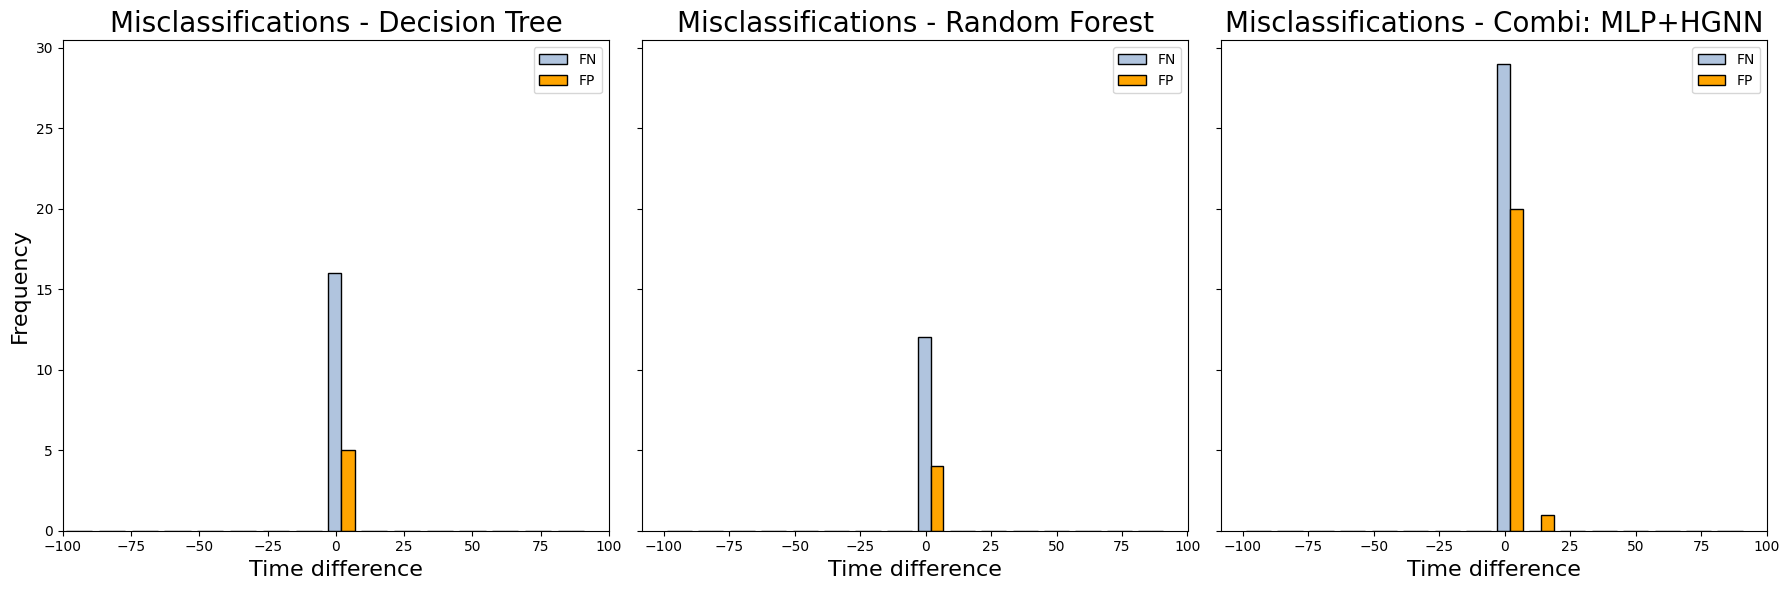

In [56]:
import matplotlib.pyplot as plt

diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']
diff_0_forest = misclass_forest[misclass_forest['pred label'] == 0]['diff rewr-orig']
diff_1_forest = misclass_forest[misclass_forest['pred label'] == 1]['diff rewr-orig']
diff_0_combi = misclass_combi[misclass_combi['pred label'] == 0]['diff rewr-orig']
diff_1_combi = misclass_combi[misclass_combi['pred label'] == 1]['diff rewr-orig']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

bins=list(range(-100, 101, 12))
axes[0].hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[0].set_xlabel('Time difference', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title('Misclassifications - Decision Tree', fontsize = 20)
axes[0].legend(title='')
axes[0].set_xlim([-100,100])
axes[1].hist([diff_0_forest, diff_1_forest], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[1].set_xlabel('Time difference', fontsize = 16)
axes[1].set_title('Misclassifications - Random Forest', fontsize = 20)
axes[1].legend(title='')
axes[2].hist([diff_0_combi, diff_1_combi], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])
axes[2].set_xlabel('Time difference', fontsize = 16)
axes[2].set_title('Misclassifications - Combi: MLP+HGNN', fontsize = 20)
axes[2].legend(title='')

plt.tight_layout()
plt.savefig("results/res_pos_extrapos_mis", dpi=300)
plt.show()

## Final model on test set (with statistical tests)

We apply the final model (= the decision tree) on the untouched test set and observe the metrics and misclassifications on it (= how well it generalizes). Additionally, we compare the mean/median between the original runtimes on the test set and the decided runtimes on the test set (either the rewritten or the original one, based on the decision program).

In [43]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [58]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9379310344827586
0.9637681159420289
0.910958904109589


array([[139,   5],
       [ 13, 133]])

We inspect the misclassifications of this final model.

In [59]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                query orig/rewr(mean)  \
2663           0           1  HETIO  9-03-DaGrGpMF-augA1            rewr   
1186           0           1  STATS  096-095-augF1-augA2            rewr   
898            0           1  STATS              074-072            rewr   
847            1           0  STATS        069-089-augF1            orig   
2386           0           1   LSQB             q1-augA2            rewr   
966            0           1  STATS        079-112-augF1            rewr   
1776           1           0  STATS  139-034-augF1-augA3            orig   
2668           1           0  HETIO  9-03-DaGrGpMF-augA6            orig   
645            0           1  STATS        052-029-augF2            rewr   
904            0           1  STATS        074-072-augF1            rewr   
2152           0           1    JOB             2c-augA2            rewr   
651            0           1  STATS        053-081-augA2            rewr   
927            0           1  STATS  075-037-augF2-augA3            rewr   
2686           0           1  HETIO  9-06-DaGiGpMF-augA3            rewr   
956            1           0  STATS  078-082-augF1-augA1            orig   
2272           0           1    JOB      17d-augF1-augA4            rewr   
962            1           0  STATS        079-112-augA1            orig   
975            0           1  STATS  079-112-augF2-augA4            rewr   

     orig/rewr+rewr(mean)  orig mean  rewr mean  rewr mean+rewr  \
2663                 orig   0.659019   0.532099        2.469362   
1186                 orig   0.528334   0.278602        2.459670   
898                  orig   0.168074   0.165539        2.036232   
847                  orig   0.142132   0.151566        2.101776   
2386                 orig   8.847823   8.641552       10.728400   
966                  orig   0.188031   0.174441        2.095897   
1776                 orig   0.101850   0.123164        2.136802   
2668                 orig   0.684626   1.001053        3.082483   
645                  orig   0.119584   0.100466        1.232856   
904                  orig   0.331262   0.300835        1.369859   
2152                 orig   0.523355   0.154868        2.475223   
651                  orig   0.071792   0.068371        1.973273   
927                  orig   0.222051   0.166732        2.138992   
2686                 orig   0.686697   0.550368        2.558550   
956                  orig   0.124348   0.200499        2.086227   
2272                 orig   8.693236   8.601801       10.985883   
962                  orig   0.273016   0.485046        2.363666   
975                  orig   0.292887   0.255209        2.193044   

      diff rewr-orig  ...                                    list table rows  \
2663       -0.126920  ...   [156278, 12321, 25246, 137, 678887, 2884, 20945]   
1186       -0.249732  ...                    [102532, 178345, 192962, 38323]   
898        -0.002535  ...              [192979, 79504, 648, 11102, 1, 77694]   
847         0.009434  ...                             [178345, 38628, 91634]   
2386       -0.206272  ...  [1361840, 11000, 1343, 111, 1311799, 1075138, ...   
966        -0.013590  ...               [73118, 9599, 178345, 102532, 38323]   
1776        0.021314  ...                      [14571, 192979, 79851, 20026]   
2668        0.316427  ...   [156278, 12321, 25246, 137, 678887, 2884, 20945]   
645        -0.019117  ...                       [192676, 6073, 78802, 38605]   
904        -0.030427  ...              [192979, 79504, 648, 11102, 1, 77694]   
2152       -0.368487  ...                                  [1, 410, 7, 1, 1]   
651        -0.003422  ...                               [79504, 5932, 40325]   
927        -0.055319  ...                    [192979, 11102, 162811, 102532]   
2686       -0.136329  ...   [173134, 12321, 25246, 137, 678887, 2884, 20945]   
956         0.076151  ...                            [101075, 178345, 38118]   
2272   

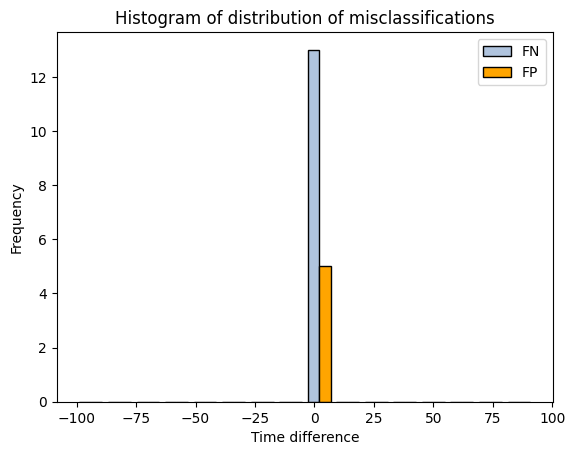

In [60]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference')
plt.ylabel('Frequency')
plt.title('Histogram of distribution of misclassifications')
plt.legend(title='')

# Show the plot
plt.show()

In [61]:
bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_3029170/2236301608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/2236301608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_3029170/2236301608.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

cut  0.01  0.1  1  10  100  TO
FP      1    2  2   0    0   0
FN      2    6  5   0    0   0

We perform the statistical tests here.

In [44]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [45]:
test_set['pred mean'] = np.where(test_set['pred label'] == 0, test_set['orig mean'], test_set['rewr mean'])
test_set.head()

pred label  true label  bench                query orig/rewr(mean)  \
2601           0           0  HETIO    6-01-BPpGeA-augF2            orig   
1713           1           1  STATS  135-136-augF2-augA3            rewr   
2179           0           0    JOB       2d-augF2-augA4            orig   
228            0           0  STATS        018-065-augF1            orig   
50             0           0  STATS        004-041-augF2            orig   

     orig/rewr+rewr(mean)  orig mean  rewr mean  rewr mean+rewr  \
2601                 orig   0.110659   0.670227        2.644188   
1713                 rewr  22.203885   0.274261        2.227593   
2179                 orig   0.001168   4.635005        6.614501   
228                  orig   0.067953   0.186914        2.192867   
50                   orig   0.023714   0.055805        1.066996   

      diff rewr-orig  ...                         list join rows  \
2601        0.559569  ...                         [1, 1, 41, 39]   
1713      -21.929625  ...  [23802149031, 45703235, 99187, 95581]   
2179        4.633837  ...                      [84, 221, 32, 32]   
228         0.118962  ...            [18768, 268, 284, 254, 571]   
50          0.032092  ...                          [162, 82, 92]   

                                  container counts list  \
2601                              [1, 1, 1, 1, 1, 2, 3]   
1713  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2179  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
228   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
50    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

      branching factors list                     hypergraph  \
2601               [1, 2, 1]  Hypergraph(num_v=10, num_e=5)   
1713                  [3, 1]  Hypergraph(num_v=29, num_e=5)   
2179                  [2, 2]  Hypergraph(num_v=30, num_e=5)   
228                      [5]  Hypergraph(num_v=37, num_e=6)   
50                    [2, 1]  Hypergraph(num_v=24, num_e=4)   

                                                   text  orig/rewr/equal 0.5  \
2601  SELECT MIN(bp.name) FROM biological_process bp...                 orig   
1713  SELECT MIN(b.id) FROM comments as c, posts as ...                 rewr   
2179  SELECT MIN(mk.id) AS movie_title FROM company_...                 orig   
228   SELECT MIN(c.Id) FROM comments as c, posts as ...                equal   
50    SELECT MIN(pl.Id) FROM postLinks as pl, posts ...                equal   

      orig/rewr/equal 0.1  orig/rewr/equal 0.05  orig/rewr/equal 0.01  \
2601                 orig                  orig                  orig   
1713                 rewr                  rewr                  rewr   
2179                 orig                  orig                  orig   
228                  orig                  orig                  orig   
50                  equal                 equal                  orig   

      pred mean  
2601   0.110659  
1713   0.274261  
2179   0.001168  
228    0.067953  
50     0.023714  

[5 rows x 53 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [64]:
w_stat, p_val = stats.wilcoxon(test_set["orig mean"], test_set["pred mean"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 114.0
P-value: 2.5330383792151602e-23


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [65]:
t_stat, p_val = stats.ttest_rel(test_set["orig mean"], test_set["pred mean"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 6.462523013764819
P-value: 4.365241086205948e-10


Finally, we inspect the decision tree as graphic and provide the feature importances (based on the Gini importance) for all features.

In [66]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins  total cost  \
Importance    0.018528     0.007986  0.032789  0.000819     0.01437   

            min(table rows)  max(table rows)  mean(table rows)  \
Importance         0.017513         0.046585          0.005178   

            q25(table rows)  median(table rows)  ...  mean(container counts)  \
Importance         0.021162             0.02148  ...                0.015743   

            q25(container counts)  median(container counts)  \
Importance                    0.0                       0.0   

            q75(container counts)  min(branching factors)  \
Importance                    0.0                 0.00097   

            max(branching factors)  mean(branching factors)  \
Importance                0.005038                 0.003172   

            median(branching factors)  q25(branching factors)  \
Importance                   0.000829                0.000917   

            q75(branching factors)  
Importance                0.002369  

[1 rows x 30 columns]

In [67]:
df_importances

Importance
#relations                   0.018528
#conditions                  0.007986
#filters                     0.032789
#joins                       0.000819
total cost                   0.014370
min(table rows)              0.017513
max(table rows)              0.046585
mean(table rows)             0.005178
q25(table rows)              0.021162
median(table rows)           0.021480
q75(table rows)              0.041745
min(join rows)               0.116054
max(join rows)               0.494756
mean(join rows)              0.015821
q25(join rows)               0.017985
median(join rows)            0.030086
q75(join rows)               0.058002
depth                        0.009621
min(container counts)        0.000000
max(container counts)        0.000482
mean(container counts)       0.015743
q25(container counts)        0.000000
median(container counts)     0.000000
q75(container counts)        0.000000
min(branching factors)       0.000970
max(branching factors)       0.005038
mean(branching factors)      0.003172
median(branching factors)    0.000829
q25(branching factors)       0.000917
q75(branching factors)       0.002369

In [68]:
clf.tree_.max_depth

17

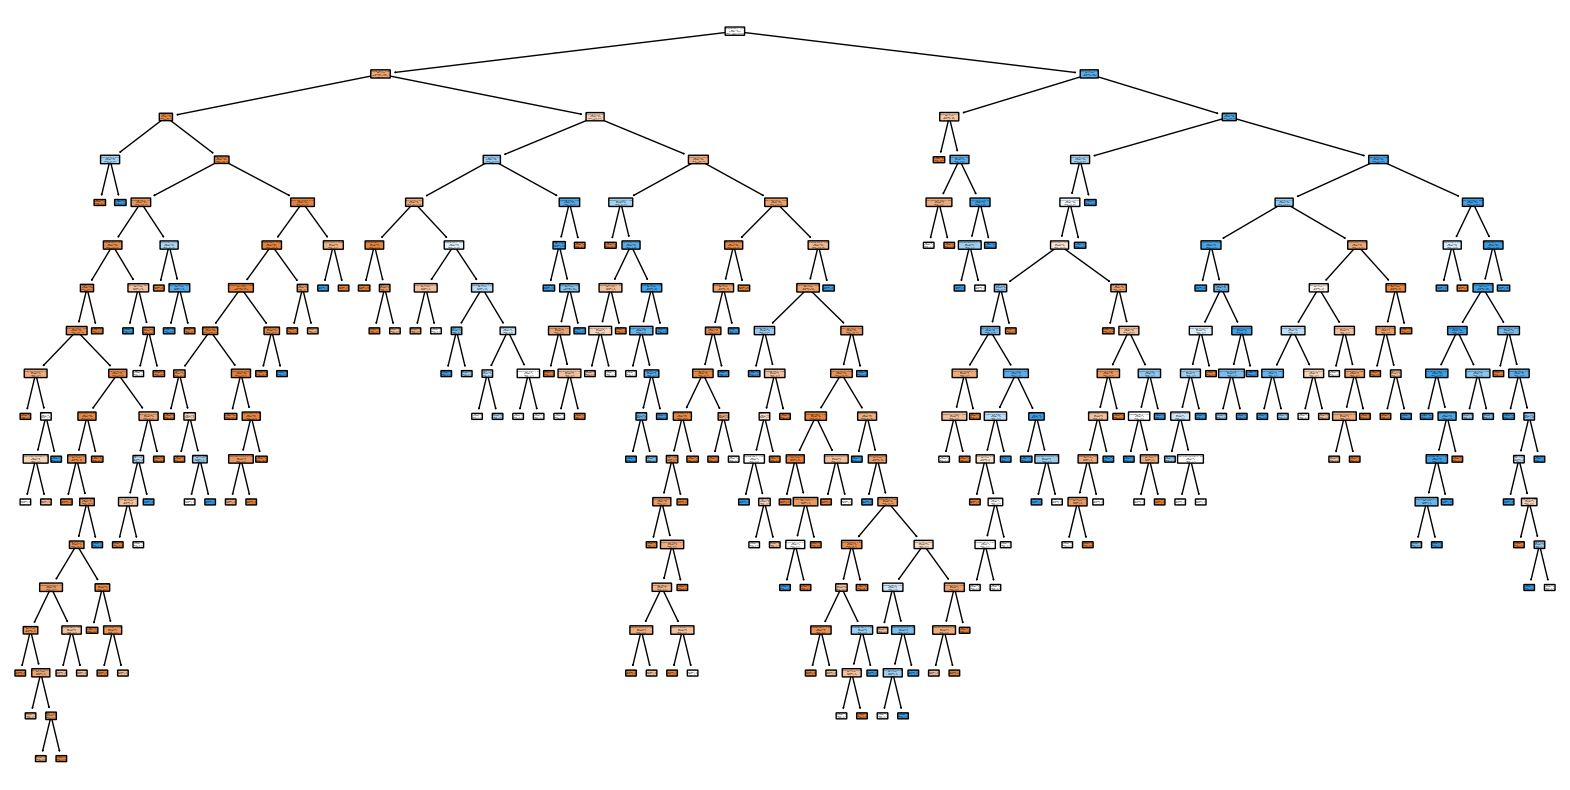

In [69]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.show()

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_193/3989257457.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_193/3989257457.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_193/3989257457.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

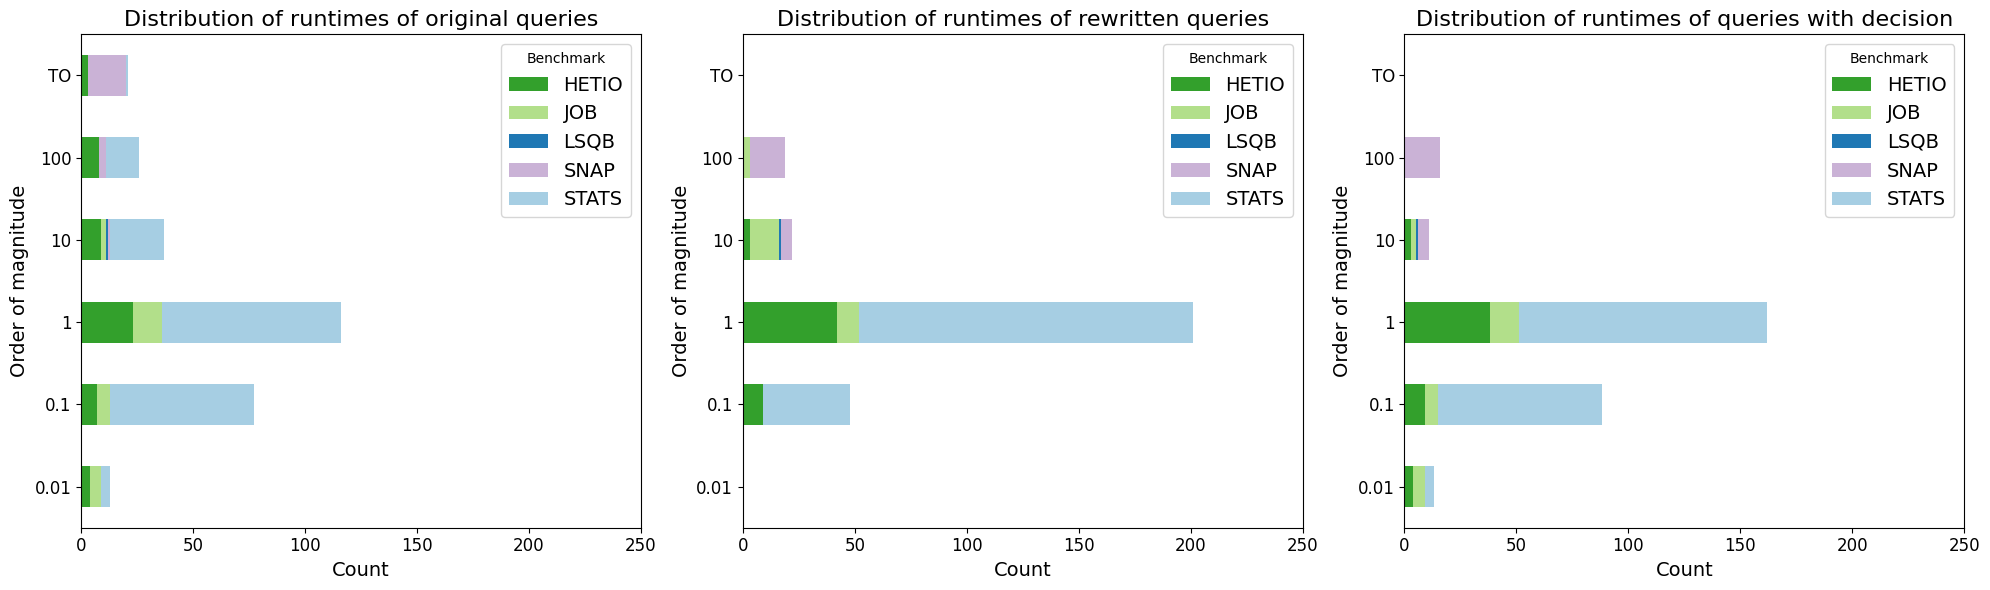

In [48]:
test_set["orig mean"] = test_set['orig mean'].astype("float64")
test_set["rewr mean"] = test_set['rewr mean'].astype("float64")
test_set["pred mean"] = test_set['pred mean'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig mean'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr mean'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred mean'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlim(0,250)
ax1.set_xlabel('Count', fontsize=14)  # Increase font size for x-axis label
ax1.set_ylabel('Order of magnitude', fontsize=14)  # Increase font size for y-axis label
ax1.set_title('Distribution of runtimes of original queries', fontsize=16)  # Increase font size for title
ax1.legend(title='Benchmark', fontsize=14)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Order of magnitude', fontsize=14)
ax2.set_title('Distribution of runtimes of rewritten queries', fontsize=16)
ax2.legend(title='Benchmark', fontsize=14)  
ax2.set_xlim(0,250)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3)
ax3.set_xlabel('Count', fontsize=14)
ax3.set_ylabel('Order of magnitude', fontsize=14)
ax3.set_title('Distribution of runtimes of queries with decision', fontsize=16)
ax3.legend(title='Benchmark', fontsize=14)  
ax3.set_xlim(0,250)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

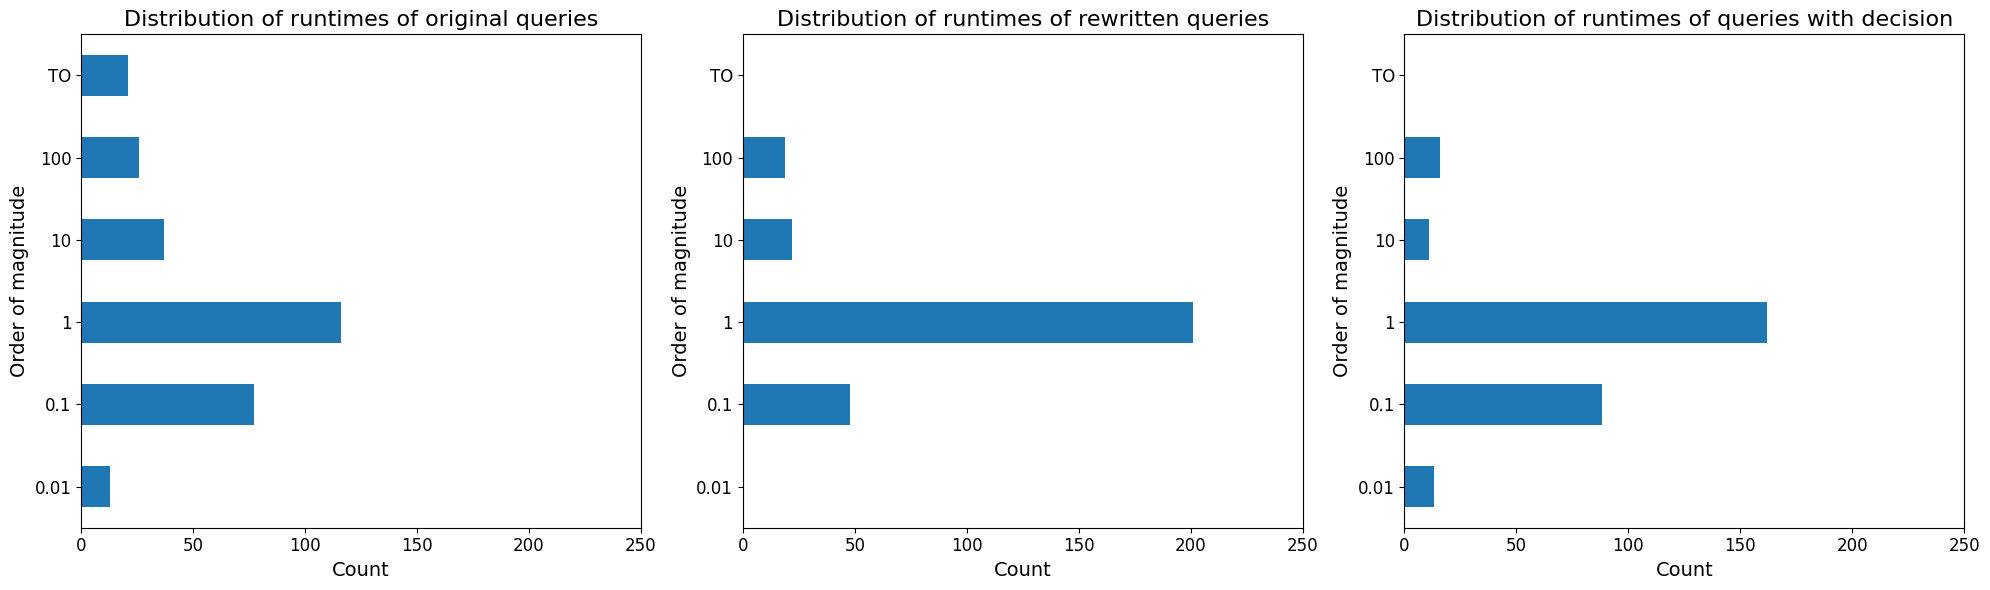

In [49]:
test_set["orig mean"] = test_set['orig mean'].astype("float64")
test_set["rewr mean"] = test_set['rewr mean'].astype("float64")
test_set["pred mean"] = test_set['pred mean'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig mean'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr mean'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred mean'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1)
ax1.set_xlim(0,250)
ax1.set_xlabel('Count', fontsize=14)  # Increase font size for x-axis label
ax1.set_ylabel('Order of magnitude', fontsize=14)  # Increase font size for y-axis label
ax1.set_title('Distribution of runtimes of original queries', fontsize=16)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Order of magnitude', fontsize=14)
ax2.set_title('Distribution of runtimes of rewritten queries', fontsize=16)
ax2.set_xlim(0,250)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3)
ax3.set_xlabel('Count', fontsize=14)
ax3.set_ylabel('Order of magnitude', fontsize=14)
ax3.set_title('Distribution of runtimes of queries with decision', fontsize=16)
ax3.set_xlim(0,250)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()